# Soccer Betting

<img src="https://www.gamblingsites.com/wp-content/uploads/2019/01/Soccer-Betting-Sites.jpg" style="width:1250px;height:300px"/>

## Overview

This notebook contains my approach to building a predictive model with the aim to minimize risk while maximizing the return on investment on soccer betting. Building a predictive model for Soccer betting is a daunting task due to many studies all over the world trying to beat the bookmakers. However, the factors contributing to betting odds are not fully traceable and in contrast to rating-based forecasts, no straightforward measure of team specific quality is deducible from the betting odds. My methodology combine different Machine Learning algorithms with different odds to build a forecasting soccer model that predict the winner of a game base on the Soccer Power Index, past performance and the odds. After several tuning,I came up with a model that can achieve higher accuracy comparing to other studies with the same purpose. I also concentrated on the best performance metrics while also minimizing the loss function.

## Business Problem

Forecasting sports events like matches or tournaments has attracted the interest of different communities all over the world for quite a long time and sport events like soccer matches take place regularly, which generate huge public attention. winning the soccer matches is becoming an essential aspect of soccer clubs and soccer fans.The global sport gambling system is multi trillion dollar rich while there are billions of soccer fans that gamble everyday without yielding a return. My aim is to educate these set of people to make a better decision using my model to predict the soccer game before making a bet with that,they can minimize loss and yield high return.

## StakeHolder:

- Soccer Analyst and Soccer Fans

## Aim of Business Problem:

- My aim is to develop an accurate model that predicts a soccer game using the Soccer Power Index.

## Context:

- False Negative: In this context predict that a soccer team will not win or draw a match when actually they win or draw.
    
- False Postive: In this context predict that a soccer team will win or draw a match when actually they will not win or draw.

## Evaluation:

- the metrics I will be looking at are:
    
    - ** Accuracy
    - ** logloss
    - ** Precision
    - ** Recall
    - ** f1 score

## Data Understanding

I obtained my dataset from https://projects.fivethirtyeight.com/soccer-predictions/ , and downloaded the soccer archive odds from https://www.kaggle.com/sashchernuh/european-football. 
- The first dataset is organized into four folders with a total of 66542rows and 27columns.
    - spi global rankings intl
    - spi glbal rankings
    - spi matches latest
    - spi matches    
- the second dataset is organized into one folder with a total of 12674rows and 13columns.
    - Football data

- After cleaning and merging the two dataset I end up with a 24750rows and 27columns.
     - Data cleaning notebook can be find in the notebook folder.
- Created the target from the home and away scores. Then I have a multiclass categories (Draw/HomeWin/AwayWin).

In [163]:
#import necessary liabries
import numpy as np
from numpy import array
from numpy import array
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
import itertools
import math
import time
import pickle

from matplotlib.legend_handler import HandlerBase
sns.set(style='whitegrid',font_scale=1.5)
%matplotlib inline


import statsmodels.formula.api as sm
import xgboost as xgb
from scipy import stats
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

Define functions that will assist with evaluating the models.

In [206]:
#define a function to evaluate the algorithms
def evaluate_model(estimator,X_train,X_test,y_train,y_test):
    """
    An evaluation function that shows the classification report 
    and log_loss for the training and the test scores.
    input: 
    Algorithm - the model best output estimator
    X_train - the training features, either scaled or unscaled
    X_test - the testing features
    y_train- the training target variable
    y_test - the testing target variable

    """

    #predictions
    train_pred = estimator.predict(X_train)
    test_pred  = estimator.predict(X_test)
    
    #Roc_auc
    train_prob = estimator.predict_proba(X_train)
    test_prob = estimator.predict_proba(X_test)
    
    #print the Training scores
    print("Training Scores:")    
    print(f"Accuracy Score: {accuracy_score(y_train,train_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_train, train_prob)}")
    print("----")
    print(classification_report(y_train,train_pred))
    
    
    print("------------")

    
    #print Test scores  
    print("Test Scores:") 
    print(f"Accuracy Score: {accuracy_score(y_test,test_pred)}")
    print("----")
    print(f"Log loss Score: {log_loss(y_test,test_prob)}")
    print("----")
    print(classification_report(y_test,test_pred))

    
    #plot Confusion matrix
    plt.figure(figsize=(14,12))
    plt.subplot(221)
    ax=sns.heatmap(confusion_matrix(y_test,test_pred,normalize='true'),
                   annot=True,linecolor='k',linewidth=2,
                   cmap =sns.color_palette('Blues',7))
    ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'],fontsize=15)
    plt.title("Confusion Matrix",fontsize=22)
    plt.xlabel("predicted Value")
    plt.ylabel("Actual Value")  

In [7]:
soccer_data = pd.read_csv("../Data/soccer-spi/soccer_matches_df.csv",index_col=0)
club_data = pd.read_csv("../Data/soccer-spi/spi_data_df.csv",index_col=0)

In [8]:
soccer_data.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,results,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,1843.0,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,NaN
1,2016,2016-08-12,1843.0,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,NaN
2,2016,2016-08-13,2411.0,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,NaN
3,2016,2016-08-13,2411.0,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,NaN
4,2016,2016-08-13,2411.0,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,NaN


In [9]:
soccer_data.shape

(24750, 27)

In [10]:
club_data.head()

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21


In [11]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24750 entries, 0 to 24749
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       24750 non-null  int64  
 1   date         24750 non-null  object 
 2   league_id    13680 non-null  float64
 3   league       24750 non-null  object 
 4   team1        24750 non-null  object 
 5   team2        24750 non-null  object 
 6   spi1         13680 non-null  float64
 7   spi2         13680 non-null  float64
 8   prob1        13680 non-null  float64
 9   prob2        13680 non-null  float64
 10  probtie      13680 non-null  float64
 11  proj_score1  13680 non-null  float64
 12  proj_score2  13680 non-null  float64
 13  importance1  11994 non-null  float64
 14  importance2  11994 non-null  float64
 15  score1       23390 non-null  float64
 16  score2       23390 non-null  float64
 17  xg1          12314 non-null  float64
 18  xg2          12314 non-null  float64
 19  nsxg

In [12]:
soccer_data.describe()

,season,league_id,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
count,24750.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,11994.000000,...,23390.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,12314.000000,9660.000000,9660.000000,9660.000000
mean,2018.347717,1958.655629,63.577162,63.476290,0.458527,0.300371,0.241103,1.568612,1.189004,33.883250,...,1.204190,1.568042,1.246478,1.450485,1.183272,1.592817,1.248203,2.847969,4.039480,4.504832
std,1.564454,205.612514,15.665622,15.726236,0.174071,0.158286,0.049817,0.465360,0.459225,26.350038,...,1.159051,0.887404,0.782651,0.711202,0.621314,1.286074,1.158185,2.119511,1.285261,3.807476
min,2016.000000,1818.000000,19.990000,19.290000,0.027000,0.003200,0.000000,0.240000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,1.100000
25%,2017.000000,1845.000000,54.840000,54.737500,0.349675,0.196400,0.223200,1.260000,0.890000,14.000000,...,0.000000,0.910000,0.660000,0.950000,0.740000,1.050000,0.000000,1.720000,3.390000,2.380000
50%,2018.000000,1854.000000,64.410000,64.380000,0.451150,0.279300,0.252400,1.490000,1.120000,28.600000,...,1.000000,1.430000,1.100000,1.340000,1.080000,1.050000,1.050000,2.250000,3.600000,3.300000
75%,2020.000000,1951.000000,74.440000,74.352500,0.558325,0.378725,0.273000,1.790000,1.400000,49.300000,...,2.000000,2.080000,1.670000,1.817500,1.490000,2.100000,2.100000,3.000000,4.200000,5.000000
max,2021.000000,2411.000000,96.570000,96.780000,0.977500,0.881600,0.342300,4.030000,3.430000,100.000000,...,9.000000,7.070000,5.990000,6.890000,5.920000,8.760000,7.230000,23.000000,21.000000,41.000000


In [13]:
club_data.describe()

,rank,prev_rank,off,def,spi
count,128.000000,128.000000,128.000000,128.000000,128.000000
mean,118.804688,118.867188,1.762266,1.040391,61.447266
std,112.485104,112.590077,0.420177,0.365005,14.928278
min,1.000000,1.000000,1.000000,0.240000,23.930000
25%,38.750000,38.750000,1.467500,0.787500,51.377500
50%,79.500000,79.500000,1.700000,0.995000,63.295000
75%,164.250000,168.750000,1.980000,1.250000,71.595000
max,513.000000,513.000000,3.640000,2.090000,93.720000


## Data Preparation

The data features are not clearly defined so I had to rename some of the features and create a target for the dataset. After creating the target I noticed that there was a slightly imbalanced multi-classification problem. I had to balance these during modeling to avoid bias information. The method I used in balancing the dataset was SMOTE: oversampling for multi-class classification. Also, during the preparation I had to address the missing values and drop some redundant columns that are not needed for the analysis due to multicollinearity and data leakeage. 

Now I am going to create the target using the scores from the two games, Home and Away. I will drop the result column since we are not going to need it.

In [14]:
#drop the result column
soccer_data=soccer_data.drop(['results','league_id'],axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [15]:
soccer_data.shape

(24750, 25)

In [16]:
soccer_data.isna().sum()

season             0
date               0
league             0
team1              0
team2              0
spi1           11070
spi2           11070
prob1          11070
prob2          11070
probtie        11070
proj_score1    11070
proj_score2    11070
importance1    12756
importance2    12756
score1          1360
score2          1360
xg1            12436
xg2            12436
nsxg1          12436
nsxg2          12436
adj_score1     12436
adj_score2     12436
B365_Home      15090
B365_Draw      15090
B365A_way      15090
dtype: int64

In [17]:
#remove the null values in score1 column
soccer_data = soccer_data[soccer_data['score1'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [18]:
soccer_data = soccer_data[soccer_data['score2'].notna()]
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,1.0,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.0,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,1.0,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,1.0,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.0,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN


In [19]:
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23390 entries, 0 to 24749
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       23390 non-null  int64  
 1   date         23390 non-null  object 
 2   league       23390 non-null  object 
 3   team1        23390 non-null  object 
 4   team2        23390 non-null  object 
 5   spi1         12320 non-null  float64
 6   spi2         12320 non-null  float64
 7   prob1        12320 non-null  float64
 8   prob2        12320 non-null  float64
 9   probtie      12320 non-null  float64
 10  proj_score1  12320 non-null  float64
 11  proj_score2  12320 non-null  float64
 12  importance1  11899 non-null  float64
 13  importance2  11899 non-null  float64
 14  score1       23390 non-null  float64
 15  score2       23390 non-null  float64
 16  xg1          12314 non-null  float64
 17  xg2          12314 non-null  float64
 18  nsxg1        12314 non-null  float64
 19  nsxg

In [20]:
soccer_data.shape

(23390, 25)

Define a function that will assist with creating the target from the scores.

In [21]:
def make_target(df):
    """
    input: the dataframe(df)
    0=draw
    1=team1(home)- win
    2=team2(Away)- win
    """
    if df['score1'] == df['score2']:
        return 0
    elif df['score1'] > df['score2']:
        return 1
    elif df['score1'] < df['score2']:
        return 2
    else:
        return 'none'

In [22]:
#Create a target column
soccer_data['target'] = soccer_data.apply(make_target,axis=1)
soccer_data.head()

,season,date,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,B365_Home,B365_Draw,B365A_way,target
0,2016,2016-08-12,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,0.97,0.63,0.43,0.45,0.00,1.05,NaN,NaN,NaN,2
1,2016,2016-08-12,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,2.45,0.77,1.75,0.42,2.10,2.10,NaN,NaN,NaN,0
2,2016,2016-08-13,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,0.85,2.77,0.17,1.25,2.10,1.05,NaN,NaN,NaN,1
3,2016,2016-08-13,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,0.73,1.11,0.88,1.81,1.05,1.05,NaN,NaN,NaN,0
4,2016,2016-08-13,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,1.11,0.68,0.84,1.60,0.00,1.05,NaN,NaN,NaN,2


In [25]:
#checking if the target is balanced
soccer_data.target.value_counts(normalize=True)

1    0.451389
2    0.300770
0    0.247841
Name: target, dtype: float64

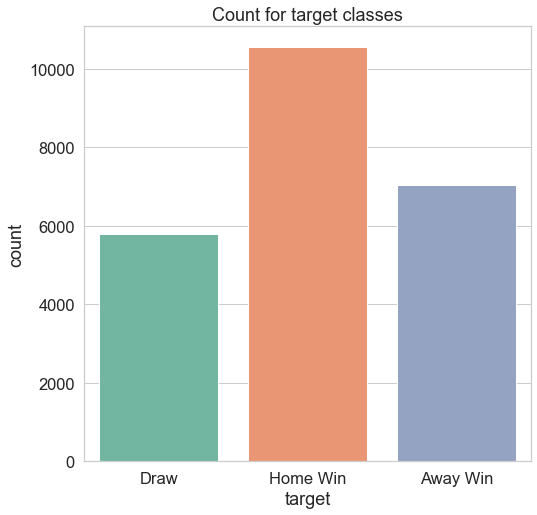

In [26]:
#plot the target to view the target class
plt.figure(figsize=(8,8))
ax=sns.countplot(x = soccer_data["target"],palette = 'Set2')
plt.title("Count for target classes")
labels=['Draw','Home Win','Away Win']
ax.set_xticklabels(labels)
plt.show()

Looking at the plot above, you can see that the data is slightly imbalance and it clearly shows that most matches always end with a home win. Now we will be looking at the features and visualizing how they correlate with the target while we check for multicollinearity.

# Data Visualization

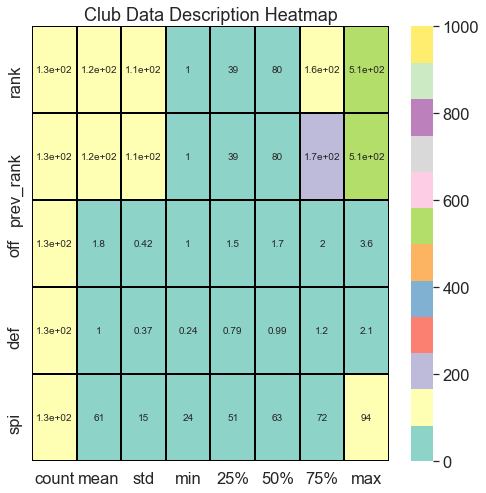

In [30]:
#let's visualize the club data description
plt.figure(figsize=(8,8))
ax=sns.heatmap(club_data.describe().transpose(),annot=True,fmt='.2g',
               linecolor='black',linewidths=1,vmin =0,vmax=1000,
               cmap=sns.color_palette('Set3'))
plt.title("Club Data Description Heatmap")
plt.show()

The club data tells us that the mean of the soccer power index of the team is 61 and the standard deviation of the previous rank of the teams and latest rank is 1. Let's look at the multicollinearity among the features on the soccer dataset.

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

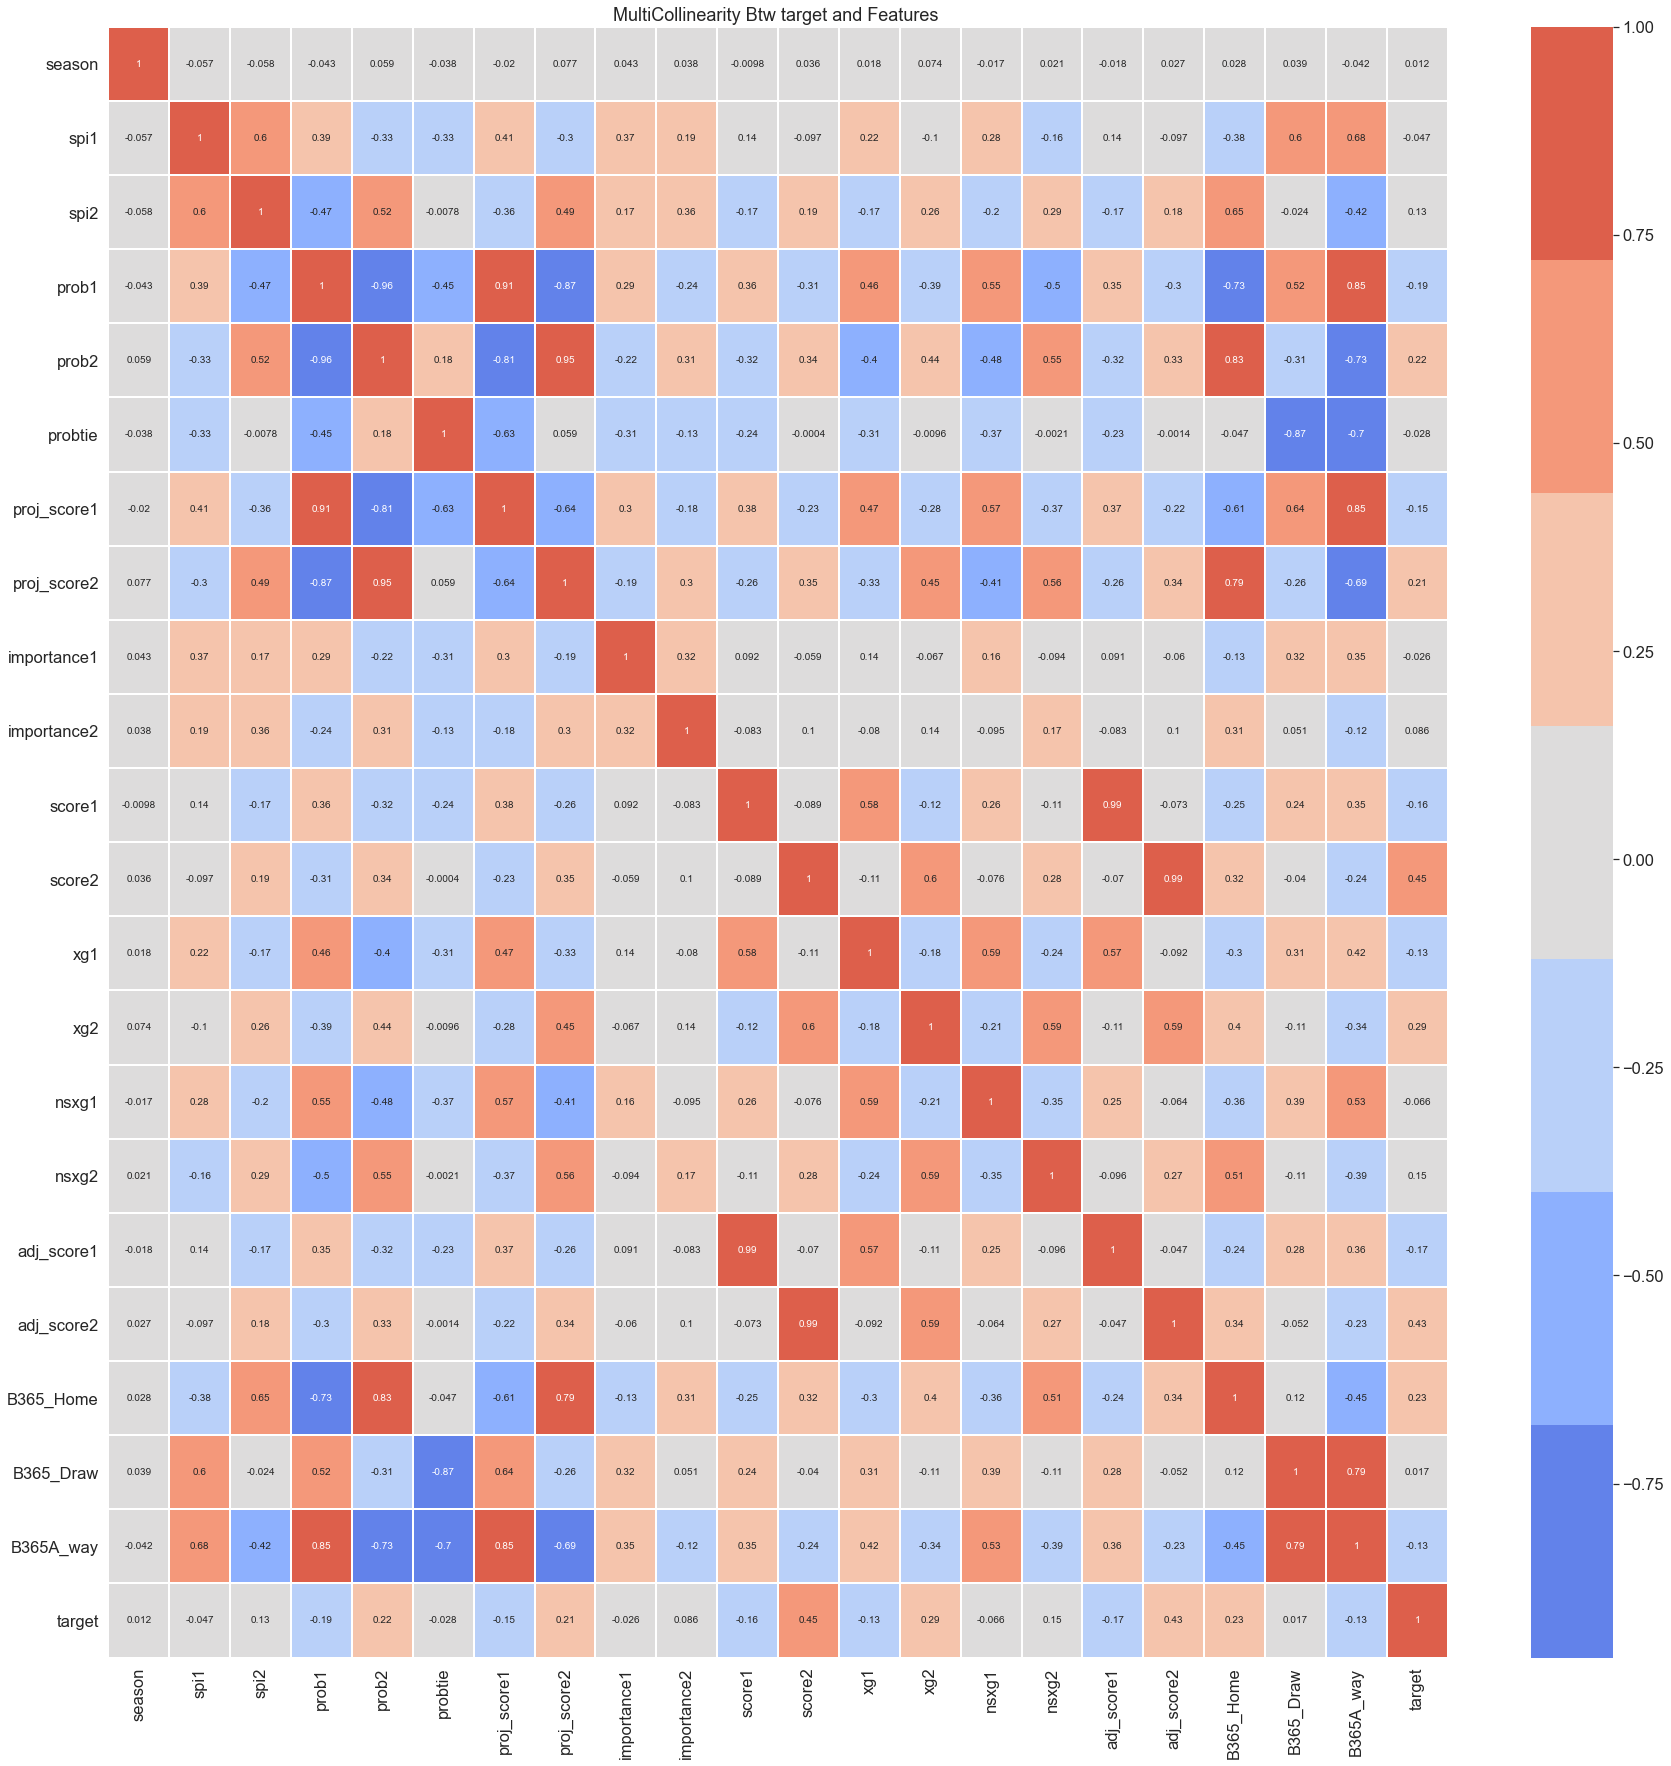

In [31]:
#let's visualize the multicolinearity among the features on soccer dataset
plt.figure(figsize=(30,30))
correlation = soccer_data.corr()
ax=sns.heatmap(correlation,annot=True,cmap =sns.color_palette('coolwarm',7),
              linewidths=1,linecolor='white')
plt.title("MultiCollinearity Btw target and Features ")

Looking at the table,there is multicollinearity between the scores and the adjusted scores. Also, there are some redundant columns that we need to drop because they will not add meaningful information to our model. I will drop the dates, nsxg1 and nsxg2, the projected scores due to the close correlation between the prob1 and prob2.

In [32]:
#drop redundant columns
soccer_final_df = soccer_data.drop(['date','nsxg1','nsxg2','proj_score1',
                                    'adj_score1','adj_score2','proj_score2',],axis =1)
soccer_final_df.head()

,season,league,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,B365_Home,B365_Draw,B365A_way,target
0,2016,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,NaN,NaN,NaN,2
1,2016,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,NaN,NaN,NaN,0
2,2016,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,NaN,NaN,NaN,1
3,2016,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,NaN,NaN,NaN,0
4,2016,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,NaN,NaN,NaN,2


In [33]:
soccer_final_df.shape

(23390, 19)

In [34]:
#fill the nan value with 0 for the Bet365 odd columns
soccer_final_df.update(soccer_final_df[['B365_Home','B365_Draw','B365A_way']].fillna(0))

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

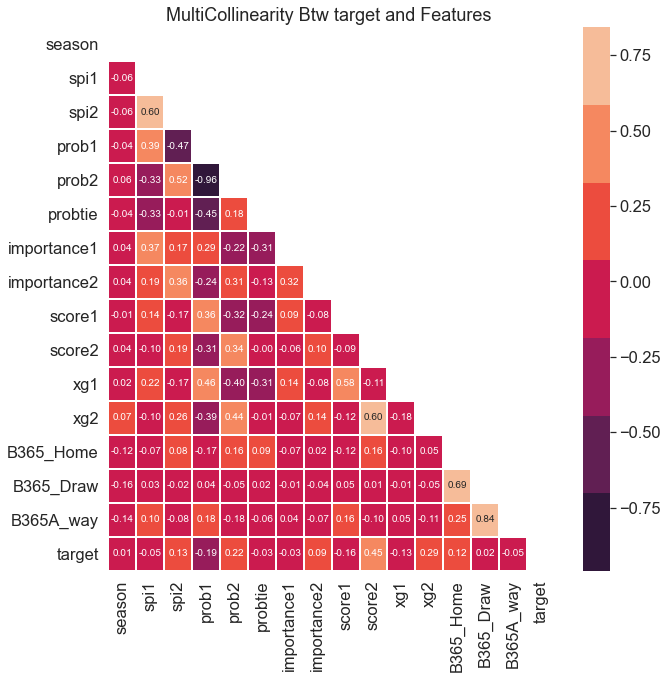

In [35]:
#plot the new dataframe to check multicollinearity
plt.figure(figsize = (10,10))
ax = sns.heatmap(soccer_final_df.corr(),mask =np.triu(np.ones_like(soccer_final_df.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=1,linecolor='white',fmt='.2f')
plt.title("MultiCollinearity Btw target and Features ")

Now everything seems to be fine except for the bet365 odds, due to not having enough data, most of the columns is empty, even though I filled with zeros, there is not enough odds to use in processing the model. I will be dropping it aswell. 

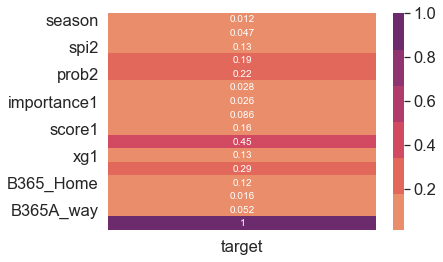

In [37]:
#checking to see the most correlated features
sns.heatmap(abs(soccer_final_df.corr())[['target']], annot = True,
            cmap =sns.color_palette('flare'));

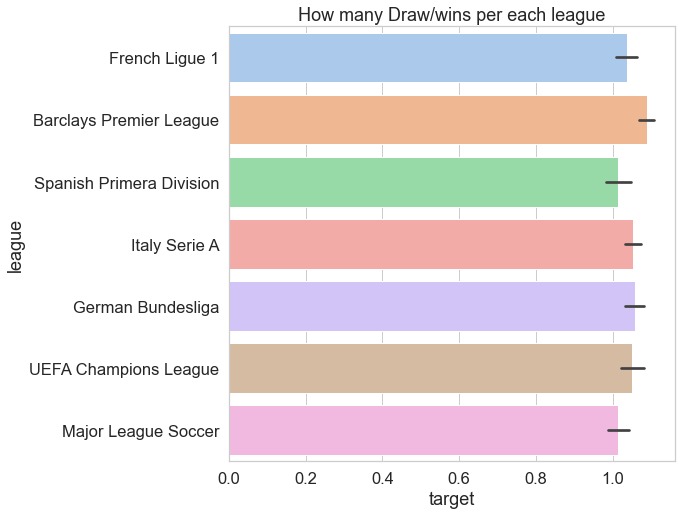

In [38]:
#plot a bargraph using the leagues to see how many times there is a draws/win
plt.figure(figsize=(8,8))
ax=sns.barplot(data = soccer_final_df,x ='target',y ='league',palette = 'pastel')
plt.title("How many Draw/wins per each league")
plt.show()

Looking at the above chart, it shows that most of the leagues win the game at home. We are going to look at the target again using the probability scores and probtie columns but before then we are going to drop the league column and some other columns that will not be needed for the analysis.

In [39]:
#drop more columns due to alot of nan values 
soccer_df = soccer_final_df.drop(['league','B365_Home','B365_Draw','B365A_way'],axis =1)
soccer_df = soccer_df.dropna().reset_index(drop=True)
soccer_df.head(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2
5,2016,Middlesbrough,Stoke City,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0
6,2016,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2
7,2016,Southampton,Watford,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0
8,2016,Bordeaux,St Etienne,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1
9,2016,Manchester City,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1


In [40]:
soccer_df.tail(10)

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target
11884,2021,Borussia Monchengladbach,SpVgg Greuther Fürth,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4.0,0.0,2.20,0.31,1
11885,2021,Watford,Manchester United,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4.0,1.0,2.99,1.72,1
11886,2021,Burnley,Crystal Palace,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3.0,3.0,1.37,1.87,0
11887,2021,Newcastle,Brentford,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3.0,3.0,2.51,1.11,0
11888,2021,Norwich City,Southampton,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2.0,1.0,0.53,1.09,1
11889,2021,Aston Villa,Brighton and Hove Albion,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2.0,0.0,1.05,0.35,1
11890,2021,Wolverhampton,West Ham United,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1.0,0.0,1.44,0.42,1
11891,2021,Sevilla FC,Alavés,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2.0,2.0,1.46,1.41,0
11892,2021,Paris Saint-Germain,Nantes,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3.0,1.0,1.62,1.25,1
11893,2021,Lazio,Juventus,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0.0,2.0,0.34,2.73,2


In [41]:
#combine the home and away team to make a single team
#to avoid data leakeage.
soccer_df['team'] = soccer_df['team1'].combine_first(soccer_df['team2'])
soccer_df.head()

,season,team1,team2,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace


In [42]:
#drop the team1 and team2 column
soccer_df = soccer_df.drop(['team1','team2',],axis =1)
soccer_df = soccer_df.reset_index(drop=True)
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
0,2016,51.16,85.68,0.0463,0.8380,0.1157,32.4,67.7,0.0,1.0,0.97,0.63,2,Bastia
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.0,2.0,2.45,0.77,0,AS Monaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2.0,1.0,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1.0,1.0,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0.0,1.0,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.0,1.0,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0.0,1.0,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.0,1.0,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3.0,2.0,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.0,1.0,2.14,1.25,1,Manchester City


In [43]:
soccer_df.shape

(11894, 14)

In [74]:
len(soccer_df['season'])

11894

In [116]:
# group_df = soccer_df.groupby(['target'],as_index=False).apply(lambda x: ['team']).count().sort_values('target',ascending=False)
# group_df.reset_index(drop=True,inplace=True)
# group_df

Out of 11894 season in the league that I decided to analyze, 5421 of the teams always win at home while 3561 win at the away matches and 2912 draw either at home matches or Away matches.

In [117]:
soccer_df.isnull().sum()

season         0
spi1           0
spi2           0
prob1          0
prob2          0
probtie        0
importance1    0
importance2    0
score1         0
score2         0
xg1            0
xg2            0
target         0
team           0
dtype: int64

Now that we have been able to pare down the dataset,we can go ahead and plot a 3d plot that will show the full-time results using the predicted probabilities of a soccer game.


0: Draw
1: Home Win
2: Away Win


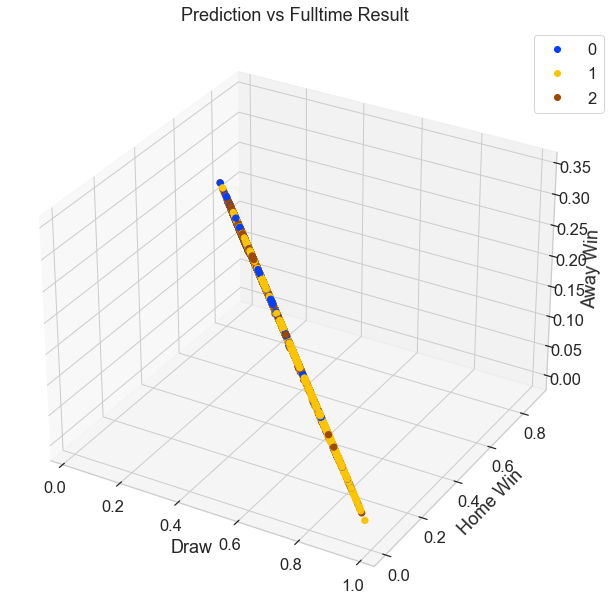

In [118]:
#plot the probabilities

# axes instance
df = soccer_df
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
fig.add_axes(ax)

x = df['prob1']
y = df['prob2']
z = df['probtie']

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("bright", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=df['target'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel("Draw")
ax.set_ylabel("Home Win")
ax.set_zlabel("Away Win")
ax.set_title("Prediction vs Fulltime Result")

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=1)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#make the font bold 
bold_start = '\033[1m'


print(bold_start)
print('0: Draw')
print('1: Home Win')
print('2: Away Win')

Also, I will plot at the distribution of the features to see if it is normal or skewed.

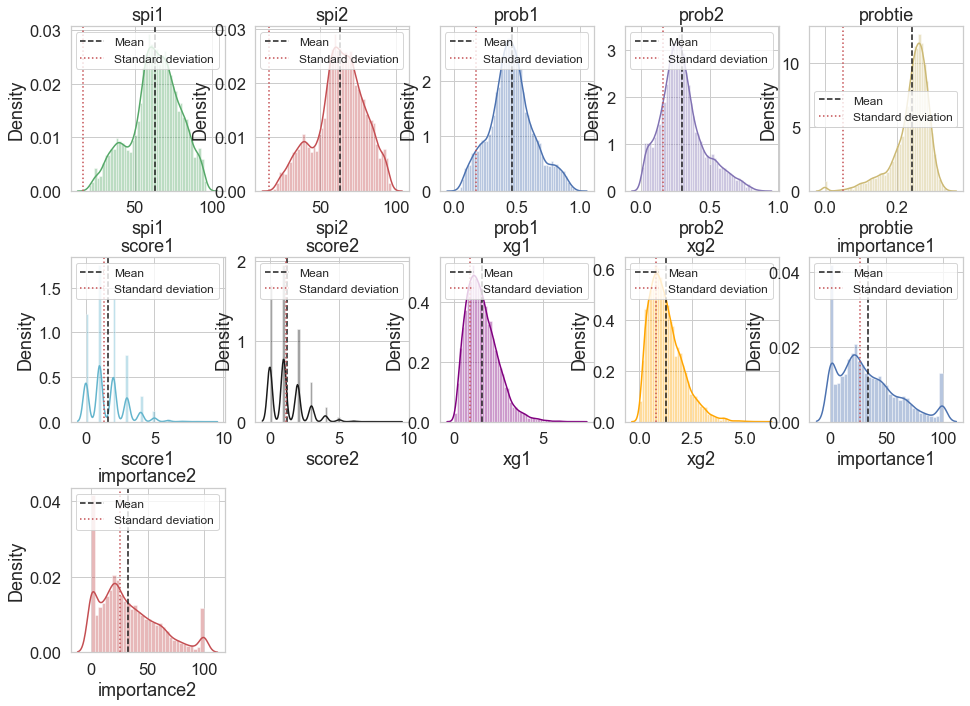

In [119]:
#plot distribution of all features
columns = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2']
length = len(columns)
colors= ['g','r','b','m','y','c','k','purple','orange','b','r']

plt.figure(figsize=(16,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/2, j+1)
    sns.distplot(soccer_df[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .4)
    plt.axvline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean')
    plt.axvline(soccer_df[i].std(), color='r', linestyle='dotted',label='Standard deviation')
    plt.legend(loc='best',prop={'size':12})

The SPIs and the Probs seems to follow almost a normal distribution, which is what we want actually. Now we are going to compare the features with the target using boxplots.

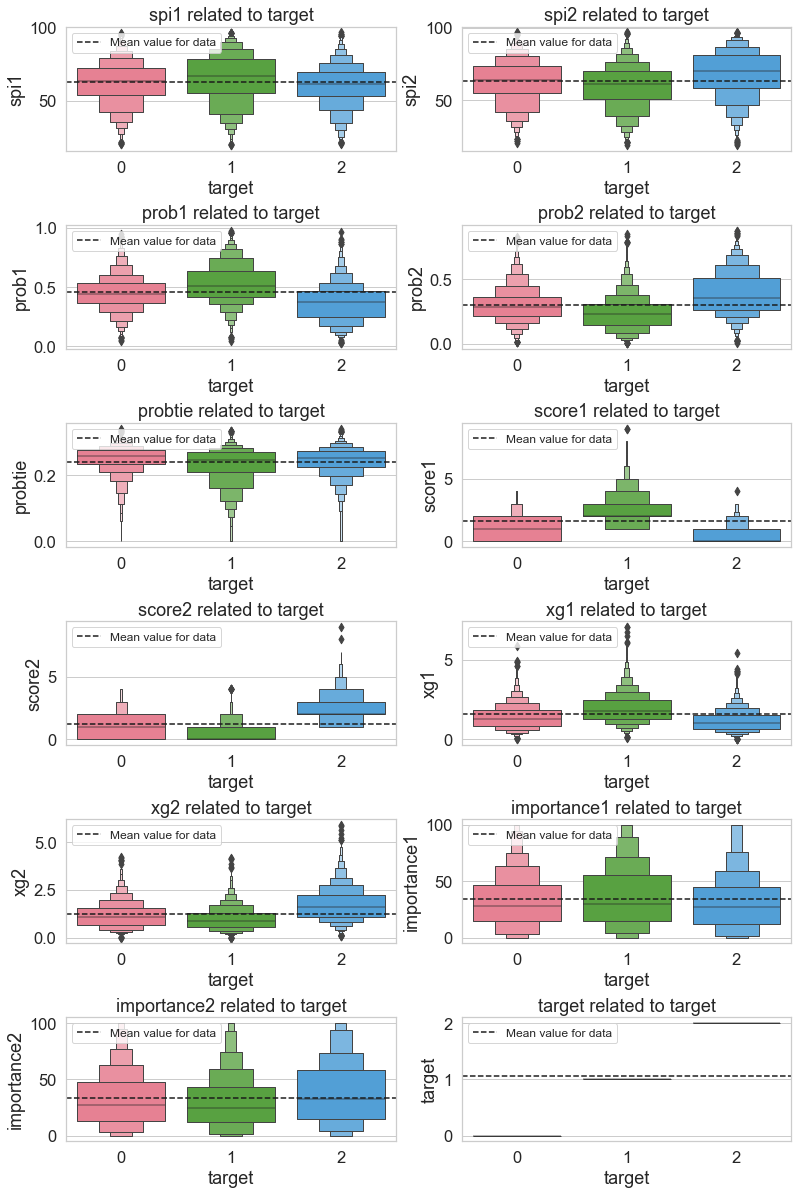

In [120]:
#visualize the target if it related to the correlated features
cols = ['spi1','spi2','prob1','prob2','probtie','score1','score2','xg1','xg2','importance1','importance2','target']

columns = [x for x in cols if x not in ['target_class']]
length = len(columns)

plt.figure(figsize=(13,18))
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(6,2,j+1)
    plt.subplots_adjust(bottom =1/50)
    sns.boxenplot(x=soccer_df['target'],y=soccer_df[i],palette = 'husl')
    plt.title(i + " related to target")
    plt.subplots_adjust(hspace = .6)
    plt.axhline(soccer_df[i].mean(), color='k', linestyle='dashed',label='Mean value for data')
    plt.legend(loc='upper left',prop={'size':12})

As you can see the EDA and visualization really tells us alot of information about the soccer dataset. Now I am going to use the features to build a predictive model that is going to prompt users for probability of the clubs winning the match either home or away.

## Modeling

My approach of modelling was using supervised Machine learning techniques to check the effectiveness of each performance metrics to analyze the dataset for accuracy.Although Different Machine learning models were considered for the project but I decide to use logistic Regression as my basline model so I can use it to compare the accuracy of the other models.

I also compared different models using the mean and standard deviation of the accuracy scores. The scores were lower than the baseline score especially the KNN algorithm.then I went ahead using gridsearchCV to tune each model for a better result while minimizing the loss function.



In [121]:
#bring in the saved soccer data
soccer_df = pd.read_csv("../Data/soccer-spi/soccer_df.csv",index_col=0)
club_data = pd.read_csv("../Data/soccer-spi/club_data.csv",index_col=0)

In [122]:
soccer_df.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2,2,2.45,0.77,0,ASMonaco
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,2,1,0.85,2.77,1,Hull City
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,1,1,0.73,1.11,0,Everton
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,0,1,1.11,0.68,2,Crystal Palace
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1,1,1.40,0.55,0,Middlesbrough
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,0,1,1.24,1.84,2,Burnley
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1,1,1.05,0.22,0,Southampton
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,3,2,1.03,1.84,1,Bordeaux
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2,1,2.14,1.25,1,Manchester City
10,2016,55.00,54.90,0.4471,0.2490,0.3038,29.2,25.6,0,1,0.30,1.17,2,DijonFCO


In [123]:
soccer_df.tail(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,score1,score2,xg1,xg2,target,team
11884,2021,73.99,54.36,0.6454,0.1410,0.2136,41.2,30.5,4,0,2.20,0.31,1,Borussia Monchengladbach
11885,2021,59.62,80.86,0.1957,0.5770,0.2273,46.8,47.2,4,1,2.99,1.72,1,Watford
11886,2021,65.84,71.28,0.3898,0.3436,0.2666,37.4,14.6,3,3,1.37,1.87,0,Burnley
11887,2021,61.00,69.45,0.3583,0.3789,0.2628,47.5,24.5,3,3,2.51,1.11,0,Newcastle
11888,2021,55.19,69.71,0.2865,0.4382,0.2753,36.1,22.1,2,1,0.53,1.09,1,Norwich City
11889,2021,70.01,76.08,0.3729,0.3578,0.2692,27.7,21.6,2,0,1.05,0.35,1,Aston Villa
11890,2021,71.28,78.51,0.2841,0.4536,0.2623,12.7,59.5,1,0,1.44,0.42,1,Wolverhampton
11891,2021,78.84,62.97,0.6454,0.1172,0.2374,70.4,28.3,2,2,1.46,1.41,0,Sevilla FC
11892,2021,81.85,58.75,0.7338,0.1002,0.1660,44.3,16.8,3,1,1.62,1.25,1,Paris Saint-Germain
11893,2021,69.88,78.62,0.2984,0.4584,0.2432,51.4,73.0,0,2,0.34,2.73,2,Lazio


In [124]:
club_data.head(10)

,rank,prev_rank,name,league,off,def,spi
0,1,1,Bayern Munich,German Bundesliga,3.64,0.51,93.72
1,2,2,Manchester City,Barclays Premier League,2.97,0.24,93.57
2,3,3,Liverpool,Barclays Premier League,3.06,0.46,91.04
3,4,4,Chelsea,Barclays Premier League,2.47,0.24,90.32
5,6,6,Real Madrid,Spanish Primera Division,2.57,0.62,84.21
6,7,8,Internazionale,Italy Serie A,2.59,0.66,83.64
7,8,9,Atletico Madrid,Spanish Primera Division,2.29,0.51,83.19
8,9,10,Barcelona,Spanish Primera Division,2.44,0.62,82.68
9,10,7,RB Leipzig,German Bundesliga,2.53,0.70,82.23
10,11,11,Paris Saint-Germain,French Ligue 1,2.52,0.75,81.16


In [125]:
soccer_df.shape , club_data.shape

((11891, 14), (128, 7))

In [126]:
#check the data info
soccer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11891 entries, 1 to 11893
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       11891 non-null  int64  
 1   spi1         11891 non-null  float64
 2   spi2         11891 non-null  float64
 3   prob1        11891 non-null  float64
 4   prob2        11891 non-null  float64
 5   probtie      11891 non-null  float64
 6   importance1  11891 non-null  float64
 7   importance2  11891 non-null  float64
 8   score1       11891 non-null  int64  
 9   score2       11891 non-null  int64  
 10  xg1          11891 non-null  float64
 11  xg2          11891 non-null  float64
 12  target       11891 non-null  int64  
 13  team         11891 non-null  object 
dtypes: float64(9), int64(4), object(1)
memory usage: 1.4+ MB


In [127]:
#let's drop the team and the score columns to avoid data leakeage
soccer_final= soccer_df.drop(['team','score1','score2'],axis =1)
soccer_final.head(10)

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
1,2016,68.85,56.48,0.5714,0.1669,0.2617,53.7,22.9,2.45,0.77,0
2,2016,53.57,66.81,0.3459,0.3621,0.2921,38.1,22.2,0.85,2.77,1
3,2016,68.02,73.25,0.3910,0.3401,0.2689,31.9,48.0,0.73,1.11,0
4,2016,55.19,58.66,0.4214,0.2939,0.2847,43.6,34.6,1.11,0.68,2
5,2016,56.32,60.35,0.4380,0.2692,0.2927,33.9,32.5,1.40,0.55,0
6,2016,58.98,59.74,0.4482,0.2663,0.2854,36.5,29.1,1.24,1.84,2
7,2016,69.49,59.33,0.5759,0.1874,0.2367,34.1,30.7,1.05,0.22,0
8,2016,62.01,64.92,0.4232,0.2764,0.3004,37.9,44.2,1.03,1.84,1
9,2016,86.42,53.64,0.8152,0.0525,0.1323,73.0,27.0,2.14,1.25,1
10,2016,55.00,54.90,0.4471,0.2490,0.3038,29.2,25.6,0.30,1.17,2


In [128]:
#final data description
soccer_final.describe()

,season,spi1,spi2,prob1,prob2,probtie,importance1,importance2,xg1,xg2,target
count,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000,11891.000000
mean,2018.384913,63.116417,63.007739,0.460752,0.298360,0.240889,33.798335,33.025187,1.568274,1.247697,1.054495
std,1.546782,15.961851,16.047286,0.174582,0.158342,0.050349,26.304146,25.988058,0.885074,0.780664,0.735767
min,2016.000000,19.990000,19.290000,0.027000,0.003700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,54.370000,54.210000,0.353750,0.195400,0.222600,14.000000,13.300000,0.910000,0.670000,1.000000
50%,2018.000000,63.970000,63.920000,0.453400,0.277100,0.252000,28.500000,27.500000,1.430000,1.100000,1.000000
75%,2020.000000,74.270000,74.160000,0.559250,0.374150,0.273400,49.100000,49.000000,2.080000,1.670000,2.000000
max,2021.000000,96.570000,96.690000,0.977500,0.881600,0.342300,100.000000,100.000000,7.070000,5.900000,2.000000


In [177]:
#Define X and y
X = soccer_final.drop('target', axis =1)
y = soccer_final['target']

#holdout set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,random_state=42)

#training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2,random_state=42)

In [178]:
y.value_counts(normalize=True)

1    0.455723
2    0.299386
0    0.244891
Name: target, dtype: float64

In [195]:
#normalize the features
scaler = MinMaxScaler()
scaled = scaler.fit(X_train)

X_train_scaled = scaled.transform(X_train)
X_test_scaled = scaled.transform(X_test)

In [196]:
X_train_scaled.shape, X_test_scaled.shape , X_val.shape

((7609, 10), (1903, 10), (2379, 10))

In [197]:
y_train.shape , y_test.shape , y_val.shape

((7609,), (1903,), (2379,))

We are going to use SMOTE to balance our data. SMOTE simply add duplicate cases to our training dataset to avoid a bias model. It generates new sample data by creating synthetic examples that are combinations of the closest minority classes of the cases.

In [198]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    5419
2    3560
0    2912
Name: target, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

2    3460
1    3460
0    3460
Name: target, dtype: int64


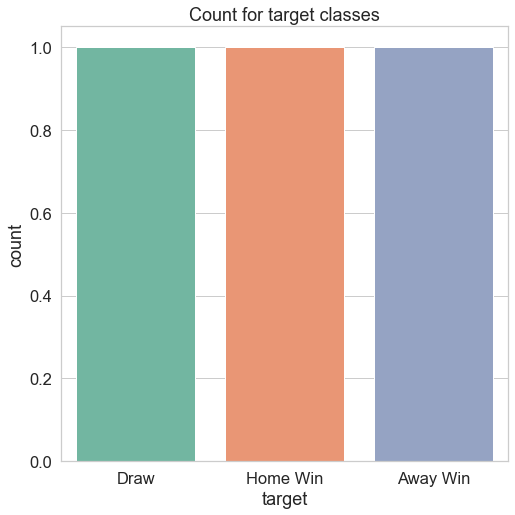

In [199]:
#plot the target to view the target class
plt.figure(figsize=(8,8))
ax=sns.countplot(x = y.value_counts(),palette = 'Set2')
plt.title("Count for target classes")
labels=['Draw','Home Win','Away Win']
ax.set_xticklabels(labels)
plt.show()

### Baseline Understanding

I will be building a baseline model to compare with the other models using the accuracy score. The goal is to improve the score and to beat the bookmaker odds.

In [291]:
#instantiate the logistic Regression model
baseline_model = LogisticRegression(multi_class='multinomial')
baseline_model.fit(X_train_resampled,y_train_resampled)

#print the accuracy scores
print(f"Train accuracy score: {baseline_model.score(X_train_resampled,y_train_resampled)}")

print('-----')

print(f"Test accuracy score: {baseline_model.score(X_test_scaled,y_test)}")

Train accuracy score: 0.5492292870905587
-----
Test accuracy score: 0.5680504466631634


In [292]:
#predict the model on train set
train_pred = baseline_model.predict(X_train_resampled)
train_prob = baseline_model.predict_proba(X_train_resampled)
# Was our model correct?
residuals = y_train_resampled == train_pred

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     5701
False    4679
Name: target, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.549229
False    0.450771
Name: target, dtype: float64


In [293]:
#predict the model on test set
test_pred = baseline_model.predict(X_test_scaled)
test_prob = baseline_model.predict_proba(X_test_scaled)

# Was our model correct?
residuals = y_test == test_pred

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

print('\n','-'*30,'\n')

print('Percentage of values correctly predicted: ')
print(pd.Series(residuals).value_counts(normalize=True))

Number of values correctly predicted:
True     1081
False     822
Name: target, dtype: int64

 ------------------------------ 

Percentage of values correctly predicted: 
True     0.56805
False    0.43195
Name: target, dtype: float64


Accuracy Score: 0.5680504466631634
----
Log loss Score: 0.9190504088737536
----
              precision    recall  f1-score   support

           0       0.33      0.42      0.37       441
           1       0.71      0.60      0.65       887
           2       0.62      0.63      0.62       575

    accuracy                           0.57      1903
   macro avg       0.55      0.55      0.55      1903
weighted avg       0.59      0.57      0.58      1903



Text(97.5, 0.5, 'Actual Value')

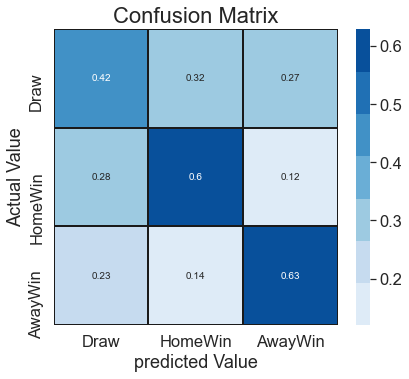

In [294]:
#plot a confusion matrix 

print(f"Accuracy Score: {accuracy_score(y_test,test_pred)}")
print("----")
print(f"Log loss Score: {log_loss(y_test, test_prob)}")
print("----")
print(classification_report(y_test,test_pred))


plt.figure(figsize=(14,12))
plt.subplot(221)
ax=sns.heatmap(confusion_matrix(y_test,test_pred,normalize='true'),
               annot=True,linecolor='k',linewidth=1,
               cmap =sns.color_palette('Blues',7))
ax.xaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
ax.yaxis.set_ticklabels(['Draw','HomeWin','AwayWin'])
plt.title("Confusion Matrix",fontsize=22)
plt.xlabel("predicted Value")
plt.ylabel("Actual Value")

The baseline model was able to predict an accuracy score of 59% on the test set with a probability of loss at -0.9. with this information,I will go ahead and build more model and compare the results with the baseline model.

### First Models without parameters

Here, I will build different types of model without a parameter then compare it against the baseline model. The results will help to decide how to tune each model for better score.

knn model: 0.618304 (0.057575)
decision tree: 0.566570 (0.045881)
Random forest: 0.695376 (0.064207)
Naive Bayes: 0.520520 (0.009564)
xgboost: 0.621676 (0.042355)
SVC model: 0.551541 (0.016800)


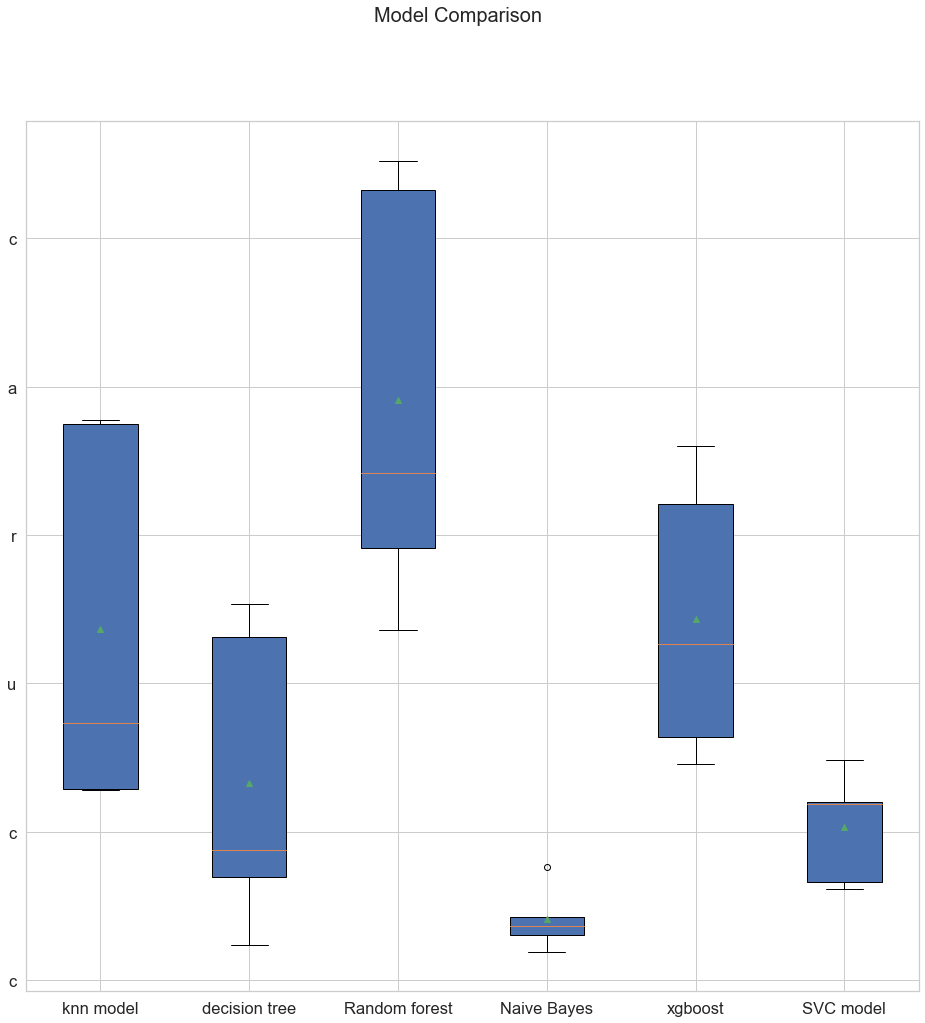

In [194]:
#prepare models
models =[]
models.append(('knn model',KNeighborsClassifier()))
models.append(('decision tree',DecisionTreeClassifier()))
models.append(('Random forest',RandomForestClassifier()))
models.append(('Naive Bayes',GaussianNB()))
models.append(('xgboost',XGBClassifier()))
models.append(('SVC model',SVC()))

#evaluate each models
results=[]
names=[]
scoring ='accuracy'
for name, model in models:
    cv_results = cross_val_score(model,X_train_resampled, y_train_resampled,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message="%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(message)

#plot a boxplot algorithm comparison
fig = plt.figure(figsize=(16,16))
fig.suptitle('Model Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results,patch_artist=True,showmeans=True)
ax.set_xticklabels(names)
ax.set_yticklabels('accuracy score')
plt.show()

The Random Forest Model seems to be performing better than other models even though it is yet to be hypertune. while Naive Bayes model seems to be performing less. With this information I will go ahead to tune each model using gridsearchCV and then predict the scores on both train and test set.

### Modeling Iterations using Pipeline and GridsearchCV .

####  Decision Tree model

In [205]:
#instantiate a pipeline with the steps
d_tree = Pipeline(steps=[('classifier', DecisionTreeClassifier())])
d_tree

Pipeline(steps=[('classifier', DecisionTreeClassifier())])

In [207]:
#cross validate the model
cross_validate(d_tree,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([0.0781312 , 0.07466602, 0.07475281, 0.07508707, 0.07438493]),
 'score_time': array([0.00092077, 0.00085807, 0.00073791, 0.00083399, 0.00072598]),
 'test_score': array([0.53564547, 0.53082852, 0.5433526 , 0.5871869 , 0.57996146]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [228]:
#use the gini and entropy as the criterion
#use the max_depth
#use best splitter
param = [{ 
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter':['best','random'],
    'classifier__max_depth': [5,10,50],
    'classifier__min_samples_split':[10,20,100]}]

grid = GridSearchCV(estimator= d_tree,
                    param_grid = param, scoring='accuracy')

In [229]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031415,0.001693,0.000773,0.000159,gini,5,10,best,"{'classifier__criterion': 'gini', 'classifier_...",0.511079,0.527457,0.533719,0.551541,0.543353,0.533430,0.013869,12
1,0.003440,0.000055,0.000464,0.000003,gini,5,10,random,"{'classifier__criterion': 'gini', 'classifier_...",0.494701,0.513969,0.517341,0.520231,0.542389,0.517726,0.015225,32
2,0.030266,0.000792,0.000546,0.000039,gini,5,20,best,"{'classifier__criterion': 'gini', 'classifier_...",0.511079,0.527457,0.533719,0.551541,0.543353,0.533430,0.013869,12
3,0.003424,0.000024,0.000449,0.000004,gini,5,20,random,"{'classifier__criterion': 'gini', 'classifier_...",0.500963,0.517823,0.502890,0.512524,0.541908,0.515222,0.014707,33
4,0.030195,0.000816,0.000532,0.000011,gini,5,100,best,"{'classifier__criterion': 'gini', 'classifier_...",0.508671,0.525048,0.533719,0.551541,0.543353,0.532466,0.014867,16
5,0.003422,0.000070,0.000448,0.000005,gini,5,100,random,"{'classifier__criterion': 'gini', 'classifier_...",0.513487,0.521195,0.506744,0.517823,0.511079,0.514066,0.005056,34
6,0.055199,0.001201,0.000617,0.000013,gini,10,10,best,"{'classifier__criterion': 'gini', 'classifier_...",0.501445,0.526012,0.527457,0.568882,0.554432,0.535645,0.023610,4
7,0.006211,0.000131,0.000529,0.000012,gini,10,10,random,"{'classifier__criterion': 'gini', 'classifier_...",0.520231,0.526012,0.537572,0.532755,0.556840,0.534682,0.012546,8
8,0.054690,0.000971,0.000699,0.000079,gini,10,20,best,"{'classifier__criterion': 'gini', 'classifier_...",0.499037,0.518786,0.533237,0.563102,0.555395,0.533911,0.023491,10
9,0.005990,0.000150,0.000529,0.000018,gini,10,20,random,"{'classifier__criterion': 'gini', 'classifier_...",0.506744,0.536609,0.535164,0.526493,0.549615,0.530925,0.014170,18


In [230]:
#check the best parameter
output.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 5,
 'classifier__min_samples_split': 10,
 'classifier__splitter': 'best'}

In [231]:
#check the best score for the parameter
output.best_score_

0.5379576107899807

Training Scores:
Accuracy Score: 0.558766859344894
----
Log loss Score: 0.9156228637816953
----
              precision    recall  f1-score   support

           0       0.46      0.44      0.45      3460
           1       0.58      0.64      0.61      3460
           2       0.63      0.60      0.61      3460

    accuracy                           0.56     10380
   macro avg       0.56      0.56      0.56     10380
weighted avg       0.56      0.56      0.56     10380

------------
Test Scores:
Accuracy Score: 0.5549132947976878
----
Log loss Score: 0.9429336633300293
----
              precision    recall  f1-score   support

           0       0.32      0.41      0.36       441
           1       0.70      0.62      0.66       887
           2       0.59      0.57      0.58       575

    accuracy                           0.55      1903
   macro avg       0.54      0.53      0.53      1903
weighted avg       0.58      0.55      0.56      1903



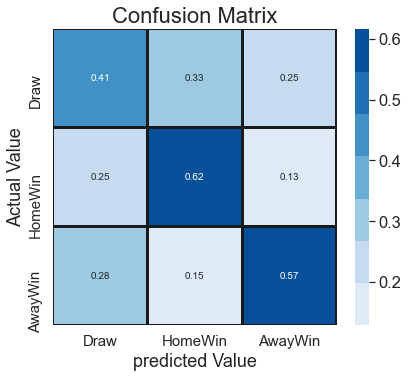

In [232]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### Random Forest model

In [233]:
#instantiate a pipeline with the steps
Random_forest = Pipeline(steps=[('classifier', RandomForestClassifier())])
Random_forest

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [235]:
cross_validate(Random_forest,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([1.79613614, 1.82536006, 1.83060098, 1.7238028 , 1.710675  ]),
 'score_time': array([0.0437839 , 0.04424024, 0.04300785, 0.04538321, 0.04469824]),
 'test_score': array([0.62283237, 0.63487476, 0.65655106, 0.72639692, 0.74807322]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [236]:
param = [{
    'classifier__criterion':['gini','entropy'],
    'classifier__max_features':['sqrt','log2'],
    'classifier__max_depth': [5,10,50],
    'classifier__min_samples_split':[10,20,100]}]

grid = GridSearchCV(estimator= Random_forest,
                    param_grid = param, scoring='accuracy')

In [237]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.748065,0.017563,0.020454,0.000156,gini,5,sqrt,10,"{'classifier__criterion': 'gini', 'classifier_...",0.530829,0.547688,0.565029,0.553468,0.564066,0.552216,0.012523,26
1,0.743587,0.013016,0.020402,0.000187,gini,5,sqrt,20,"{'classifier__criterion': 'gini', 'classifier_...",0.533237,0.548651,0.561657,0.552987,0.560212,0.551349,0.010226,28
2,0.739936,0.011312,0.020397,0.000144,gini,5,sqrt,100,"{'classifier__criterion': 'gini', 'classifier_...",0.539499,0.539981,0.558767,0.555877,0.559730,0.550771,0.009097,31
3,0.746265,0.016670,0.020965,0.001273,gini,5,log2,10,"{'classifier__criterion': 'gini', 'classifier_...",0.536609,0.538536,0.558767,0.552023,0.559249,0.549037,0.009722,35
4,0.747329,0.014034,0.020332,0.000160,gini,5,log2,20,"{'classifier__criterion': 'gini', 'classifier_...",0.540944,0.542871,0.566474,0.553950,0.565511,0.553950,0.010793,25
5,0.742390,0.013034,0.020317,0.000103,gini,5,log2,100,"{'classifier__criterion': 'gini', 'classifier_...",0.532274,0.544316,0.562139,0.553468,0.554432,0.549326,0.010230,34
6,1.249835,0.023160,0.028057,0.000133,gini,10,sqrt,10,"{'classifier__criterion': 'gini', 'classifier_...",0.567919,0.580925,0.599711,0.616089,0.620906,0.597110,0.020235,9
7,1.218523,0.016005,0.027105,0.000108,gini,10,sqrt,20,"{'classifier__criterion': 'gini', 'classifier_...",0.561175,0.571291,0.593449,0.608382,0.617534,0.590366,0.021392,13
8,1.078005,0.013964,0.024512,0.000340,gini,10,sqrt,100,"{'classifier__criterion': 'gini', 'classifier_...",0.542389,0.564547,0.573218,0.582852,0.583333,0.569268,0.015118,21
9,1.242259,0.016749,0.028010,0.000367,gini,10,log2,10,"{'classifier__criterion': 'gini', 'classifier_...",0.563102,0.578998,0.598748,0.622351,0.620424,0.596724,0.023096,10


In [297]:
output.best_params_

{'classifier__leaf_size': 20,
 'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 3,
 'classifier__weights': 'distance'}

In [298]:
#check the best score for the parameter
output.best_score_

0.7040462427745664

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 2.1094237467877998e-15
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3460
           1       1.00      1.00      1.00      3460
           2       1.00      1.00      1.00      3460

    accuracy                           1.00     10380
   macro avg       1.00      1.00      1.00     10380
weighted avg       1.00      1.00      1.00     10380

------------
Test Scores:
Accuracy Score: 0.44508670520231214
----
Log loss Score: 10.471940412916855
----
              precision    recall  f1-score   support

           0       0.24      0.32      0.27       441
           1       0.61      0.48      0.54       887
           2       0.46      0.49      0.47       575

    accuracy                           0.45      1903
   macro avg       0.44      0.43      0.43      1903
weighted avg       0.48      0.45      0.46      1903



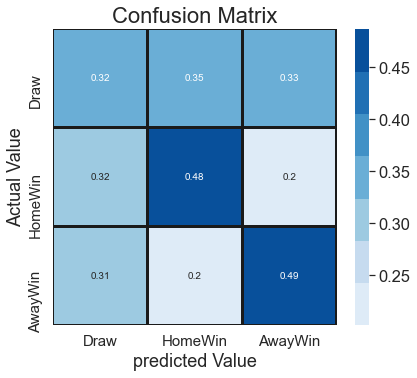

In [299]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### XGBoost model

In [241]:
#instantiate a pipeline with the steps
xgb_model= Pipeline(steps=[('pca',PCA()),
                           ('classifier', XGBClassifier(objective='multi:softmax'))])
xgb_model

Pipeline(steps=[('pca', PCA()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softmax', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                 

In [242]:
cross_validate(xgb_model,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([1.75735092, 1.79981899, 1.84662795, 1.73082304, 1.73078203]),
 'score_time': array([0.04158998, 0.04390597, 0.04414511, 0.04102802, 0.0407989 ]),
 'test_score': array([0.63631985, 0.63150289, 0.66473988, 0.72736031, 0.74759152]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [243]:
#set the parameters
param = [{
    'pca__n_components':[5,10],
    'classifier__gamma':[0.5,0.1],
    'classifier__max_depth': [10,20,50],
    'classifier__n_estimators':[20,60,100]}]

grid = GridSearchCV(estimator = xgb_model,
                    param_grid = param, scoring='accuracy')

In [244]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__gamma,param_classifier__max_depth,param_classifier__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.289627,0.005765,0.004044,0.000720,0.5,10,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.523121,0.531310,0.555877,0.588150,0.615125,0.562717,0.034625,36
1,0.463486,0.010082,0.004239,0.000687,0.5,10,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.577553,0.577071,0.618015,0.711946,0.704239,0.637765,0.059365,18
2,0.818524,0.033820,0.008174,0.001473,0.5,10,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.532274,0.517341,0.563102,0.617534,0.635838,0.573218,0.046446,34
3,1.354634,0.038329,0.008411,0.000265,0.5,10,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.595376,0.580925,0.637283,0.730732,0.729287,0.654721,0.064202,16
4,1.418057,0.095945,0.011342,0.001615,0.5,10,100,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.534682,0.519750,0.572254,0.619942,0.637283,0.576782,0.045976,33
5,2.310742,0.053350,0.010640,0.000626,0.5,10,100,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.596339,0.587669,0.638247,0.731214,0.730250,0.656744,0.062787,15
6,0.663710,0.027031,0.005763,0.000438,0.5,20,20,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.544316,0.553950,0.589114,0.643545,0.663776,0.598940,0.047535,30
7,0.984190,0.068883,0.006291,0.001020,0.5,20,20,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.593931,0.589595,0.643064,0.731696,0.750482,0.661753,0.067706,14
8,1.754775,0.045843,0.010658,0.001474,0.5,20,60,5,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.553468,0.549615,0.592967,0.643545,0.672929,0.602505,0.048861,28
9,2.847068,0.104172,0.012034,0.003091,0.5,20,60,10,"{'classifier__gamma': 0.5, 'classifier__max_de...",0.597784,0.587669,0.648844,0.741329,0.756744,0.666474,0.070698,11


In [245]:
output.best_params_

{'classifier__gamma': 0.1,
 'classifier__max_depth': 50,
 'classifier__n_estimators': 60,
 'pca__n_components': 10}

In [246]:
#check the best score for the parameter
output.best_score_

0.6884393063583815

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 0.023715951461937126
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3460
           1       1.00      1.00      1.00      3460
           2       1.00      1.00      1.00      3460

    accuracy                           1.00     10380
   macro avg       1.00      1.00      1.00     10380
weighted avg       1.00      1.00      1.00     10380

------------
Test Scores:
Accuracy Score: 0.55911718339464
----
Log loss Score: 1.1541449812756173
----
              precision    recall  f1-score   support

           0       0.34      0.29      0.31       441
           1       0.65      0.67      0.66       887
           2       0.56      0.59      0.58       575

    accuracy                           0.56      1903
   macro avg       0.52      0.52      0.52      1903
weighted avg       0.55      0.56      0.55      1903



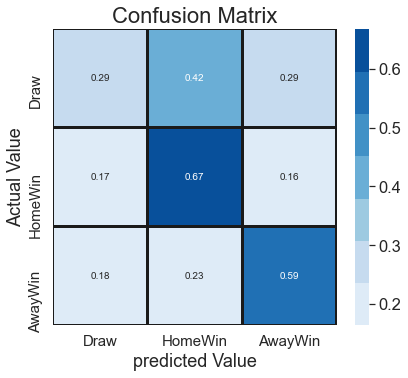

In [247]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### KNN Model

In [248]:
#instantiate the pipeline with the steps
knn_model = Pipeline(steps=[('classifier', KNeighborsClassifier())])
knn_model

Pipeline(steps=[('classifier', KNeighborsClassifier())])

In [250]:
#cross validate the model
cross_validate(knn_model,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([0.00584173, 0.00535393, 0.00725198, 0.0057888 , 0.00649285]),
 'score_time': array([0.11143517, 0.10615301, 0.10434079, 0.09821725, 0.10272098]),
 'test_score': array([0.55828516, 0.56117534, 0.57321773, 0.66136802, 0.67919075]),
 'train_score': array([0.75264933, 0.75289017, 0.74927746, 0.7232659 , 0.71062139])}

In [301]:
#set the n_neighbors
#set the metric to euclidean and minkowski
param = [{
    'classifier__leaf_size':[5,10,20,40,60],
    'classifier__n_neighbors': [3,5,10,20,50,],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','minkowski','manhattan']}]

grid = GridSearchCV(estimator = knn_model,
                    param_grid = param, scoring='accuracy')

In [302]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__leaf_size,param_classifier__metric,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007285,0.000380,0.115844,0.006460,5,euclidean,3,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.584297,0.587669,0.615607,0.693160,0.714836,0.639114,0.054514,61
1,0.007048,0.000800,0.069502,0.002133,5,euclidean,3,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.639210,0.638247,0.665222,0.776012,0.801541,0.704046,0.070321,1
2,0.006879,0.000497,0.133201,0.003310,5,euclidean,5,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.558285,0.561175,0.573218,0.661368,0.679191,0.606647,0.052500,96
3,0.006794,0.000421,0.087727,0.002511,5,euclidean,5,distance,"{'classifier__leaf_size': 5, 'classifier__metr...",0.634875,0.624759,0.644509,0.765896,0.792389,0.692486,0.071523,16
4,0.006880,0.000426,0.160332,0.002933,5,euclidean,10,uniform,"{'classifier__leaf_size': 5, 'classifier__metr...",0.546243,0.548170,0.567919,0.623796,0.633911,0.584008,0.037531,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.005849,0.000531,0.133333,0.002796,60,manhattan,10,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.610790,0.624277,0.636802,0.730732,0.766378,0.673796,0.062616,41
146,0.005626,0.000400,0.196190,0.005697,60,manhattan,20,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.513487,0.525048,0.551060,0.571773,0.579961,0.548266,0.025743,131
147,0.005615,0.000592,0.151768,0.003350,60,manhattan,20,distance,"{'classifier__leaf_size': 60, 'classifier__met...",0.588150,0.600193,0.625723,0.697495,0.728805,0.648073,0.055395,56
148,0.005567,0.000490,0.240566,0.003928,60,manhattan,50,uniform,"{'classifier__leaf_size': 60, 'classifier__met...",0.509152,0.528420,0.534682,0.526493,0.545279,0.528805,0.011812,146


In [303]:
#check the best parameter from the models
output.best_params_

{'classifier__leaf_size': 5,
 'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 3,
 'classifier__weights': 'distance'}

In [304]:
#check the best score for the best parameter
output.best_score_

0.7040462427745664

Training Scores:
Accuracy Score: 1.0
----
Log loss Score: 2.1094237467877998e-15
----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3460
           1       1.00      1.00      1.00      3460
           2       1.00      1.00      1.00      3460

    accuracy                           1.00     10380
   macro avg       1.00      1.00      1.00     10380
weighted avg       1.00      1.00      1.00     10380

------------
Test Scores:
Accuracy Score: 0.44508670520231214
----
Log loss Score: 10.471940412916855
----
              precision    recall  f1-score   support

           0       0.24      0.32      0.27       441
           1       0.61      0.48      0.54       887
           2       0.46      0.49      0.47       575

    accuracy                           0.45      1903
   macro avg       0.44      0.43      0.43      1903
weighted avg       0.48      0.45      0.46      1903



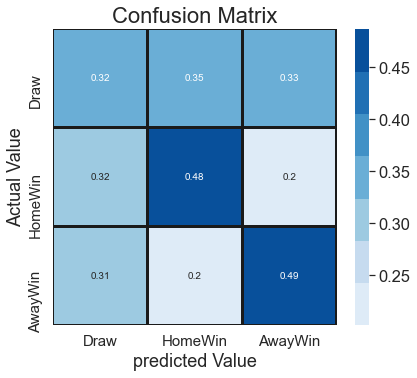

In [305]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### Naive Bayes

In [256]:
#instantiate the pipeline with the steps
naive_bayes = Pipeline(steps=[('classifier', GaussianNB())])
naive_bayes

Pipeline(steps=[('classifier', GaussianNB())])

In [257]:
#cross validate the model
cross_validate(naive_bayes,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([0.00269508, 0.00257206, 0.00253892, 0.00262666, 0.00270391]),
 'score_time': array([0.00104499, 0.00102687, 0.00100303, 0.00098515, 0.00099707]),
 'test_score': array([0.50818882, 0.51926782, 0.52552987, 0.52649326, 0.52842004]),
 'train_score': array([0.52540944, 0.52300096, 0.522158  , 0.51962909, 0.52023121])}

In [306]:
param = [{
    'classifier__var_smoothing':[2e-9,2e-10,2e-5,2e-20,1e-10,1e-9,2e-8,2e-1]}]

grid = GridSearchCV(estimator =naive_bayes,
                    param_grid = param, scoring='accuracy')

In [307]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002679,0.000234,0.001074,0.000118,2e-09,{'classifier__var_smoothing': 2e-09},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
1,0.002651,0.000109,0.000985,0.000014,2e-10,{'classifier__var_smoothing': 2e-10},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
2,0.002524,0.000055,0.000997,0.000024,2e-05,{'classifier__var_smoothing': 2e-05},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
3,0.002485,0.000041,0.000986,0.000018,2e-20,{'classifier__var_smoothing': 2e-20},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
4,0.002868,0.000221,0.001214,0.000334,1e-10,{'classifier__var_smoothing': 1e-10},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
5,0.002901,0.000225,0.001040,0.000077,1e-09,{'classifier__var_smoothing': 1e-09},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
6,0.002878,0.000448,0.001168,0.000389,2e-08,{'classifier__var_smoothing': 2e-08},0.508189,0.519268,0.525530,0.526493,0.528420,0.521580,0.007365,1
7,0.002587,0.000153,0.001038,0.000104,0.2,{'classifier__var_smoothing': 0.2},0.498555,0.505299,0.512524,0.503372,0.507225,0.505395,0.004584,8


In [308]:
#check the best parameter from the models
output.best_params_

{'classifier__var_smoothing': 2e-09}

In [309]:
#check the best score for the best parameter
output.best_score_

0.5215799614643546

Training Scores:
Accuracy Score: 0.5219653179190752
----
Log loss Score: 1.2512637310233932
----
              precision    recall  f1-score   support

           0       0.42      0.55      0.47      3460
           1       0.60      0.49      0.54      3460
           2       0.60      0.53      0.56      3460

    accuracy                           0.52     10380
   macro avg       0.54      0.52      0.53     10380
weighted avg       0.54      0.52      0.53     10380

------------
Test Scores:
Accuracy Score: 0.49448239621650025
----
Log loss Score: 1.2790853100247976
----
              precision    recall  f1-score   support

           0       0.28      0.50      0.36       441
           1       0.71      0.48      0.57       887
           2       0.58      0.52      0.54       575

    accuracy                           0.49      1903
   macro avg       0.52      0.50      0.49      1903
weighted avg       0.57      0.49      0.51      1903



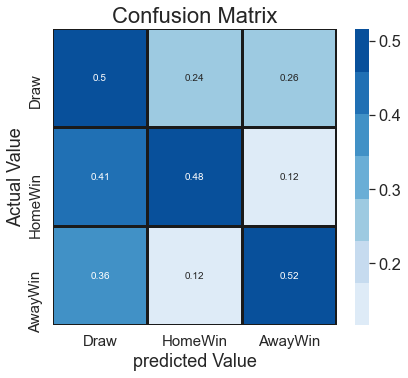

In [310]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### SVC model

In [267]:
#instantiate the pipeline with the steps
svc= Pipeline(steps=[('classifier', SVC(decision_function_shape='ovo',probability=True))])
svc

Pipeline(steps=[('classifier',
                 SVC(decision_function_shape='ovo', probability=True))])

In [268]:
cross_validate(svc,X_train_resampled, y_train_resampled, return_train_score=True)

{'fit_time': array([11.87480402, 12.00644565, 12.12930894, 11.99011517, 12.1790669 ]),
 'score_time': array([0.30366397, 0.29370022, 0.30743408, 0.28418899, 0.29076004]),
 'test_score': array([0.52793834, 0.54672447, 0.54913295, 0.54431599, 0.56310212]),
 'train_score': array([0.56635356, 0.5594894 , 0.56069364, 0.56237958, 0.5574422 ])}

In [319]:
param = [{
    'classifier__C':[0.5,0.2,1.0,1.5,],
    'classifier__gamma':['auto']}]

grid = GridSearchCV(estimator = svc,
                    param_grid = param, scoring='accuracy')

In [320]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.514907,0.185140,0.295611,0.004822,0.5,auto,"{'classifier__C': 0.5, 'classifier__gamma': 'a...",0.522640,0.546243,0.550578,0.546243,0.552023,0.543545,0.010704,3
1,11.983298,0.113742,0.303819,0.002724,0.2,auto,"{'classifier__C': 0.2, 'classifier__gamma': 'a...",0.524085,0.529865,0.539981,0.529383,0.536127,0.531888,0.005563,4
2,10.982937,0.036388,0.292320,0.003381,1,auto,"{'classifier__C': 1.0, 'classifier__gamma': 'a...",0.528902,0.543353,0.560212,0.544316,0.552987,0.545954,0.010516,2
3,10.782370,0.075604,0.288643,0.002464,1.5,auto,"{'classifier__C': 1.5, 'classifier__gamma': 'a...",0.534682,0.540944,0.559730,0.543353,0.554432,0.546628,0.009147,1


In [321]:
#check the best parameter from the models
output.best_params_

{'classifier__C': 1.5, 'classifier__gamma': 'auto'}

In [322]:
#check the best score for the best parameter
output.best_score_

0.5466281310211947

Training Scores:
Accuracy Score: 0.5497109826589596
----
Log loss Score: 0.9237559251948592
----
              precision    recall  f1-score   support

           0       0.44      0.50      0.47      3460
           1       0.61      0.56      0.58      3460
           2       0.62      0.59      0.61      3460

    accuracy                           0.55     10380
   macro avg       0.56      0.55      0.55     10380
weighted avg       0.56      0.55      0.55     10380

------------
Test Scores:
Accuracy Score: 0.558591697320021
----
Log loss Score: 0.9205308520778481
----
              precision    recall  f1-score   support

           0       0.33      0.50      0.40       441
           1       0.74      0.57      0.64       887
           2       0.62      0.58      0.60       575

    accuracy                           0.56      1903
   macro avg       0.56      0.55      0.55      1903
weighted avg       0.61      0.56      0.57      1903



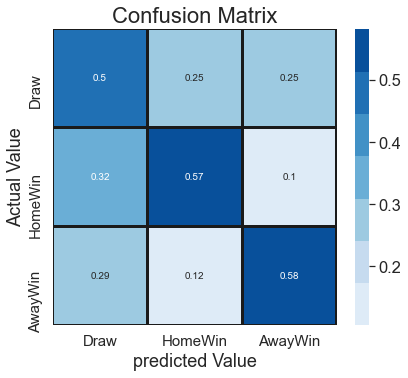

In [323]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

#### Catboost model

In [275]:
#instantiate the pipeline with the steps
cat_boost = Pipeline(steps=[('classifier', CatBoostClassifier(loss_function='MultiClass',classes_count=3))])
cat_boost

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fed7114fd90>)])

In [276]:
#cross validate the model
cross_validate(cat_boost,X_train_resampled, y_train_resampled, return_train_score=True)

Learning rate set to 0.088147
0:	learn: 1.0737554	total: 64.2ms	remaining: 1m 4s
1:	learn: 1.0516925	total: 68.9ms	remaining: 34.4s
2:	learn: 1.0352973	total: 73.4ms	remaining: 24.4s
3:	learn: 1.0211812	total: 78ms	remaining: 19.4s
4:	learn: 1.0084502	total: 82.6ms	remaining: 16.4s
5:	learn: 0.9966990	total: 87.2ms	remaining: 14.4s
6:	learn: 0.9865545	total: 91.9ms	remaining: 13s
7:	learn: 0.9768440	total: 96.5ms	remaining: 12s
8:	learn: 0.9694510	total: 101ms	remaining: 11.1s
9:	learn: 0.9625370	total: 106ms	remaining: 10.5s
10:	learn: 0.9555261	total: 110ms	remaining: 9.91s
11:	learn: 0.9499306	total: 115ms	remaining: 9.45s
12:	learn: 0.9445701	total: 119ms	remaining: 9.06s
13:	learn: 0.9403478	total: 124ms	remaining: 8.72s
14:	learn: 0.9359186	total: 129ms	remaining: 8.46s
15:	learn: 0.9319561	total: 133ms	remaining: 8.2s
16:	learn: 0.9282626	total: 138ms	remaining: 7.98s
17:	learn: 0.9252568	total: 142ms	remaining: 7.77s
18:	learn: 0.9220082	total: 147ms	remaining: 7.59s
19:	learn:

176:	learn: 0.7808966	total: 972ms	remaining: 4.52s
177:	learn: 0.7799664	total: 978ms	remaining: 4.52s
178:	learn: 0.7793519	total: 983ms	remaining: 4.51s
179:	learn: 0.7787820	total: 990ms	remaining: 4.51s
180:	learn: 0.7781824	total: 996ms	remaining: 4.51s
181:	learn: 0.7773575	total: 1s	remaining: 4.5s
182:	learn: 0.7768589	total: 1.01s	remaining: 4.51s
183:	learn: 0.7763205	total: 1.01s	remaining: 4.5s
184:	learn: 0.7754171	total: 1.02s	remaining: 4.5s
185:	learn: 0.7748018	total: 1.03s	remaining: 4.5s
186:	learn: 0.7741703	total: 1.03s	remaining: 4.49s
187:	learn: 0.7733652	total: 1.04s	remaining: 4.49s
188:	learn: 0.7727065	total: 1.04s	remaining: 4.48s
189:	learn: 0.7719444	total: 1.05s	remaining: 4.47s
190:	learn: 0.7711127	total: 1.05s	remaining: 4.47s
191:	learn: 0.7705454	total: 1.06s	remaining: 4.46s
192:	learn: 0.7698631	total: 1.06s	remaining: 4.46s
193:	learn: 0.7692728	total: 1.07s	remaining: 4.45s
194:	learn: 0.7683510	total: 1.08s	remaining: 4.44s
195:	learn: 0.76772

367:	learn: 0.6728763	total: 1.95s	remaining: 3.34s
368:	learn: 0.6724350	total: 1.95s	remaining: 3.34s
369:	learn: 0.6719270	total: 1.96s	remaining: 3.33s
370:	learn: 0.6715282	total: 1.96s	remaining: 3.33s
371:	learn: 0.6712283	total: 1.97s	remaining: 3.32s
372:	learn: 0.6705152	total: 1.97s	remaining: 3.32s
373:	learn: 0.6701619	total: 1.98s	remaining: 3.32s
374:	learn: 0.6696309	total: 1.99s	remaining: 3.31s
375:	learn: 0.6690328	total: 1.99s	remaining: 3.31s
376:	learn: 0.6684884	total: 2s	remaining: 3.3s
377:	learn: 0.6679402	total: 2s	remaining: 3.3s
378:	learn: 0.6675247	total: 2.01s	remaining: 3.29s
379:	learn: 0.6671144	total: 2.02s	remaining: 3.29s
380:	learn: 0.6667525	total: 2.02s	remaining: 3.29s
381:	learn: 0.6661719	total: 2.03s	remaining: 3.28s
382:	learn: 0.6659172	total: 2.03s	remaining: 3.28s
383:	learn: 0.6656274	total: 2.04s	remaining: 3.27s
384:	learn: 0.6651898	total: 2.04s	remaining: 3.27s
385:	learn: 0.6648527	total: 2.05s	remaining: 3.26s
386:	learn: 0.664241

552:	learn: 0.5939954	total: 2.92s	remaining: 2.36s
553:	learn: 0.5938592	total: 2.93s	remaining: 2.36s
554:	learn: 0.5935504	total: 2.94s	remaining: 2.35s
555:	learn: 0.5932283	total: 2.94s	remaining: 2.35s
556:	learn: 0.5929300	total: 2.94s	remaining: 2.34s
557:	learn: 0.5924641	total: 2.95s	remaining: 2.34s
558:	learn: 0.5919447	total: 2.95s	remaining: 2.33s
559:	learn: 0.5913060	total: 2.96s	remaining: 2.33s
560:	learn: 0.5909864	total: 2.96s	remaining: 2.32s
561:	learn: 0.5904817	total: 2.97s	remaining: 2.31s
562:	learn: 0.5902235	total: 2.97s	remaining: 2.31s
563:	learn: 0.5898256	total: 2.98s	remaining: 2.3s
564:	learn: 0.5895336	total: 2.98s	remaining: 2.3s
565:	learn: 0.5892047	total: 2.99s	remaining: 2.29s
566:	learn: 0.5888786	total: 2.99s	remaining: 2.29s
567:	learn: 0.5885136	total: 3s	remaining: 2.28s
568:	learn: 0.5880967	total: 3s	remaining: 2.27s
569:	learn: 0.5877837	total: 3.01s	remaining: 2.27s
570:	learn: 0.5875176	total: 3.01s	remaining: 2.26s
571:	learn: 0.586946

750:	learn: 0.5257486	total: 3.9s	remaining: 1.29s
751:	learn: 0.5254430	total: 3.91s	remaining: 1.29s
752:	learn: 0.5251496	total: 3.91s	remaining: 1.28s
753:	learn: 0.5248289	total: 3.92s	remaining: 1.28s
754:	learn: 0.5245818	total: 3.92s	remaining: 1.27s
755:	learn: 0.5242684	total: 3.93s	remaining: 1.27s
756:	learn: 0.5241080	total: 3.93s	remaining: 1.26s
757:	learn: 0.5238512	total: 3.94s	remaining: 1.26s
758:	learn: 0.5235291	total: 3.94s	remaining: 1.25s
759:	learn: 0.5233053	total: 3.95s	remaining: 1.25s
760:	learn: 0.5229393	total: 3.95s	remaining: 1.24s
761:	learn: 0.5226168	total: 3.96s	remaining: 1.24s
762:	learn: 0.5225113	total: 3.96s	remaining: 1.23s
763:	learn: 0.5222530	total: 3.97s	remaining: 1.23s
764:	learn: 0.5219892	total: 3.97s	remaining: 1.22s
765:	learn: 0.5217550	total: 3.98s	remaining: 1.22s
766:	learn: 0.5214533	total: 3.98s	remaining: 1.21s
767:	learn: 0.5211672	total: 3.99s	remaining: 1.2s
768:	learn: 0.5209188	total: 3.99s	remaining: 1.2s
769:	learn: 0.5

911:	learn: 0.4791629	total: 4.68s	remaining: 451ms
912:	learn: 0.4789789	total: 4.68s	remaining: 446ms
913:	learn: 0.4787040	total: 4.69s	remaining: 441ms
914:	learn: 0.4783897	total: 4.69s	remaining: 436ms
915:	learn: 0.4781650	total: 4.7s	remaining: 431ms
916:	learn: 0.4777662	total: 4.71s	remaining: 426ms
917:	learn: 0.4775458	total: 4.71s	remaining: 421ms
918:	learn: 0.4772711	total: 4.71s	remaining: 416ms
919:	learn: 0.4770856	total: 4.72s	remaining: 410ms
920:	learn: 0.4768786	total: 4.72s	remaining: 405ms
921:	learn: 0.4766066	total: 4.73s	remaining: 400ms
922:	learn: 0.4761539	total: 4.73s	remaining: 395ms
923:	learn: 0.4757522	total: 4.74s	remaining: 390ms
924:	learn: 0.4753339	total: 4.74s	remaining: 385ms
925:	learn: 0.4748813	total: 4.75s	remaining: 379ms
926:	learn: 0.4745885	total: 4.75s	remaining: 374ms
927:	learn: 0.4743815	total: 4.76s	remaining: 369ms
928:	learn: 0.4741847	total: 4.76s	remaining: 364ms
929:	learn: 0.4740180	total: 4.77s	remaining: 359ms
930:	learn: 0

78:	learn: 0.8593918	total: 395ms	remaining: 4.6s
79:	learn: 0.8585298	total: 400ms	remaining: 4.59s
80:	learn: 0.8578359	total: 405ms	remaining: 4.59s
81:	learn: 0.8568499	total: 410ms	remaining: 4.59s
82:	learn: 0.8562487	total: 415ms	remaining: 4.59s
83:	learn: 0.8552519	total: 420ms	remaining: 4.58s
84:	learn: 0.8544583	total: 425ms	remaining: 4.57s
85:	learn: 0.8538739	total: 430ms	remaining: 4.57s
86:	learn: 0.8530842	total: 434ms	remaining: 4.56s
87:	learn: 0.8525533	total: 439ms	remaining: 4.55s
88:	learn: 0.8519874	total: 444ms	remaining: 4.54s
89:	learn: 0.8512516	total: 448ms	remaining: 4.53s
90:	learn: 0.8506516	total: 453ms	remaining: 4.52s
91:	learn: 0.8495397	total: 458ms	remaining: 4.51s
92:	learn: 0.8488752	total: 462ms	remaining: 4.51s
93:	learn: 0.8482911	total: 467ms	remaining: 4.5s
94:	learn: 0.8475376	total: 472ms	remaining: 4.49s
95:	learn: 0.8468425	total: 476ms	remaining: 4.49s
96:	learn: 0.8460259	total: 481ms	remaining: 4.48s
97:	learn: 0.8454592	total: 486ms

237:	learn: 0.7515076	total: 1.17s	remaining: 3.76s
238:	learn: 0.7506887	total: 1.18s	remaining: 3.75s
239:	learn: 0.7500978	total: 1.18s	remaining: 3.75s
240:	learn: 0.7493128	total: 1.19s	remaining: 3.75s
241:	learn: 0.7487502	total: 1.19s	remaining: 3.74s
242:	learn: 0.7478934	total: 1.2s	remaining: 3.74s
243:	learn: 0.7469191	total: 1.21s	remaining: 3.73s
244:	learn: 0.7465837	total: 1.21s	remaining: 3.73s
245:	learn: 0.7458299	total: 1.21s	remaining: 3.72s
246:	learn: 0.7452091	total: 1.22s	remaining: 3.71s
247:	learn: 0.7447119	total: 1.22s	remaining: 3.71s
248:	learn: 0.7440391	total: 1.23s	remaining: 3.7s
249:	learn: 0.7434228	total: 1.23s	remaining: 3.7s
250:	learn: 0.7426571	total: 1.24s	remaining: 3.69s
251:	learn: 0.7418782	total: 1.24s	remaining: 3.68s
252:	learn: 0.7411555	total: 1.25s	remaining: 3.68s
253:	learn: 0.7403429	total: 1.25s	remaining: 3.67s
254:	learn: 0.7397475	total: 1.25s	remaining: 3.67s
255:	learn: 0.7394049	total: 1.26s	remaining: 3.66s
256:	learn: 0.7

433:	learn: 0.6512168	total: 2.15s	remaining: 2.81s
434:	learn: 0.6508836	total: 2.16s	remaining: 2.8s
435:	learn: 0.6505135	total: 2.16s	remaining: 2.8s
436:	learn: 0.6500916	total: 2.17s	remaining: 2.79s
437:	learn: 0.6498531	total: 2.17s	remaining: 2.79s
438:	learn: 0.6495826	total: 2.18s	remaining: 2.79s
439:	learn: 0.6490718	total: 2.18s	remaining: 2.78s
440:	learn: 0.6488158	total: 2.19s	remaining: 2.77s
441:	learn: 0.6484400	total: 2.19s	remaining: 2.77s
442:	learn: 0.6478412	total: 2.2s	remaining: 2.77s
443:	learn: 0.6475579	total: 2.2s	remaining: 2.76s
444:	learn: 0.6471103	total: 2.21s	remaining: 2.75s
445:	learn: 0.6465509	total: 2.21s	remaining: 2.75s
446:	learn: 0.6462707	total: 2.22s	remaining: 2.75s
447:	learn: 0.6458619	total: 2.22s	remaining: 2.74s
448:	learn: 0.6454992	total: 2.23s	remaining: 2.73s
449:	learn: 0.6450624	total: 2.23s	remaining: 2.73s
450:	learn: 0.6447916	total: 2.24s	remaining: 2.72s
451:	learn: 0.6442693	total: 2.24s	remaining: 2.72s
452:	learn: 0.64

598:	learn: 0.5866806	total: 2.94s	remaining: 1.97s
599:	learn: 0.5863536	total: 2.94s	remaining: 1.96s
600:	learn: 0.5860804	total: 2.95s	remaining: 1.96s
601:	learn: 0.5859164	total: 2.96s	remaining: 1.95s
602:	learn: 0.5853882	total: 2.96s	remaining: 1.95s
603:	learn: 0.5849920	total: 2.97s	remaining: 1.94s
604:	learn: 0.5845822	total: 2.97s	remaining: 1.94s
605:	learn: 0.5842891	total: 2.98s	remaining: 1.93s
606:	learn: 0.5837995	total: 2.98s	remaining: 1.93s
607:	learn: 0.5832876	total: 2.98s	remaining: 1.92s
608:	learn: 0.5829601	total: 2.99s	remaining: 1.92s
609:	learn: 0.5825345	total: 2.99s	remaining: 1.91s
610:	learn: 0.5822327	total: 3s	remaining: 1.91s
611:	learn: 0.5819349	total: 3s	remaining: 1.9s
612:	learn: 0.5816344	total: 3.01s	remaining: 1.9s
613:	learn: 0.5812862	total: 3.01s	remaining: 1.89s
614:	learn: 0.5808963	total: 3.02s	remaining: 1.89s
615:	learn: 0.5805885	total: 3.02s	remaining: 1.88s
616:	learn: 0.5800594	total: 3.03s	remaining: 1.88s
617:	learn: 0.579664

763:	learn: 0.5321987	total: 3.72s	remaining: 1.15s
764:	learn: 0.5318448	total: 3.73s	remaining: 1.15s
765:	learn: 0.5315226	total: 3.73s	remaining: 1.14s
766:	learn: 0.5310655	total: 3.74s	remaining: 1.14s
767:	learn: 0.5308778	total: 3.75s	remaining: 1.13s
768:	learn: 0.5306469	total: 3.75s	remaining: 1.13s
769:	learn: 0.5303970	total: 3.75s	remaining: 1.12s
770:	learn: 0.5299748	total: 3.76s	remaining: 1.12s
771:	learn: 0.5295884	total: 3.77s	remaining: 1.11s
772:	learn: 0.5293509	total: 3.77s	remaining: 1.11s
773:	learn: 0.5289599	total: 3.77s	remaining: 1.1s
774:	learn: 0.5287430	total: 3.78s	remaining: 1.1s
775:	learn: 0.5282175	total: 3.79s	remaining: 1.09s
776:	learn: 0.5278399	total: 3.79s	remaining: 1.09s
777:	learn: 0.5274626	total: 3.79s	remaining: 1.08s
778:	learn: 0.5272215	total: 3.8s	remaining: 1.08s
779:	learn: 0.5269786	total: 3.8s	remaining: 1.07s
780:	learn: 0.5267286	total: 3.81s	remaining: 1.07s
781:	learn: 0.5264496	total: 3.81s	remaining: 1.06s
782:	learn: 0.52

926:	learn: 0.4835900	total: 4.51s	remaining: 355ms
927:	learn: 0.4831307	total: 4.51s	remaining: 350ms
928:	learn: 0.4828662	total: 4.52s	remaining: 345ms
929:	learn: 0.4825239	total: 4.52s	remaining: 340ms
930:	learn: 0.4822436	total: 4.53s	remaining: 336ms
931:	learn: 0.4819648	total: 4.53s	remaining: 331ms
932:	learn: 0.4817091	total: 4.54s	remaining: 326ms
933:	learn: 0.4814435	total: 4.54s	remaining: 321ms
934:	learn: 0.4812932	total: 4.55s	remaining: 316ms
935:	learn: 0.4810283	total: 4.55s	remaining: 311ms
936:	learn: 0.4807144	total: 4.55s	remaining: 306ms
937:	learn: 0.4805996	total: 4.56s	remaining: 301ms
938:	learn: 0.4804899	total: 4.56s	remaining: 297ms
939:	learn: 0.4802408	total: 4.57s	remaining: 292ms
940:	learn: 0.4799718	total: 4.57s	remaining: 287ms
941:	learn: 0.4797461	total: 4.58s	remaining: 282ms
942:	learn: 0.4794951	total: 4.58s	remaining: 277ms
943:	learn: 0.4792182	total: 4.59s	remaining: 272ms
944:	learn: 0.4790153	total: 4.59s	remaining: 267ms
945:	learn: 

117:	learn: 0.8326339	total: 669ms	remaining: 5s
118:	learn: 0.8317648	total: 676ms	remaining: 5s
119:	learn: 0.8310462	total: 682ms	remaining: 5s
120:	learn: 0.8305731	total: 688ms	remaining: 5s
121:	learn: 0.8300040	total: 693ms	remaining: 4.99s
122:	learn: 0.8290385	total: 698ms	remaining: 4.98s
123:	learn: 0.8282411	total: 704ms	remaining: 4.97s
124:	learn: 0.8272505	total: 710ms	remaining: 4.97s
125:	learn: 0.8267741	total: 714ms	remaining: 4.95s
126:	learn: 0.8262055	total: 720ms	remaining: 4.95s
127:	learn: 0.8254233	total: 726ms	remaining: 4.95s
128:	learn: 0.8245433	total: 740ms	remaining: 5s
129:	learn: 0.8236372	total: 754ms	remaining: 5.04s
130:	learn: 0.8227959	total: 762ms	remaining: 5.06s
131:	learn: 0.8220456	total: 771ms	remaining: 5.07s
132:	learn: 0.8214171	total: 779ms	remaining: 5.08s
133:	learn: 0.8206701	total: 785ms	remaining: 5.07s
134:	learn: 0.8199723	total: 791ms	remaining: 5.07s
135:	learn: 0.8194524	total: 797ms	remaining: 5.07s
136:	learn: 0.8184969	total

302:	learn: 0.7205394	total: 1.64s	remaining: 3.78s
303:	learn: 0.7202451	total: 1.65s	remaining: 3.77s
304:	learn: 0.7199051	total: 1.65s	remaining: 3.77s
305:	learn: 0.7194164	total: 1.66s	remaining: 3.76s
306:	learn: 0.7188921	total: 1.66s	remaining: 3.75s
307:	learn: 0.7183195	total: 1.67s	remaining: 3.75s
308:	learn: 0.7179415	total: 1.67s	remaining: 3.74s
309:	learn: 0.7173107	total: 1.68s	remaining: 3.73s
310:	learn: 0.7166886	total: 1.68s	remaining: 3.73s
311:	learn: 0.7161950	total: 1.69s	remaining: 3.72s
312:	learn: 0.7157803	total: 1.69s	remaining: 3.71s
313:	learn: 0.7153071	total: 1.7s	remaining: 3.71s
314:	learn: 0.7149590	total: 1.7s	remaining: 3.7s
315:	learn: 0.7144927	total: 1.71s	remaining: 3.69s
316:	learn: 0.7141577	total: 1.71s	remaining: 3.69s
317:	learn: 0.7136808	total: 1.72s	remaining: 3.68s
318:	learn: 0.7128419	total: 1.72s	remaining: 3.67s
319:	learn: 0.7122223	total: 1.73s	remaining: 3.67s
320:	learn: 0.7113941	total: 1.73s	remaining: 3.66s
321:	learn: 0.7

466:	learn: 0.6427871	total: 2.42s	remaining: 2.77s
467:	learn: 0.6424278	total: 2.43s	remaining: 2.76s
468:	learn: 0.6416556	total: 2.43s	remaining: 2.76s
469:	learn: 0.6411679	total: 2.44s	remaining: 2.75s
470:	learn: 0.6408535	total: 2.44s	remaining: 2.74s
471:	learn: 0.6404798	total: 2.45s	remaining: 2.74s
472:	learn: 0.6399802	total: 2.45s	remaining: 2.73s
473:	learn: 0.6397538	total: 2.46s	remaining: 2.73s
474:	learn: 0.6393048	total: 2.46s	remaining: 2.72s
475:	learn: 0.6390074	total: 2.47s	remaining: 2.72s
476:	learn: 0.6385639	total: 2.47s	remaining: 2.71s
477:	learn: 0.6382133	total: 2.48s	remaining: 2.71s
478:	learn: 0.6378628	total: 2.48s	remaining: 2.7s
479:	learn: 0.6375153	total: 2.49s	remaining: 2.7s
480:	learn: 0.6371742	total: 2.5s	remaining: 2.69s
481:	learn: 0.6367760	total: 2.5s	remaining: 2.69s
482:	learn: 0.6364145	total: 2.51s	remaining: 2.69s
483:	learn: 0.6360126	total: 2.52s	remaining: 2.68s
484:	learn: 0.6356490	total: 2.52s	remaining: 2.67s
485:	learn: 0.63

652:	learn: 0.5739083	total: 3.4s	remaining: 1.81s
653:	learn: 0.5734944	total: 3.41s	remaining: 1.8s
654:	learn: 0.5733131	total: 3.42s	remaining: 1.8s
655:	learn: 0.5730060	total: 3.42s	remaining: 1.79s
656:	learn: 0.5726840	total: 3.42s	remaining: 1.79s
657:	learn: 0.5724961	total: 3.43s	remaining: 1.78s
658:	learn: 0.5719755	total: 3.44s	remaining: 1.78s
659:	learn: 0.5715742	total: 3.44s	remaining: 1.77s
660:	learn: 0.5713208	total: 3.45s	remaining: 1.77s
661:	learn: 0.5710080	total: 3.45s	remaining: 1.76s
662:	learn: 0.5707875	total: 3.46s	remaining: 1.76s
663:	learn: 0.5705276	total: 3.46s	remaining: 1.75s
664:	learn: 0.5701735	total: 3.47s	remaining: 1.75s
665:	learn: 0.5697452	total: 3.48s	remaining: 1.74s
666:	learn: 0.5694626	total: 3.48s	remaining: 1.74s
667:	learn: 0.5689804	total: 3.49s	remaining: 1.73s
668:	learn: 0.5687321	total: 3.49s	remaining: 1.73s
669:	learn: 0.5684472	total: 3.5s	remaining: 1.72s
670:	learn: 0.5681480	total: 3.5s	remaining: 1.72s
671:	learn: 0.567

834:	learn: 0.5182383	total: 4.38s	remaining: 867ms
835:	learn: 0.5180032	total: 4.39s	remaining: 861ms
836:	learn: 0.5176103	total: 4.39s	remaining: 856ms
837:	learn: 0.5172689	total: 4.4s	remaining: 851ms
838:	learn: 0.5168705	total: 4.4s	remaining: 845ms
839:	learn: 0.5165381	total: 4.41s	remaining: 840ms
840:	learn: 0.5160252	total: 4.41s	remaining: 834ms
841:	learn: 0.5157742	total: 4.42s	remaining: 829ms
842:	learn: 0.5154833	total: 4.42s	remaining: 824ms
843:	learn: 0.5150429	total: 4.43s	remaining: 819ms
844:	learn: 0.5147179	total: 4.43s	remaining: 813ms
845:	learn: 0.5145284	total: 4.44s	remaining: 808ms
846:	learn: 0.5142672	total: 4.44s	remaining: 803ms
847:	learn: 0.5138819	total: 4.45s	remaining: 797ms
848:	learn: 0.5136065	total: 4.45s	remaining: 792ms
849:	learn: 0.5133345	total: 4.46s	remaining: 787ms
850:	learn: 0.5131236	total: 4.46s	remaining: 781ms
851:	learn: 0.5128995	total: 4.47s	remaining: 776ms
852:	learn: 0.5127551	total: 4.47s	remaining: 771ms
853:	learn: 0.

1:	learn: 1.0532638	total: 12.7ms	remaining: 6.33s
2:	learn: 1.0367378	total: 17.6ms	remaining: 5.85s
3:	learn: 1.0223548	total: 22.6ms	remaining: 5.63s
4:	learn: 1.0093630	total: 27.7ms	remaining: 5.52s
5:	learn: 0.9980631	total: 32.4ms	remaining: 5.37s
6:	learn: 0.9892818	total: 37.2ms	remaining: 5.27s
7:	learn: 0.9806270	total: 42ms	remaining: 5.21s
8:	learn: 0.9734518	total: 47ms	remaining: 5.17s
9:	learn: 0.9668094	total: 51.8ms	remaining: 5.13s
10:	learn: 0.9603182	total: 56.5ms	remaining: 5.08s
11:	learn: 0.9554775	total: 61.4ms	remaining: 5.05s
12:	learn: 0.9503538	total: 66.4ms	remaining: 5.04s
13:	learn: 0.9470112	total: 71.1ms	remaining: 5s
14:	learn: 0.9429632	total: 76ms	remaining: 4.99s
15:	learn: 0.9390421	total: 80.8ms	remaining: 4.97s
16:	learn: 0.9359400	total: 85.7ms	remaining: 4.96s
17:	learn: 0.9330496	total: 90.6ms	remaining: 4.94s
18:	learn: 0.9305857	total: 95.1ms	remaining: 4.91s
19:	learn: 0.9278283	total: 100ms	remaining: 4.9s
20:	learn: 0.9254614	total: 105m

167:	learn: 0.8106792	total: 796ms	remaining: 3.94s
168:	learn: 0.8097648	total: 801ms	remaining: 3.94s
169:	learn: 0.8092649	total: 805ms	remaining: 3.93s
170:	learn: 0.8087970	total: 810ms	remaining: 3.92s
171:	learn: 0.8083008	total: 814ms	remaining: 3.92s
172:	learn: 0.8078947	total: 819ms	remaining: 3.91s
173:	learn: 0.8069567	total: 824ms	remaining: 3.91s
174:	learn: 0.8064364	total: 828ms	remaining: 3.9s
175:	learn: 0.8060399	total: 833ms	remaining: 3.9s
176:	learn: 0.8054378	total: 838ms	remaining: 3.9s
177:	learn: 0.8046573	total: 842ms	remaining: 3.89s
178:	learn: 0.8041913	total: 847ms	remaining: 3.88s
179:	learn: 0.8034853	total: 852ms	remaining: 3.88s
180:	learn: 0.8031407	total: 856ms	remaining: 3.87s
181:	learn: 0.8026325	total: 861ms	remaining: 3.87s
182:	learn: 0.8019726	total: 865ms	remaining: 3.86s
183:	learn: 0.8015591	total: 870ms	remaining: 3.86s
184:	learn: 0.8005661	total: 875ms	remaining: 3.85s
185:	learn: 0.7996506	total: 879ms	remaining: 3.85s
186:	learn: 0.7

327:	learn: 0.7265163	total: 1.57s	remaining: 3.22s
328:	learn: 0.7259317	total: 1.58s	remaining: 3.22s
329:	learn: 0.7255048	total: 1.58s	remaining: 3.21s
330:	learn: 0.7248543	total: 1.59s	remaining: 3.21s
331:	learn: 0.7244334	total: 1.59s	remaining: 3.2s
332:	learn: 0.7240439	total: 1.6s	remaining: 3.2s
333:	learn: 0.7232924	total: 1.6s	remaining: 3.2s
334:	learn: 0.7228933	total: 1.61s	remaining: 3.2s
335:	learn: 0.7225539	total: 1.62s	remaining: 3.19s
336:	learn: 0.7218977	total: 1.62s	remaining: 3.19s
337:	learn: 0.7216693	total: 1.63s	remaining: 3.19s
338:	learn: 0.7214090	total: 1.63s	remaining: 3.19s
339:	learn: 0.7208876	total: 1.64s	remaining: 3.18s
340:	learn: 0.7203540	total: 1.64s	remaining: 3.18s
341:	learn: 0.7198979	total: 1.65s	remaining: 3.17s
342:	learn: 0.7195892	total: 1.65s	remaining: 3.17s
343:	learn: 0.7190117	total: 1.66s	remaining: 3.17s
344:	learn: 0.7185720	total: 1.67s	remaining: 3.16s
345:	learn: 0.7178169	total: 1.67s	remaining: 3.16s
346:	learn: 0.7175

520:	learn: 0.6453820	total: 2.55s	remaining: 2.34s
521:	learn: 0.6449200	total: 2.55s	remaining: 2.34s
522:	learn: 0.6446767	total: 2.56s	remaining: 2.33s
523:	learn: 0.6444585	total: 2.56s	remaining: 2.33s
524:	learn: 0.6438650	total: 2.57s	remaining: 2.33s
525:	learn: 0.6435633	total: 2.58s	remaining: 2.32s
526:	learn: 0.6430782	total: 2.58s	remaining: 2.32s
527:	learn: 0.6427055	total: 2.58s	remaining: 2.31s
528:	learn: 0.6423556	total: 2.59s	remaining: 2.31s
529:	learn: 0.6419647	total: 2.6s	remaining: 2.3s
530:	learn: 0.6414031	total: 2.6s	remaining: 2.3s
531:	learn: 0.6410755	total: 2.61s	remaining: 2.29s
532:	learn: 0.6408800	total: 2.61s	remaining: 2.29s
533:	learn: 0.6404950	total: 2.62s	remaining: 2.28s
534:	learn: 0.6400660	total: 2.62s	remaining: 2.28s
535:	learn: 0.6397588	total: 2.63s	remaining: 2.27s
536:	learn: 0.6394103	total: 2.63s	remaining: 2.27s
537:	learn: 0.6389264	total: 2.64s	remaining: 2.27s
538:	learn: 0.6386599	total: 2.64s	remaining: 2.26s
539:	learn: 0.63

679:	learn: 0.5899602	total: 3.35s	remaining: 1.58s
680:	learn: 0.5897628	total: 3.36s	remaining: 1.57s
681:	learn: 0.5894767	total: 3.37s	remaining: 1.57s
682:	learn: 0.5891023	total: 3.37s	remaining: 1.56s
683:	learn: 0.5888474	total: 3.38s	remaining: 1.56s
684:	learn: 0.5885760	total: 3.38s	remaining: 1.55s
685:	learn: 0.5881398	total: 3.39s	remaining: 1.55s
686:	learn: 0.5879072	total: 3.39s	remaining: 1.54s
687:	learn: 0.5875722	total: 3.4s	remaining: 1.54s
688:	learn: 0.5871322	total: 3.4s	remaining: 1.53s
689:	learn: 0.5868967	total: 3.4s	remaining: 1.53s
690:	learn: 0.5865733	total: 3.41s	remaining: 1.52s
691:	learn: 0.5860878	total: 3.42s	remaining: 1.52s
692:	learn: 0.5857750	total: 3.42s	remaining: 1.51s
693:	learn: 0.5855763	total: 3.42s	remaining: 1.51s
694:	learn: 0.5854566	total: 3.43s	remaining: 1.5s
695:	learn: 0.5851331	total: 3.43s	remaining: 1.5s
696:	learn: 0.5848020	total: 3.44s	remaining: 1.5s
697:	learn: 0.5846075	total: 3.44s	remaining: 1.49s
698:	learn: 0.5844

869:	learn: 0.5340978	total: 4.33s	remaining: 648ms
870:	learn: 0.5337867	total: 4.34s	remaining: 643ms
871:	learn: 0.5336105	total: 4.34s	remaining: 638ms
872:	learn: 0.5332476	total: 4.35s	remaining: 633ms
873:	learn: 0.5329368	total: 4.36s	remaining: 628ms
874:	learn: 0.5326471	total: 4.36s	remaining: 623ms
875:	learn: 0.5324594	total: 4.37s	remaining: 618ms
876:	learn: 0.5322170	total: 4.37s	remaining: 613ms
877:	learn: 0.5318255	total: 4.38s	remaining: 609ms
878:	learn: 0.5315473	total: 4.38s	remaining: 604ms
879:	learn: 0.5312404	total: 4.39s	remaining: 599ms
880:	learn: 0.5308583	total: 4.4s	remaining: 594ms
881:	learn: 0.5306246	total: 4.4s	remaining: 589ms
882:	learn: 0.5303921	total: 4.41s	remaining: 584ms
883:	learn: 0.5302310	total: 4.41s	remaining: 579ms
884:	learn: 0.5300842	total: 4.42s	remaining: 574ms
885:	learn: 0.5299075	total: 4.42s	remaining: 569ms
886:	learn: 0.5295620	total: 4.43s	remaining: 564ms
887:	learn: 0.5293759	total: 4.43s	remaining: 559ms
888:	learn: 0.

47:	learn: 0.8904129	total: 229ms	remaining: 4.54s
48:	learn: 0.8894138	total: 233ms	remaining: 4.53s
49:	learn: 0.8886942	total: 238ms	remaining: 4.52s
50:	learn: 0.8880298	total: 243ms	remaining: 4.51s
51:	learn: 0.8875191	total: 247ms	remaining: 4.51s
52:	learn: 0.8864143	total: 252ms	remaining: 4.5s
53:	learn: 0.8855898	total: 256ms	remaining: 4.49s
54:	learn: 0.8848623	total: 261ms	remaining: 4.48s
55:	learn: 0.8840571	total: 266ms	remaining: 4.48s
56:	learn: 0.8828981	total: 270ms	remaining: 4.47s
57:	learn: 0.8818644	total: 275ms	remaining: 4.47s
58:	learn: 0.8809003	total: 279ms	remaining: 4.46s
59:	learn: 0.8801383	total: 284ms	remaining: 4.45s
60:	learn: 0.8796594	total: 289ms	remaining: 4.44s
61:	learn: 0.8790020	total: 293ms	remaining: 4.44s
62:	learn: 0.8782873	total: 298ms	remaining: 4.43s
63:	learn: 0.8769933	total: 302ms	remaining: 4.42s
64:	learn: 0.8761513	total: 307ms	remaining: 4.42s
65:	learn: 0.8754057	total: 312ms	remaining: 4.41s
66:	learn: 0.8747510	total: 316m

216:	learn: 0.7845671	total: 1s	remaining: 3.62s
217:	learn: 0.7838986	total: 1.01s	remaining: 3.62s
218:	learn: 0.7833095	total: 1.01s	remaining: 3.61s
219:	learn: 0.7827860	total: 1.02s	remaining: 3.6s
220:	learn: 0.7824344	total: 1.02s	remaining: 3.6s
221:	learn: 0.7819403	total: 1.03s	remaining: 3.6s
222:	learn: 0.7815385	total: 1.03s	remaining: 3.59s
223:	learn: 0.7809326	total: 1.03s	remaining: 3.59s
224:	learn: 0.7804446	total: 1.04s	remaining: 3.58s
225:	learn: 0.7800159	total: 1.04s	remaining: 3.58s
226:	learn: 0.7797206	total: 1.05s	remaining: 3.57s
227:	learn: 0.7793786	total: 1.05s	remaining: 3.57s
228:	learn: 0.7790052	total: 1.06s	remaining: 3.56s
229:	learn: 0.7784323	total: 1.06s	remaining: 3.56s
230:	learn: 0.7777667	total: 1.07s	remaining: 3.55s
231:	learn: 0.7772164	total: 1.07s	remaining: 3.55s
232:	learn: 0.7768985	total: 1.08s	remaining: 3.54s
233:	learn: 0.7762902	total: 1.08s	remaining: 3.54s
234:	learn: 0.7756339	total: 1.08s	remaining: 3.53s
235:	learn: 0.7752

380:	learn: 0.7071065	total: 1.78s	remaining: 2.9s
381:	learn: 0.7066453	total: 1.79s	remaining: 2.89s
382:	learn: 0.7060817	total: 1.79s	remaining: 2.89s
383:	learn: 0.7054105	total: 1.8s	remaining: 2.88s
384:	learn: 0.7051086	total: 1.8s	remaining: 2.88s
385:	learn: 0.7047188	total: 1.8s	remaining: 2.87s
386:	learn: 0.7043799	total: 1.81s	remaining: 2.87s
387:	learn: 0.7041445	total: 1.81s	remaining: 2.86s
388:	learn: 0.7038129	total: 1.82s	remaining: 2.86s
389:	learn: 0.7031184	total: 1.82s	remaining: 2.85s
390:	learn: 0.7028066	total: 1.83s	remaining: 2.85s
391:	learn: 0.7021502	total: 1.83s	remaining: 2.85s
392:	learn: 0.7017556	total: 1.84s	remaining: 2.84s
393:	learn: 0.7011576	total: 1.84s	remaining: 2.84s
394:	learn: 0.7006391	total: 1.85s	remaining: 2.83s
395:	learn: 0.7003110	total: 1.85s	remaining: 2.83s
396:	learn: 0.7000154	total: 1.86s	remaining: 2.82s
397:	learn: 0.6995430	total: 1.86s	remaining: 2.82s
398:	learn: 0.6993029	total: 1.87s	remaining: 2.81s
399:	learn: 0.69

546:	learn: 0.6419036	total: 2.57s	remaining: 2.13s
547:	learn: 0.6415354	total: 2.59s	remaining: 2.14s
548:	learn: 0.6410472	total: 2.62s	remaining: 2.15s
549:	learn: 0.6405958	total: 2.62s	remaining: 2.15s
550:	learn: 0.6402944	total: 2.64s	remaining: 2.15s
551:	learn: 0.6400151	total: 2.64s	remaining: 2.15s
552:	learn: 0.6398858	total: 2.65s	remaining: 2.14s
553:	learn: 0.6395201	total: 2.66s	remaining: 2.14s
554:	learn: 0.6392289	total: 2.66s	remaining: 2.13s
555:	learn: 0.6390277	total: 2.67s	remaining: 2.13s
556:	learn: 0.6387226	total: 2.67s	remaining: 2.13s
557:	learn: 0.6384504	total: 2.68s	remaining: 2.12s
558:	learn: 0.6380266	total: 2.68s	remaining: 2.12s
559:	learn: 0.6374927	total: 2.69s	remaining: 2.11s
560:	learn: 0.6370421	total: 2.69s	remaining: 2.11s
561:	learn: 0.6364735	total: 2.7s	remaining: 2.1s
562:	learn: 0.6360396	total: 2.7s	remaining: 2.1s
563:	learn: 0.6354145	total: 2.71s	remaining: 2.09s
564:	learn: 0.6352402	total: 2.71s	remaining: 2.09s
565:	learn: 0.63

733:	learn: 0.5795712	total: 3.54s	remaining: 1.28s
734:	learn: 0.5793938	total: 3.55s	remaining: 1.28s
735:	learn: 0.5790551	total: 3.55s	remaining: 1.27s
736:	learn: 0.5788371	total: 3.56s	remaining: 1.27s
737:	learn: 0.5784451	total: 3.56s	remaining: 1.26s
738:	learn: 0.5781856	total: 3.57s	remaining: 1.26s
739:	learn: 0.5778297	total: 3.57s	remaining: 1.25s
740:	learn: 0.5775336	total: 3.58s	remaining: 1.25s
741:	learn: 0.5772756	total: 3.58s	remaining: 1.25s
742:	learn: 0.5768187	total: 3.59s	remaining: 1.24s
743:	learn: 0.5765134	total: 3.59s	remaining: 1.24s
744:	learn: 0.5762306	total: 3.6s	remaining: 1.23s
745:	learn: 0.5758197	total: 3.6s	remaining: 1.23s
746:	learn: 0.5756317	total: 3.61s	remaining: 1.22s
747:	learn: 0.5752135	total: 3.62s	remaining: 1.22s
748:	learn: 0.5749624	total: 3.62s	remaining: 1.21s
749:	learn: 0.5746942	total: 3.63s	remaining: 1.21s
750:	learn: 0.5743074	total: 3.63s	remaining: 1.2s
751:	learn: 0.5738170	total: 3.64s	remaining: 1.2s
752:	learn: 0.57

892:	learn: 0.5342883	total: 4.33s	remaining: 518ms
893:	learn: 0.5340650	total: 4.33s	remaining: 513ms
894:	learn: 0.5338296	total: 4.33s	remaining: 509ms
895:	learn: 0.5335111	total: 4.34s	remaining: 504ms
896:	learn: 0.5330753	total: 4.34s	remaining: 499ms
897:	learn: 0.5328619	total: 4.35s	remaining: 494ms
898:	learn: 0.5326000	total: 4.35s	remaining: 489ms
899:	learn: 0.5323301	total: 4.36s	remaining: 484ms
900:	learn: 0.5320982	total: 4.36s	remaining: 479ms
901:	learn: 0.5318214	total: 4.37s	remaining: 475ms
902:	learn: 0.5316222	total: 4.37s	remaining: 470ms
903:	learn: 0.5313797	total: 4.38s	remaining: 465ms
904:	learn: 0.5311623	total: 4.38s	remaining: 460ms
905:	learn: 0.5308838	total: 4.38s	remaining: 455ms
906:	learn: 0.5306436	total: 4.39s	remaining: 450ms
907:	learn: 0.5303950	total: 4.39s	remaining: 445ms
908:	learn: 0.5300576	total: 4.4s	remaining: 440ms
909:	learn: 0.5297993	total: 4.4s	remaining: 436ms
910:	learn: 0.5295878	total: 4.41s	remaining: 431ms
911:	learn: 0.

{'fit_time': array([5.43329811, 5.16428781, 5.52300811, 5.234478  , 5.10224795]),
 'score_time': array([0.00983095, 0.0103581 , 0.00967765, 0.0103991 , 0.01011205]),
 'test_score': array([0.5761079 , 0.59200385, 0.61897881, 0.67726397, 0.69990366]),
 'train_score': array([0.8941474 , 0.89318401, 0.88463391, 0.87608382, 0.86885838])}

In [277]:
#set the parameters
param = [{
    'classifier__depth':[10,20],
    'classifier__border_count':[100,128],
    'classifier__l2_leaf_reg': [5,8],
    'classifier__leaf_estimation_method':['Newton'],
    'classifier__eval_metric':['Accuracy'],
    'classifier__iterations':[800]}]


grid = GridSearchCV(estimator = cat_boost,
                    param_grid = param, scoring='accuracy')

In [278]:
#fit the grid on the training dataset
output = grid.fit(X_train_resampled, y_train_resampled)
#put the results in a dataframe
pd.DataFrame(output.cv_results_)

0:	learn: 0.5625000	total: 34.6ms	remaining: 27.7s
1:	learn: 0.5830925	total: 69ms	remaining: 27.5s
2:	learn: 0.5958574	total: 101ms	remaining: 26.8s
3:	learn: 0.6068160	total: 130ms	remaining: 25.9s
4:	learn: 0.6078998	total: 159ms	remaining: 25.3s
5:	learn: 0.6074181	total: 188ms	remaining: 24.9s
6:	learn: 0.6076590	total: 217ms	remaining: 24.6s
7:	learn: 0.6018786	total: 247ms	remaining: 24.5s
8:	learn: 0.6081407	total: 286ms	remaining: 25.1s
9:	learn: 0.6100674	total: 315ms	remaining: 24.9s
10:	learn: 0.6072977	total: 345ms	remaining: 24.7s
11:	learn: 0.6097062	total: 374ms	remaining: 24.6s
12:	learn: 0.6064547	total: 403ms	remaining: 24.4s
13:	learn: 0.6082611	total: 433ms	remaining: 24.3s
14:	learn: 0.6093449	total: 462ms	remaining: 24.2s
15:	learn: 0.6094653	total: 499ms	remaining: 24.4s
16:	learn: 0.6091040	total: 529ms	remaining: 24.4s
17:	learn: 0.6085019	total: 559ms	remaining: 24.3s
18:	learn: 0.6119942	total: 588ms	remaining: 24.2s
19:	learn: 0.6124759	total: 616ms	remaini

166:	learn: 0.7067678	total: 5.21s	remaining: 19.8s
167:	learn: 0.7073699	total: 5.24s	remaining: 19.7s
168:	learn: 0.7085742	total: 5.27s	remaining: 19.7s
169:	learn: 0.7079721	total: 5.3s	remaining: 19.7s
170:	learn: 0.7082129	total: 5.33s	remaining: 19.6s
171:	learn: 0.7090559	total: 5.36s	remaining: 19.6s
172:	learn: 0.7101397	total: 5.39s	remaining: 19.5s
173:	learn: 0.7114644	total: 5.42s	remaining: 19.5s
174:	learn: 0.7108622	total: 5.45s	remaining: 19.5s
175:	learn: 0.7114644	total: 5.48s	remaining: 19.4s
176:	learn: 0.7136320	total: 5.51s	remaining: 19.4s
177:	learn: 0.7126686	total: 5.54s	remaining: 19.4s
178:	learn: 0.7131503	total: 5.57s	remaining: 19.3s
179:	learn: 0.7135116	total: 5.6s	remaining: 19.3s
180:	learn: 0.7153179	total: 5.63s	remaining: 19.3s
181:	learn: 0.7155588	total: 5.67s	remaining: 19.2s
182:	learn: 0.7159200	total: 5.7s	remaining: 19.2s
183:	learn: 0.7159200	total: 5.73s	remaining: 19.2s
184:	learn: 0.7171243	total: 5.76s	remaining: 19.1s
185:	learn: 0.7

330:	learn: 0.7821532	total: 10.7s	remaining: 15.1s
331:	learn: 0.7817919	total: 10.7s	remaining: 15.1s
332:	learn: 0.7825145	total: 10.7s	remaining: 15s
333:	learn: 0.7826349	total: 10.7s	remaining: 15s
334:	learn: 0.7834778	total: 10.8s	remaining: 15s
335:	learn: 0.7835983	total: 10.8s	remaining: 14.9s
336:	learn: 0.7840800	total: 10.9s	remaining: 14.9s
337:	learn: 0.7846821	total: 10.9s	remaining: 14.9s
338:	learn: 0.7851638	total: 10.9s	remaining: 14.9s
339:	learn: 0.7857659	total: 11s	remaining: 14.8s
340:	learn: 0.7856455	total: 11s	remaining: 14.8s
341:	learn: 0.7861272	total: 11s	remaining: 14.8s
342:	learn: 0.7862476	total: 11.1s	remaining: 14.7s
343:	learn: 0.7872110	total: 11.1s	remaining: 14.7s
344:	learn: 0.7874518	total: 11.1s	remaining: 14.7s
345:	learn: 0.7878131	total: 11.1s	remaining: 14.6s
346:	learn: 0.7881744	total: 11.2s	remaining: 14.6s
347:	learn: 0.7882948	total: 11.2s	remaining: 14.6s
348:	learn: 0.7890173	total: 11.2s	remaining: 14.5s
349:	learn: 0.7891378	to

489:	learn: 0.8388728	total: 15.8s	remaining: 9.99s
490:	learn: 0.8388728	total: 15.8s	remaining: 9.96s
491:	learn: 0.8397158	total: 15.9s	remaining: 9.93s
492:	learn: 0.8400771	total: 15.9s	remaining: 9.89s
493:	learn: 0.8394750	total: 15.9s	remaining: 9.86s
494:	learn: 0.8401975	total: 16s	remaining: 9.83s
495:	learn: 0.8405588	total: 16s	remaining: 9.81s
496:	learn: 0.8412813	total: 16s	remaining: 9.78s
497:	learn: 0.8417630	total: 16.1s	remaining: 9.75s
498:	learn: 0.8420039	total: 16.1s	remaining: 9.72s
499:	learn: 0.8420039	total: 16.2s	remaining: 9.7s
500:	learn: 0.8418834	total: 16.2s	remaining: 9.67s
501:	learn: 0.8424855	total: 16.2s	remaining: 9.64s
502:	learn: 0.8429672	total: 16.3s	remaining: 9.6s
503:	learn: 0.8434489	total: 16.3s	remaining: 9.57s
504:	learn: 0.8440511	total: 16.3s	remaining: 9.54s
505:	learn: 0.8442919	total: 16.4s	remaining: 9.51s
506:	learn: 0.8440511	total: 16.4s	remaining: 9.48s
507:	learn: 0.8442919	total: 16.4s	remaining: 9.45s
508:	learn: 0.845134

648:	learn: 0.8822254	total: 21s	remaining: 4.89s
649:	learn: 0.8824663	total: 21s	remaining: 4.85s
650:	learn: 0.8825867	total: 21.1s	remaining: 4.82s
651:	learn: 0.8828276	total: 21.1s	remaining: 4.79s
652:	learn: 0.8829480	total: 21.1s	remaining: 4.76s
653:	learn: 0.8833092	total: 21.2s	remaining: 4.73s
654:	learn: 0.8835501	total: 21.2s	remaining: 4.7s
655:	learn: 0.8837909	total: 21.2s	remaining: 4.66s
656:	learn: 0.8833092	total: 21.3s	remaining: 4.63s
657:	learn: 0.8835501	total: 21.3s	remaining: 4.6s
658:	learn: 0.8841522	total: 21.3s	remaining: 4.56s
659:	learn: 0.8845135	total: 21.4s	remaining: 4.53s
660:	learn: 0.8849952	total: 21.4s	remaining: 4.5s
661:	learn: 0.8846339	total: 21.4s	remaining: 4.47s
662:	learn: 0.8851156	total: 21.5s	remaining: 4.44s
663:	learn: 0.8855973	total: 21.5s	remaining: 4.41s
664:	learn: 0.8857177	total: 21.6s	remaining: 4.38s
665:	learn: 0.8864403	total: 21.6s	remaining: 4.34s
666:	learn: 0.8869220	total: 21.6s	remaining: 4.31s
667:	learn: 0.88692

13:	learn: 0.6074181	total: 472ms	remaining: 26.5s
14:	learn: 0.6069364	total: 502ms	remaining: 26.3s
15:	learn: 0.6081407	total: 531ms	remaining: 26s
16:	learn: 0.6078998	total: 561ms	remaining: 25.8s
17:	learn: 0.6064547	total: 590ms	remaining: 25.6s
18:	learn: 0.6099470	total: 620ms	remaining: 25.5s
19:	learn: 0.6109104	total: 650ms	remaining: 25.3s
20:	learn: 0.6117534	total: 680ms	remaining: 25.2s
21:	learn: 0.6110308	total: 709ms	remaining: 25.1s
22:	learn: 0.6141618	total: 738ms	remaining: 24.9s
23:	learn: 0.6138006	total: 767ms	remaining: 24.8s
24:	learn: 0.6145231	total: 797ms	remaining: 24.7s
25:	learn: 0.6154865	total: 826ms	remaining: 24.6s
26:	learn: 0.6156069	total: 858ms	remaining: 24.6s
27:	learn: 0.6186175	total: 888ms	remaining: 24.5s
28:	learn: 0.6186175	total: 919ms	remaining: 24.4s
29:	learn: 0.6189788	total: 949ms	remaining: 24.4s
30:	learn: 0.6192197	total: 979ms	remaining: 24.3s
31:	learn: 0.6186175	total: 1.01s	remaining: 24.2s
32:	learn: 0.6186175	total: 1.04s

174:	learn: 0.7041185	total: 5.56s	remaining: 19.8s
175:	learn: 0.7054432	total: 5.59s	remaining: 19.8s
176:	learn: 0.7058044	total: 5.62s	remaining: 19.8s
177:	learn: 0.7061657	total: 5.66s	remaining: 19.8s
178:	learn: 0.7071291	total: 5.7s	remaining: 19.8s
179:	learn: 0.7078516	total: 5.74s	remaining: 19.8s
180:	learn: 0.7078516	total: 5.78s	remaining: 19.8s
181:	learn: 0.7096580	total: 5.81s	remaining: 19.7s
182:	learn: 0.7097784	total: 5.84s	remaining: 19.7s
183:	learn: 0.7100193	total: 5.87s	remaining: 19.7s
184:	learn: 0.7102601	total: 5.9s	remaining: 19.6s
185:	learn: 0.7106214	total: 5.93s	remaining: 19.6s
186:	learn: 0.7112235	total: 5.96s	remaining: 19.5s
187:	learn: 0.7123073	total: 5.99s	remaining: 19.5s
188:	learn: 0.7119461	total: 6.02s	remaining: 19.5s
189:	learn: 0.7126686	total: 6.05s	remaining: 19.4s
190:	learn: 0.7135116	total: 6.08s	remaining: 19.4s
191:	learn: 0.7136320	total: 6.11s	remaining: 19.4s
192:	learn: 0.7145954	total: 6.14s	remaining: 19.3s
193:	learn: 0.

339:	learn: 0.7845617	total: 11s	remaining: 14.9s
340:	learn: 0.7855250	total: 11s	remaining: 14.8s
341:	learn: 0.7849229	total: 11s	remaining: 14.8s
342:	learn: 0.7851638	total: 11.1s	remaining: 14.7s
343:	learn: 0.7852842	total: 11.1s	remaining: 14.7s
344:	learn: 0.7857659	total: 11.1s	remaining: 14.7s
345:	learn: 0.7857659	total: 11.2s	remaining: 14.7s
346:	learn: 0.7860067	total: 11.3s	remaining: 14.7s
347:	learn: 0.7864884	total: 11.3s	remaining: 14.7s
348:	learn: 0.7875723	total: 11.3s	remaining: 14.6s
349:	learn: 0.7881744	total: 11.4s	remaining: 14.6s
350:	learn: 0.7880539	total: 11.4s	remaining: 14.6s
351:	learn: 0.7879335	total: 11.4s	remaining: 14.5s
352:	learn: 0.7881744	total: 11.5s	remaining: 14.5s
353:	learn: 0.7887765	total: 11.5s	remaining: 14.5s
354:	learn: 0.7886561	total: 11.5s	remaining: 14.4s
355:	learn: 0.7894990	total: 11.5s	remaining: 14.4s
356:	learn: 0.7893786	total: 11.6s	remaining: 14.4s
357:	learn: 0.7893786	total: 11.6s	remaining: 14.3s
358:	learn: 0.7899

498:	learn: 0.8391137	total: 16s	remaining: 9.62s
499:	learn: 0.8398362	total: 16s	remaining: 9.6s
500:	learn: 0.8403179	total: 16s	remaining: 9.57s
501:	learn: 0.8405588	total: 16.1s	remaining: 9.54s
502:	learn: 0.8403179	total: 16.1s	remaining: 9.5s
503:	learn: 0.8416426	total: 16.1s	remaining: 9.47s
504:	learn: 0.8416426	total: 16.2s	remaining: 9.44s
505:	learn: 0.8423651	total: 16.2s	remaining: 9.4s
506:	learn: 0.8426060	total: 16.2s	remaining: 9.37s
507:	learn: 0.8424855	total: 16.3s	remaining: 9.37s
508:	learn: 0.8424855	total: 16.3s	remaining: 9.34s
509:	learn: 0.8435694	total: 16.4s	remaining: 9.31s
510:	learn: 0.8442919	total: 16.4s	remaining: 9.29s
511:	learn: 0.8448940	total: 16.4s	remaining: 9.25s
512:	learn: 0.8456166	total: 16.5s	remaining: 9.22s
513:	learn: 0.8456166	total: 16.5s	remaining: 9.19s
514:	learn: 0.8463391	total: 16.5s	remaining: 9.15s
515:	learn: 0.8462187	total: 16.6s	remaining: 9.12s
516:	learn: 0.8464595	total: 16.6s	remaining: 9.09s
517:	learn: 0.8470617

661:	learn: 0.8849952	total: 21.3s	remaining: 4.45s
662:	learn: 0.8852360	total: 21.4s	remaining: 4.42s
663:	learn: 0.8851156	total: 21.4s	remaining: 4.38s
664:	learn: 0.8860790	total: 21.4s	remaining: 4.35s
665:	learn: 0.8860790	total: 21.5s	remaining: 4.32s
666:	learn: 0.8865607	total: 21.5s	remaining: 4.29s
667:	learn: 0.8866811	total: 21.5s	remaining: 4.25s
668:	learn: 0.8869220	total: 21.5s	remaining: 4.22s
669:	learn: 0.8871628	total: 21.6s	remaining: 4.19s
670:	learn: 0.8877649	total: 21.6s	remaining: 4.15s
671:	learn: 0.8880058	total: 21.6s	remaining: 4.12s
672:	learn: 0.8880058	total: 21.7s	remaining: 4.09s
673:	learn: 0.8886079	total: 21.7s	remaining: 4.06s
674:	learn: 0.8887283	total: 21.7s	remaining: 4.02s
675:	learn: 0.8890896	total: 21.8s	remaining: 3.99s
676:	learn: 0.8892100	total: 21.8s	remaining: 3.96s
677:	learn: 0.8899326	total: 21.8s	remaining: 3.93s
678:	learn: 0.8899326	total: 21.9s	remaining: 3.89s
679:	learn: 0.8901734	total: 21.9s	remaining: 3.86s
680:	learn: 

20:	learn: 0.6042871	total: 710ms	remaining: 26.3s
21:	learn: 0.6052505	total: 739ms	remaining: 26.1s
22:	learn: 0.6051301	total: 771ms	remaining: 26s
23:	learn: 0.6074181	total: 802ms	remaining: 25.9s
24:	learn: 0.6072977	total: 831ms	remaining: 25.8s
25:	learn: 0.6054913	total: 861ms	remaining: 25.6s
26:	learn: 0.6076590	total: 892ms	remaining: 25.5s
27:	learn: 0.6076590	total: 923ms	remaining: 25.4s
28:	learn: 0.6106696	total: 991ms	remaining: 26.4s
29:	learn: 0.6100674	total: 1.04s	remaining: 26.8s
30:	learn: 0.6111513	total: 1.09s	remaining: 27s
31:	learn: 0.6125963	total: 1.12s	remaining: 26.9s
32:	learn: 0.6127168	total: 1.15s	remaining: 26.8s
33:	learn: 0.6136802	total: 1.19s	remaining: 26.7s
34:	learn: 0.6150048	total: 1.23s	remaining: 26.8s
35:	learn: 0.6133189	total: 1.27s	remaining: 26.9s
36:	learn: 0.6140414	total: 1.3s	remaining: 26.9s
37:	learn: 0.6151252	total: 1.34s	remaining: 26.9s
38:	learn: 0.6170520	total: 1.38s	remaining: 27s
39:	learn: 0.6178950	total: 1.42s	rema

184:	learn: 0.7044798	total: 6.21s	remaining: 20.6s
185:	learn: 0.7054432	total: 6.25s	remaining: 20.6s
186:	learn: 0.7058044	total: 6.28s	remaining: 20.6s
187:	learn: 0.7067678	total: 6.31s	remaining: 20.6s
188:	learn: 0.7066474	total: 6.34s	remaining: 20.5s
189:	learn: 0.7072495	total: 6.37s	remaining: 20.5s
190:	learn: 0.7079721	total: 6.4s	remaining: 20.4s
191:	learn: 0.7084538	total: 6.43s	remaining: 20.4s
192:	learn: 0.7100193	total: 6.47s	remaining: 20.3s
193:	learn: 0.7106214	total: 6.5s	remaining: 20.3s
194:	learn: 0.7114644	total: 6.54s	remaining: 20.3s
195:	learn: 0.7118256	total: 6.58s	remaining: 20.3s
196:	learn: 0.7118256	total: 6.62s	remaining: 20.3s
197:	learn: 0.7127890	total: 6.66s	remaining: 20.2s
198:	learn: 0.7131503	total: 6.69s	remaining: 20.2s
199:	learn: 0.7132707	total: 6.72s	remaining: 20.2s
200:	learn: 0.7141137	total: 6.75s	remaining: 20.1s
201:	learn: 0.7150771	total: 6.79s	remaining: 20.1s
202:	learn: 0.7151975	total: 6.82s	remaining: 20.1s
203:	learn: 0.

348:	learn: 0.7808285	total: 11.7s	remaining: 15.1s
349:	learn: 0.7816715	total: 11.7s	remaining: 15.1s
350:	learn: 0.7817919	total: 11.8s	remaining: 15.1s
351:	learn: 0.7831166	total: 11.9s	remaining: 15.1s
352:	learn: 0.7831166	total: 11.9s	remaining: 15.1s
353:	learn: 0.7833574	total: 12s	remaining: 15.1s
354:	learn: 0.7840800	total: 12s	remaining: 15s
355:	learn: 0.7844412	total: 12s	remaining: 15s
356:	learn: 0.7843208	total: 12.1s	remaining: 15s
357:	learn: 0.7851638	total: 12.1s	remaining: 14.9s
358:	learn: 0.7862476	total: 12.1s	remaining: 14.9s
359:	learn: 0.7862476	total: 12.2s	remaining: 14.9s
360:	learn: 0.7860067	total: 12.2s	remaining: 14.9s
361:	learn: 0.7869701	total: 12.3s	remaining: 14.8s
362:	learn: 0.7867293	total: 12.3s	remaining: 14.8s
363:	learn: 0.7872110	total: 12.3s	remaining: 14.8s
364:	learn: 0.7868497	total: 12.4s	remaining: 14.7s
365:	learn: 0.7870906	total: 12.4s	remaining: 14.7s
366:	learn: 0.7876927	total: 12.4s	remaining: 14.7s
367:	learn: 0.7880539	to

510:	learn: 0.8388728	total: 17.1s	remaining: 9.69s
511:	learn: 0.8395954	total: 17.2s	remaining: 9.66s
512:	learn: 0.8403179	total: 17.2s	remaining: 9.62s
513:	learn: 0.8404383	total: 17.2s	remaining: 9.59s
514:	learn: 0.8411609	total: 17.3s	remaining: 9.55s
515:	learn: 0.8414017	total: 17.3s	remaining: 9.52s
516:	learn: 0.8411609	total: 17.3s	remaining: 9.49s
517:	learn: 0.8414017	total: 17.4s	remaining: 9.46s
518:	learn: 0.8421243	total: 17.4s	remaining: 9.43s
519:	learn: 0.8421243	total: 17.4s	remaining: 9.39s
520:	learn: 0.8420039	total: 17.5s	remaining: 9.36s
521:	learn: 0.8418834	total: 17.5s	remaining: 9.33s
522:	learn: 0.8422447	total: 17.6s	remaining: 9.3s
523:	learn: 0.8427264	total: 17.6s	remaining: 9.27s
524:	learn: 0.8433285	total: 17.6s	remaining: 9.23s
525:	learn: 0.8436898	total: 17.7s	remaining: 9.2s
526:	learn: 0.8439306	total: 17.7s	remaining: 9.16s
527:	learn: 0.8438102	total: 17.7s	remaining: 9.13s
528:	learn: 0.8442919	total: 17.7s	remaining: 9.09s
529:	learn: 0.

674:	learn: 0.8855973	total: 22.8s	remaining: 4.23s
675:	learn: 0.8857177	total: 22.9s	remaining: 4.19s
676:	learn: 0.8859586	total: 22.9s	remaining: 4.16s
677:	learn: 0.8861994	total: 22.9s	remaining: 4.12s
678:	learn: 0.8869220	total: 22.9s	remaining: 4.09s
679:	learn: 0.8868015	total: 23s	remaining: 4.05s
680:	learn: 0.8871628	total: 23s	remaining: 4.02s
681:	learn: 0.8870424	total: 23s	remaining: 3.99s
682:	learn: 0.8876445	total: 23.1s	remaining: 3.95s
683:	learn: 0.8872832	total: 23.1s	remaining: 3.92s
684:	learn: 0.8881262	total: 23.1s	remaining: 3.88s
685:	learn: 0.8883671	total: 23.2s	remaining: 3.85s
686:	learn: 0.8882466	total: 23.2s	remaining: 3.82s
687:	learn: 0.8883671	total: 23.2s	remaining: 3.78s
688:	learn: 0.8887283	total: 23.3s	remaining: 3.75s
689:	learn: 0.8895713	total: 23.3s	remaining: 3.71s
690:	learn: 0.8890896	total: 23.3s	remaining: 3.68s
691:	learn: 0.8898121	total: 23.4s	remaining: 3.65s
692:	learn: 0.8900530	total: 23.4s	remaining: 3.62s
693:	learn: 0.8912

38:	learn: 0.6138006	total: 1.4s	remaining: 27.4s
39:	learn: 0.6139210	total: 1.45s	remaining: 27.6s
40:	learn: 0.6129576	total: 1.49s	remaining: 27.7s
41:	learn: 0.6125963	total: 1.53s	remaining: 27.7s
42:	learn: 0.6138006	total: 1.56s	remaining: 27.6s
43:	learn: 0.6150048	total: 1.59s	remaining: 27.4s
44:	learn: 0.6156069	total: 1.63s	remaining: 27.3s
45:	learn: 0.6163295	total: 1.66s	remaining: 27.2s
46:	learn: 0.6170520	total: 1.69s	remaining: 27.1s
47:	learn: 0.6175337	total: 1.72s	remaining: 26.9s
48:	learn: 0.6181358	total: 1.75s	remaining: 26.8s
49:	learn: 0.6194605	total: 1.78s	remaining: 26.7s
50:	learn: 0.6193401	total: 1.81s	remaining: 26.6s
51:	learn: 0.6206647	total: 1.9s	remaining: 27.3s
52:	learn: 0.6216281	total: 1.94s	remaining: 27.4s
53:	learn: 0.6221098	total: 1.99s	remaining: 27.5s
54:	learn: 0.6225915	total: 2.03s	remaining: 27.5s
55:	learn: 0.6247592	total: 2.07s	remaining: 27.5s
56:	learn: 0.6254817	total: 2.11s	remaining: 27.5s
57:	learn: 0.6251204	total: 2.15s

203:	learn: 0.7056840	total: 7.69s	remaining: 22.5s
204:	learn: 0.7055636	total: 7.72s	remaining: 22.4s
205:	learn: 0.7061657	total: 7.75s	remaining: 22.4s
206:	learn: 0.7062861	total: 7.78s	remaining: 22.3s
207:	learn: 0.7064066	total: 7.81s	remaining: 22.2s
208:	learn: 0.7079721	total: 7.84s	remaining: 22.2s
209:	learn: 0.7078516	total: 7.87s	remaining: 22.1s
210:	learn: 0.7090559	total: 7.9s	remaining: 22.1s
211:	learn: 0.7107418	total: 7.93s	remaining: 22s
212:	learn: 0.7108622	total: 7.96s	remaining: 21.9s
213:	learn: 0.7114644	total: 8s	remaining: 21.9s
214:	learn: 0.7114644	total: 8.04s	remaining: 21.9s
215:	learn: 0.7125482	total: 8.08s	remaining: 21.9s
216:	learn: 0.7127890	total: 8.12s	remaining: 21.8s
217:	learn: 0.7132707	total: 8.17s	remaining: 21.8s
218:	learn: 0.7144750	total: 8.2s	remaining: 21.7s
219:	learn: 0.7145954	total: 8.22s	remaining: 21.7s
220:	learn: 0.7156792	total: 8.26s	remaining: 21.6s
221:	learn: 0.7166426	total: 8.29s	remaining: 21.6s
222:	learn: 0.71640

362:	learn: 0.7782996	total: 13.3s	remaining: 16s
363:	learn: 0.7785405	total: 13.3s	remaining: 15.9s
364:	learn: 0.7793834	total: 13.3s	remaining: 15.9s
365:	learn: 0.7797447	total: 13.4s	remaining: 15.8s
366:	learn: 0.7807081	total: 13.4s	remaining: 15.8s
367:	learn: 0.7808285	total: 13.4s	remaining: 15.8s
368:	learn: 0.7815511	total: 13.5s	remaining: 15.7s
369:	learn: 0.7814306	total: 13.5s	remaining: 15.7s
370:	learn: 0.7815511	total: 13.5s	remaining: 15.6s
371:	learn: 0.7816715	total: 13.6s	remaining: 15.6s
372:	learn: 0.7822736	total: 13.6s	remaining: 15.5s
373:	learn: 0.7817919	total: 13.6s	remaining: 15.5s
374:	learn: 0.7828757	total: 13.6s	remaining: 15.5s
375:	learn: 0.7833574	total: 13.7s	remaining: 15.4s
376:	learn: 0.7834778	total: 13.7s	remaining: 15.4s
377:	learn: 0.7834778	total: 13.7s	remaining: 15.3s
378:	learn: 0.7835983	total: 13.8s	remaining: 15.3s
379:	learn: 0.7844412	total: 13.8s	remaining: 15.2s
380:	learn: 0.7851638	total: 13.8s	remaining: 15.2s
381:	learn: 0.

522:	learn: 0.8340559	total: 18.8s	remaining: 9.95s
523:	learn: 0.8345376	total: 18.8s	remaining: 9.91s
524:	learn: 0.8353805	total: 18.9s	remaining: 9.88s
525:	learn: 0.8361031	total: 18.9s	remaining: 9.84s
526:	learn: 0.8361031	total: 18.9s	remaining: 9.8s
527:	learn: 0.8368256	total: 18.9s	remaining: 9.76s
528:	learn: 0.8375482	total: 19s	remaining: 9.72s
529:	learn: 0.8368256	total: 19s	remaining: 9.68s
530:	learn: 0.8375482	total: 19s	remaining: 9.65s
531:	learn: 0.8376686	total: 19.1s	remaining: 9.61s
532:	learn: 0.8370665	total: 19.1s	remaining: 9.58s
533:	learn: 0.8382707	total: 19.2s	remaining: 9.54s
534:	learn: 0.8382707	total: 19.2s	remaining: 9.51s
535:	learn: 0.8377890	total: 19.2s	remaining: 9.48s
536:	learn: 0.8379094	total: 19.3s	remaining: 9.44s
537:	learn: 0.8382707	total: 19.3s	remaining: 9.4s
538:	learn: 0.8383911	total: 19.3s	remaining: 9.36s
539:	learn: 0.8386320	total: 19.4s	remaining: 9.32s
540:	learn: 0.8395954	total: 19.4s	remaining: 9.29s
541:	learn: 0.840077

685:	learn: 0.8796965	total: 23.9s	remaining: 3.98s
686:	learn: 0.8804191	total: 24s	remaining: 3.94s
687:	learn: 0.8810212	total: 24s	remaining: 3.91s
688:	learn: 0.8810212	total: 24s	remaining: 3.87s
689:	learn: 0.8807803	total: 24.1s	remaining: 3.84s
690:	learn: 0.8809008	total: 24.1s	remaining: 3.8s
691:	learn: 0.8811416	total: 24.2s	remaining: 3.77s
692:	learn: 0.8817437	total: 24.2s	remaining: 3.74s
693:	learn: 0.8818642	total: 24.2s	remaining: 3.7s
694:	learn: 0.8822254	total: 24.3s	remaining: 3.67s
695:	learn: 0.8824663	total: 24.3s	remaining: 3.63s
696:	learn: 0.8821050	total: 24.3s	remaining: 3.59s
697:	learn: 0.8827071	total: 24.4s	remaining: 3.56s
698:	learn: 0.8831888	total: 24.4s	remaining: 3.52s
699:	learn: 0.8829480	total: 24.4s	remaining: 3.49s
700:	learn: 0.8837909	total: 24.5s	remaining: 3.45s
701:	learn: 0.8835501	total: 24.5s	remaining: 3.42s
702:	learn: 0.8837909	total: 24.5s	remaining: 3.38s
703:	learn: 0.8848748	total: 24.5s	remaining: 3.35s
704:	learn: 0.885356

47:	learn: 0.6198218	total: 1.81s	remaining: 28.4s
48:	learn: 0.6203035	total: 1.84s	remaining: 28.2s
49:	learn: 0.6227119	total: 1.87s	remaining: 28.1s
50:	learn: 0.6233141	total: 1.9s	remaining: 28s
51:	learn: 0.6240366	total: 1.93s	remaining: 27.8s
52:	learn: 0.6241570	total: 1.96s	remaining: 27.7s
53:	learn: 0.6236753	total: 1.99s	remaining: 27.5s
54:	learn: 0.6250000	total: 2.02s	remaining: 27.4s
55:	learn: 0.6254817	total: 2.06s	remaining: 27.3s
56:	learn: 0.6258430	total: 2.1s	remaining: 27.4s
57:	learn: 0.6274085	total: 2.14s	remaining: 27.4s
58:	learn: 0.6283719	total: 2.18s	remaining: 27.4s
59:	learn: 0.6304191	total: 2.22s	remaining: 27.3s
60:	learn: 0.6309008	total: 2.25s	remaining: 27.3s
61:	learn: 0.6309008	total: 2.3s	remaining: 27.4s
62:	learn: 0.6316233	total: 2.33s	remaining: 27.2s
63:	learn: 0.6315029	total: 2.36s	remaining: 27.1s
64:	learn: 0.6312620	total: 2.39s	remaining: 27s
65:	learn: 0.6317437	total: 2.42s	remaining: 26.9s
66:	learn: 0.6327071	total: 2.45s	rema

212:	learn: 0.7119461	total: 7.65s	remaining: 21.1s
213:	learn: 0.7115848	total: 7.68s	remaining: 21s
214:	learn: 0.7120665	total: 7.71s	remaining: 21s
215:	learn: 0.7123073	total: 7.74s	remaining: 20.9s
216:	learn: 0.7132707	total: 7.77s	remaining: 20.9s
217:	learn: 0.7138728	total: 7.8s	remaining: 20.8s
218:	learn: 0.7147158	total: 7.83s	remaining: 20.8s
219:	learn: 0.7144750	total: 7.86s	remaining: 20.7s
220:	learn: 0.7149566	total: 7.89s	remaining: 20.7s
221:	learn: 0.7150771	total: 7.92s	remaining: 20.6s
222:	learn: 0.7157996	total: 7.95s	remaining: 20.6s
223:	learn: 0.7164017	total: 7.98s	remaining: 20.5s
224:	learn: 0.7168834	total: 8.01s	remaining: 20.5s
225:	learn: 0.7172447	total: 8.04s	remaining: 20.4s
226:	learn: 0.7172447	total: 8.09s	remaining: 20.4s
227:	learn: 0.7184489	total: 8.13s	remaining: 20.4s
228:	learn: 0.7180877	total: 8.17s	remaining: 20.4s
229:	learn: 0.7186898	total: 8.21s	remaining: 20.3s
230:	learn: 0.7185694	total: 8.25s	remaining: 20.3s
231:	learn: 0.719

374:	learn: 0.7745665	total: 13.1s	remaining: 14.9s
375:	learn: 0.7746869	total: 13.2s	remaining: 14.9s
376:	learn: 0.7744461	total: 13.2s	remaining: 14.9s
377:	learn: 0.7755299	total: 13.3s	remaining: 14.8s
378:	learn: 0.7758911	total: 13.3s	remaining: 14.8s
379:	learn: 0.7767341	total: 13.3s	remaining: 14.7s
380:	learn: 0.7781792	total: 13.4s	remaining: 14.7s
381:	learn: 0.7785405	total: 13.4s	remaining: 14.7s
382:	learn: 0.7786609	total: 13.4s	remaining: 14.6s
383:	learn: 0.7784200	total: 13.5s	remaining: 14.6s
384:	learn: 0.7792630	total: 13.5s	remaining: 14.5s
385:	learn: 0.7795039	total: 13.5s	remaining: 14.5s
386:	learn: 0.7802264	total: 13.6s	remaining: 14.5s
387:	learn: 0.7799855	total: 13.6s	remaining: 14.4s
388:	learn: 0.7808285	total: 13.6s	remaining: 14.4s
389:	learn: 0.7811898	total: 13.6s	remaining: 14.3s
390:	learn: 0.7816715	total: 13.7s	remaining: 14.3s
391:	learn: 0.7815511	total: 13.7s	remaining: 14.3s
392:	learn: 0.7820328	total: 13.7s	remaining: 14.2s
393:	learn: 

535:	learn: 0.8335742	total: 18.3s	remaining: 8.99s
536:	learn: 0.8352601	total: 18.3s	remaining: 8.96s
537:	learn: 0.8352601	total: 18.3s	remaining: 8.92s
538:	learn: 0.8351397	total: 18.4s	remaining: 8.89s
539:	learn: 0.8351397	total: 18.4s	remaining: 8.85s
540:	learn: 0.8357418	total: 18.4s	remaining: 8.81s
541:	learn: 0.8361031	total: 18.4s	remaining: 8.78s
542:	learn: 0.8367052	total: 18.5s	remaining: 8.74s
543:	learn: 0.8368256	total: 18.5s	remaining: 8.71s
544:	learn: 0.8373073	total: 18.5s	remaining: 8.67s
545:	learn: 0.8377890	total: 18.6s	remaining: 8.63s
546:	learn: 0.8380299	total: 18.6s	remaining: 8.6s
547:	learn: 0.8387524	total: 18.6s	remaining: 8.56s
548:	learn: 0.8389933	total: 18.7s	remaining: 8.53s
549:	learn: 0.8397158	total: 18.7s	remaining: 8.5s
550:	learn: 0.8397158	total: 18.7s	remaining: 8.47s
551:	learn: 0.8405588	total: 18.8s	remaining: 8.44s
552:	learn: 0.8406792	total: 18.8s	remaining: 8.41s
553:	learn: 0.8405588	total: 18.9s	remaining: 8.38s
554:	learn: 0.

699:	learn: 0.8770472	total: 23.5s	remaining: 3.35s
700:	learn: 0.8768064	total: 23.5s	remaining: 3.32s
701:	learn: 0.8765655	total: 23.5s	remaining: 3.29s
702:	learn: 0.8770472	total: 23.6s	remaining: 3.25s
703:	learn: 0.8776493	total: 23.6s	remaining: 3.22s
704:	learn: 0.8774085	total: 23.6s	remaining: 3.18s
705:	learn: 0.8775289	total: 23.7s	remaining: 3.15s
706:	learn: 0.8778902	total: 23.7s	remaining: 3.12s
707:	learn: 0.8778902	total: 23.7s	remaining: 3.08s
708:	learn: 0.8789740	total: 23.8s	remaining: 3.05s
709:	learn: 0.8788536	total: 23.8s	remaining: 3.01s
710:	learn: 0.8789740	total: 23.8s	remaining: 2.98s
711:	learn: 0.8795761	total: 23.8s	remaining: 2.95s
712:	learn: 0.8795761	total: 23.9s	remaining: 2.91s
713:	learn: 0.8796965	total: 23.9s	remaining: 2.88s
714:	learn: 0.8799374	total: 23.9s	remaining: 2.85s
715:	learn: 0.8807803	total: 24s	remaining: 2.81s
716:	learn: 0.8809008	total: 24s	remaining: 2.78s
717:	learn: 0.8815029	total: 24s	remaining: 2.74s
718:	learn: 0.8815

62:	learn: 0.6272881	total: 2.01s	remaining: 23.6s
63:	learn: 0.6272881	total: 2.04s	remaining: 23.5s
64:	learn: 0.6263247	total: 2.08s	remaining: 23.5s
65:	learn: 0.6268064	total: 2.11s	remaining: 23.4s
66:	learn: 0.6277697	total: 2.14s	remaining: 23.4s
67:	learn: 0.6278902	total: 2.17s	remaining: 23.3s
68:	learn: 0.6277697	total: 2.2s	remaining: 23.3s
69:	learn: 0.6288536	total: 2.23s	remaining: 23.3s
70:	learn: 0.6302987	total: 2.26s	remaining: 23.2s
71:	learn: 0.6309008	total: 2.29s	remaining: 23.2s
72:	learn: 0.6316233	total: 2.32s	remaining: 23.1s
73:	learn: 0.6321050	total: 2.35s	remaining: 23.1s
74:	learn: 0.6325867	total: 2.38s	remaining: 23.1s
75:	learn: 0.6329480	total: 2.42s	remaining: 23s
76:	learn: 0.6334297	total: 2.45s	remaining: 23s
77:	learn: 0.6330684	total: 2.48s	remaining: 23s
78:	learn: 0.6339114	total: 2.51s	remaining: 22.9s
79:	learn: 0.6349952	total: 2.54s	remaining: 22.9s
80:	learn: 0.6354769	total: 2.57s	remaining: 22.8s
81:	learn: 0.6358382	total: 2.6s	remai

224:	learn: 0.7111031	total: 6.95s	remaining: 17.8s
225:	learn: 0.7113439	total: 6.98s	remaining: 17.7s
226:	learn: 0.7117052	total: 7.01s	remaining: 17.7s
227:	learn: 0.7117052	total: 7.04s	remaining: 17.7s
228:	learn: 0.7121869	total: 7.07s	remaining: 17.6s
229:	learn: 0.7129094	total: 7.1s	remaining: 17.6s
230:	learn: 0.7133911	total: 7.13s	remaining: 17.6s
231:	learn: 0.7143545	total: 7.17s	remaining: 17.5s
232:	learn: 0.7142341	total: 7.2s	remaining: 17.5s
233:	learn: 0.7155588	total: 7.23s	remaining: 17.5s
234:	learn: 0.7156792	total: 7.26s	remaining: 17.5s
235:	learn: 0.7157996	total: 7.29s	remaining: 17.4s
236:	learn: 0.7170039	total: 7.32s	remaining: 17.4s
237:	learn: 0.7167630	total: 7.35s	remaining: 17.4s
238:	learn: 0.7172447	total: 7.38s	remaining: 17.3s
239:	learn: 0.7179672	total: 7.42s	remaining: 17.3s
240:	learn: 0.7182081	total: 7.45s	remaining: 17.3s
241:	learn: 0.7186898	total: 7.47s	remaining: 17.2s
242:	learn: 0.7186898	total: 7.51s	remaining: 17.2s
243:	learn: 0.

385:	learn: 0.7746869	total: 12.3s	remaining: 13.2s
386:	learn: 0.7755299	total: 12.4s	remaining: 13.2s
387:	learn: 0.7758911	total: 12.4s	remaining: 13.2s
388:	learn: 0.7755299	total: 12.4s	remaining: 13.1s
389:	learn: 0.7764933	total: 12.5s	remaining: 13.1s
390:	learn: 0.7766137	total: 12.5s	remaining: 13.1s
391:	learn: 0.7763728	total: 12.5s	remaining: 13s
392:	learn: 0.7767341	total: 12.6s	remaining: 13s
393:	learn: 0.7770954	total: 12.6s	remaining: 13s
394:	learn: 0.7772158	total: 12.6s	remaining: 13s
395:	learn: 0.7773362	total: 12.7s	remaining: 12.9s
396:	learn: 0.7772158	total: 12.7s	remaining: 12.9s
397:	learn: 0.7775771	total: 12.7s	remaining: 12.9s
398:	learn: 0.7781792	total: 12.8s	remaining: 12.8s
399:	learn: 0.7785405	total: 12.8s	remaining: 12.8s
400:	learn: 0.7785405	total: 12.8s	remaining: 12.8s
401:	learn: 0.7792630	total: 12.9s	remaining: 12.7s
402:	learn: 0.7801060	total: 12.9s	remaining: 12.7s
403:	learn: 0.7803468	total: 12.9s	remaining: 12.7s
404:	learn: 0.780467

544:	learn: 0.8206888	total: 17.2s	remaining: 8.06s
545:	learn: 0.8212909	total: 17.3s	remaining: 8.04s
546:	learn: 0.8212909	total: 17.3s	remaining: 8.01s
547:	learn: 0.8220135	total: 17.4s	remaining: 7.98s
548:	learn: 0.8223748	total: 17.4s	remaining: 7.95s
549:	learn: 0.8227360	total: 17.4s	remaining: 7.92s
550:	learn: 0.8227360	total: 17.4s	remaining: 7.88s
551:	learn: 0.8227360	total: 17.5s	remaining: 7.85s
552:	learn: 0.8233382	total: 17.5s	remaining: 7.82s
553:	learn: 0.8230973	total: 17.5s	remaining: 7.79s
554:	learn: 0.8235790	total: 17.6s	remaining: 7.75s
555:	learn: 0.8240607	total: 17.6s	remaining: 7.72s
556:	learn: 0.8246628	total: 17.6s	remaining: 7.69s
557:	learn: 0.8244220	total: 17.7s	remaining: 7.66s
558:	learn: 0.8250241	total: 17.7s	remaining: 7.63s
559:	learn: 0.8245424	total: 17.7s	remaining: 7.6s
560:	learn: 0.8247832	total: 17.8s	remaining: 7.57s
561:	learn: 0.8251445	total: 17.8s	remaining: 7.54s
562:	learn: 0.8257466	total: 17.8s	remaining: 7.51s
563:	learn: 0

705:	learn: 0.8593449	total: 22.4s	remaining: 2.98s
706:	learn: 0.8597062	total: 22.4s	remaining: 2.95s
707:	learn: 0.8601879	total: 22.5s	remaining: 2.92s
708:	learn: 0.8595857	total: 22.5s	remaining: 2.89s
709:	learn: 0.8600674	total: 22.5s	remaining: 2.86s
710:	learn: 0.8601879	total: 22.6s	remaining: 2.82s
711:	learn: 0.8606696	total: 22.6s	remaining: 2.79s
712:	learn: 0.8611513	total: 22.6s	remaining: 2.76s
713:	learn: 0.8611513	total: 22.7s	remaining: 2.73s
714:	learn: 0.8611513	total: 22.7s	remaining: 2.7s
715:	learn: 0.8609104	total: 22.7s	remaining: 2.67s
716:	learn: 0.8611513	total: 22.8s	remaining: 2.64s
717:	learn: 0.8615125	total: 22.8s	remaining: 2.61s
718:	learn: 0.8612717	total: 22.9s	remaining: 2.58s
719:	learn: 0.8610308	total: 22.9s	remaining: 2.54s
720:	learn: 0.8615125	total: 22.9s	remaining: 2.51s
721:	learn: 0.8617534	total: 23s	remaining: 2.48s
722:	learn: 0.8622351	total: 23s	remaining: 2.45s
723:	learn: 0.8618738	total: 23s	remaining: 2.42s
724:	learn: 0.86235

71:	learn: 0.6331888	total: 2.42s	remaining: 24.5s
72:	learn: 0.6329480	total: 2.45s	remaining: 24.4s
73:	learn: 0.6349952	total: 2.48s	remaining: 24.4s
74:	learn: 0.6353565	total: 2.51s	remaining: 24.3s
75:	learn: 0.6341522	total: 2.54s	remaining: 24.2s
76:	learn: 0.6345135	total: 2.58s	remaining: 24.2s
77:	learn: 0.6353565	total: 2.61s	remaining: 24.1s
78:	learn: 0.6346339	total: 2.64s	remaining: 24.1s
79:	learn: 0.6358382	total: 2.67s	remaining: 24s
80:	learn: 0.6368015	total: 2.7s	remaining: 24s
81:	learn: 0.6372832	total: 2.73s	remaining: 23.9s
82:	learn: 0.6387283	total: 2.76s	remaining: 23.9s
83:	learn: 0.6386079	total: 2.79s	remaining: 23.8s
84:	learn: 0.6392100	total: 2.82s	remaining: 23.7s
85:	learn: 0.6398121	total: 2.85s	remaining: 23.7s
86:	learn: 0.6400530	total: 2.89s	remaining: 23.7s
87:	learn: 0.6421002	total: 2.92s	remaining: 23.6s
88:	learn: 0.6427023	total: 2.95s	remaining: 23.5s
89:	learn: 0.6418593	total: 2.98s	remaining: 23.5s
90:	learn: 0.6425819	total: 3.01s	re

231:	learn: 0.7101397	total: 7.62s	remaining: 18.7s
232:	learn: 0.7105010	total: 7.66s	remaining: 18.6s
233:	learn: 0.7118256	total: 7.7s	remaining: 18.6s
234:	learn: 0.7127890	total: 7.74s	remaining: 18.6s
235:	learn: 0.7132707	total: 7.77s	remaining: 18.6s
236:	learn: 0.7138728	total: 7.8s	remaining: 18.5s
237:	learn: 0.7145954	total: 7.83s	remaining: 18.5s
238:	learn: 0.7151975	total: 7.87s	remaining: 18.5s
239:	learn: 0.7162813	total: 7.91s	remaining: 18.5s
240:	learn: 0.7174855	total: 7.94s	remaining: 18.4s
241:	learn: 0.7172447	total: 7.97s	remaining: 18.4s
242:	learn: 0.7172447	total: 8s	remaining: 18.3s
243:	learn: 0.7167630	total: 8.03s	remaining: 18.3s
244:	learn: 0.7179672	total: 8.06s	remaining: 18.3s
245:	learn: 0.7188102	total: 8.09s	remaining: 18.2s
246:	learn: 0.7183285	total: 8.12s	remaining: 18.2s
247:	learn: 0.7182081	total: 8.15s	remaining: 18.1s
248:	learn: 0.7188102	total: 8.18s	remaining: 18.1s
249:	learn: 0.7200145	total: 8.21s	remaining: 18.1s
250:	learn: 0.719

395:	learn: 0.7722784	total: 12.8s	remaining: 13s
396:	learn: 0.7728805	total: 12.8s	remaining: 13s
397:	learn: 0.7732418	total: 12.8s	remaining: 13s
398:	learn: 0.7733622	total: 12.9s	remaining: 12.9s
399:	learn: 0.7742052	total: 12.9s	remaining: 12.9s
400:	learn: 0.7745665	total: 13s	remaining: 12.9s
401:	learn: 0.7752890	total: 13s	remaining: 12.9s
402:	learn: 0.7755299	total: 13s	remaining: 12.8s
403:	learn: 0.7756503	total: 13s	remaining: 12.8s
404:	learn: 0.7762524	total: 13.1s	remaining: 12.7s
405:	learn: 0.7773362	total: 13.1s	remaining: 12.7s
406:	learn: 0.7774566	total: 13.1s	remaining: 12.7s
407:	learn: 0.7773362	total: 13.2s	remaining: 12.6s
408:	learn: 0.7773362	total: 13.2s	remaining: 12.6s
409:	learn: 0.7780588	total: 13.2s	remaining: 12.6s
410:	learn: 0.7784200	total: 13.3s	remaining: 12.5s
411:	learn: 0.7782996	total: 13.3s	remaining: 12.5s
412:	learn: 0.7787813	total: 13.3s	remaining: 12.5s
413:	learn: 0.7792630	total: 13.4s	remaining: 12.5s
414:	learn: 0.7799855	tota

560:	learn: 0.8238198	total: 18.1s	remaining: 7.7s
561:	learn: 0.8240607	total: 18.1s	remaining: 7.67s
562:	learn: 0.8245424	total: 18.1s	remaining: 7.63s
563:	learn: 0.8244220	total: 18.2s	remaining: 7.6s
564:	learn: 0.8251445	total: 18.2s	remaining: 7.57s
565:	learn: 0.8262283	total: 18.2s	remaining: 7.54s
566:	learn: 0.8262283	total: 18.3s	remaining: 7.5s
567:	learn: 0.8265896	total: 18.3s	remaining: 7.47s
568:	learn: 0.8270713	total: 18.3s	remaining: 7.44s
569:	learn: 0.8270713	total: 18.4s	remaining: 7.41s
570:	learn: 0.8274326	total: 18.4s	remaining: 7.38s
571:	learn: 0.8280347	total: 18.4s	remaining: 7.34s
572:	learn: 0.8281551	total: 18.5s	remaining: 7.31s
573:	learn: 0.8280347	total: 18.5s	remaining: 7.28s
574:	learn: 0.8287572	total: 18.5s	remaining: 7.25s
575:	learn: 0.8288776	total: 18.5s	remaining: 7.21s
576:	learn: 0.8289981	total: 18.6s	remaining: 7.18s
577:	learn: 0.8282755	total: 18.6s	remaining: 7.15s
578:	learn: 0.8289981	total: 18.6s	remaining: 7.11s
579:	learn: 0.8

720:	learn: 0.8635597	total: 23.2s	remaining: 2.54s
721:	learn: 0.8633189	total: 23.3s	remaining: 2.51s
722:	learn: 0.8636802	total: 23.3s	remaining: 2.48s
723:	learn: 0.8642823	total: 23.3s	remaining: 2.45s
724:	learn: 0.8640414	total: 23.4s	remaining: 2.42s
725:	learn: 0.8647640	total: 23.4s	remaining: 2.39s
726:	learn: 0.8648844	total: 23.4s	remaining: 2.35s
727:	learn: 0.8647640	total: 23.5s	remaining: 2.32s
728:	learn: 0.8652457	total: 23.5s	remaining: 2.29s
729:	learn: 0.8658478	total: 23.5s	remaining: 2.26s
730:	learn: 0.8665703	total: 23.6s	remaining: 2.22s
731:	learn: 0.8663295	total: 23.6s	remaining: 2.19s
732:	learn: 0.8672929	total: 23.6s	remaining: 2.16s
733:	learn: 0.8672929	total: 23.6s	remaining: 2.13s
734:	learn: 0.8668112	total: 23.7s	remaining: 2.09s
735:	learn: 0.8669316	total: 23.7s	remaining: 2.06s
736:	learn: 0.8668112	total: 23.7s	remaining: 2.03s
737:	learn: 0.8668112	total: 23.8s	remaining: 2s
738:	learn: 0.8668112	total: 23.8s	remaining: 1.96s
739:	learn: 0.8

82:	learn: 0.6318642	total: 2.55s	remaining: 22s
83:	learn: 0.6330684	total: 2.58s	remaining: 22s
84:	learn: 0.6331888	total: 2.61s	remaining: 22s
85:	learn: 0.6341522	total: 2.64s	remaining: 21.9s
86:	learn: 0.6342726	total: 2.67s	remaining: 21.9s
87:	learn: 0.6341522	total: 2.7s	remaining: 21.8s
88:	learn: 0.6343931	total: 2.73s	remaining: 21.8s
89:	learn: 0.6352360	total: 2.76s	remaining: 21.8s
90:	learn: 0.6351156	total: 2.79s	remaining: 21.8s
91:	learn: 0.6357177	total: 2.82s	remaining: 21.7s
92:	learn: 0.6360790	total: 2.85s	remaining: 21.7s
93:	learn: 0.6355973	total: 2.88s	remaining: 21.6s
94:	learn: 0.6359586	total: 2.91s	remaining: 21.6s
95:	learn: 0.6370424	total: 2.94s	remaining: 21.6s
96:	learn: 0.6370424	total: 2.97s	remaining: 21.5s
97:	learn: 0.6363198	total: 3s	remaining: 21.5s
98:	learn: 0.6371628	total: 3.03s	remaining: 21.5s
99:	learn: 0.6378854	total: 3.06s	remaining: 21.4s
100:	learn: 0.6387283	total: 3.09s	remaining: 21.4s
101:	learn: 0.6380058	total: 3.12s	remai

243:	learn: 0.7096580	total: 7.36s	remaining: 16.8s
244:	learn: 0.7102601	total: 7.39s	remaining: 16.7s
245:	learn: 0.7111031	total: 7.42s	remaining: 16.7s
246:	learn: 0.7115848	total: 7.45s	remaining: 16.7s
247:	learn: 0.7115848	total: 7.48s	remaining: 16.7s
248:	learn: 0.7124277	total: 7.51s	remaining: 16.6s
249:	learn: 0.7129094	total: 7.54s	remaining: 16.6s
250:	learn: 0.7131503	total: 7.58s	remaining: 16.6s
251:	learn: 0.7137524	total: 7.61s	remaining: 16.6s
252:	learn: 0.7143545	total: 7.64s	remaining: 16.5s
253:	learn: 0.7155588	total: 7.67s	remaining: 16.5s
254:	learn: 0.7164017	total: 7.7s	remaining: 16.5s
255:	learn: 0.7162813	total: 7.73s	remaining: 16.4s
256:	learn: 0.7170039	total: 7.76s	remaining: 16.4s
257:	learn: 0.7180877	total: 7.79s	remaining: 16.4s
258:	learn: 0.7176060	total: 7.82s	remaining: 16.3s
259:	learn: 0.7177264	total: 7.85s	remaining: 16.3s
260:	learn: 0.7177264	total: 7.88s	remaining: 16.3s
261:	learn: 0.7182081	total: 7.91s	remaining: 16.2s
262:	learn: 0

406:	learn: 0.7685453	total: 13s	remaining: 12.5s
407:	learn: 0.7693882	total: 13s	remaining: 12.5s
408:	learn: 0.7702312	total: 13.1s	remaining: 12.5s
409:	learn: 0.7703516	total: 13.1s	remaining: 12.4s
410:	learn: 0.7703516	total: 13.1s	remaining: 12.4s
411:	learn: 0.7704721	total: 13.1s	remaining: 12.4s
412:	learn: 0.7705925	total: 13.2s	remaining: 12.3s
413:	learn: 0.7709538	total: 13.2s	remaining: 12.3s
414:	learn: 0.7709538	total: 13.2s	remaining: 12.3s
415:	learn: 0.7714355	total: 13.3s	remaining: 12.2s
416:	learn: 0.7715559	total: 13.3s	remaining: 12.2s
417:	learn: 0.7721580	total: 13.3s	remaining: 12.2s
418:	learn: 0.7721580	total: 13.3s	remaining: 12.1s
419:	learn: 0.7727601	total: 13.4s	remaining: 12.1s
420:	learn: 0.7733622	total: 13.4s	remaining: 12.1s
421:	learn: 0.7743256	total: 13.4s	remaining: 12s
422:	learn: 0.7746869	total: 13.5s	remaining: 12s
423:	learn: 0.7750482	total: 13.5s	remaining: 12s
424:	learn: 0.7749277	total: 13.5s	remaining: 11.9s
425:	learn: 0.7754094	

570:	learn: 0.8217726	total: 18.1s	remaining: 7.26s
571:	learn: 0.8226156	total: 18.1s	remaining: 7.23s
572:	learn: 0.8228565	total: 18.2s	remaining: 7.2s
573:	learn: 0.8227360	total: 18.2s	remaining: 7.17s
574:	learn: 0.8228565	total: 18.2s	remaining: 7.13s
575:	learn: 0.8234586	total: 18.3s	remaining: 7.1s
576:	learn: 0.8238198	total: 18.3s	remaining: 7.07s
577:	learn: 0.8240607	total: 18.3s	remaining: 7.03s
578:	learn: 0.8246628	total: 18.3s	remaining: 7s
579:	learn: 0.8245424	total: 18.4s	remaining: 6.97s
580:	learn: 0.8243015	total: 18.4s	remaining: 6.94s
581:	learn: 0.8247832	total: 18.4s	remaining: 6.9s
582:	learn: 0.8245424	total: 18.5s	remaining: 6.87s
583:	learn: 0.8249037	total: 18.5s	remaining: 6.84s
584:	learn: 0.8249037	total: 18.5s	remaining: 6.81s
585:	learn: 0.8253854	total: 18.6s	remaining: 6.78s
586:	learn: 0.8250241	total: 18.6s	remaining: 6.75s
587:	learn: 0.8255058	total: 18.6s	remaining: 6.72s
588:	learn: 0.8255058	total: 18.7s	remaining: 6.69s
589:	learn: 0.8258

732:	learn: 0.8582611	total: 23.2s	remaining: 2.12s
733:	learn: 0.8580202	total: 23.3s	remaining: 2.09s
734:	learn: 0.8589836	total: 23.3s	remaining: 2.06s
735:	learn: 0.8588632	total: 23.3s	remaining: 2.03s
736:	learn: 0.8587428	total: 23.4s	remaining: 2s
737:	learn: 0.8591040	total: 23.4s	remaining: 1.97s
738:	learn: 0.8593449	total: 23.5s	remaining: 1.94s
739:	learn: 0.8594653	total: 23.5s	remaining: 1.91s
740:	learn: 0.8593449	total: 23.5s	remaining: 1.87s
741:	learn: 0.8594653	total: 23.6s	remaining: 1.84s
742:	learn: 0.8599470	total: 23.6s	remaining: 1.81s
743:	learn: 0.8601879	total: 23.6s	remaining: 1.78s
744:	learn: 0.8604287	total: 23.7s	remaining: 1.75s
745:	learn: 0.8606696	total: 23.7s	remaining: 1.72s
746:	learn: 0.8611513	total: 23.8s	remaining: 1.69s
747:	learn: 0.8612717	total: 23.8s	remaining: 1.65s
748:	learn: 0.8616329	total: 23.8s	remaining: 1.62s
749:	learn: 0.8612717	total: 23.9s	remaining: 1.59s
750:	learn: 0.8618738	total: 23.9s	remaining: 1.56s
751:	learn: 0.8

98:	learn: 0.6343931	total: 3.3s	remaining: 23.3s
99:	learn: 0.6348748	total: 3.33s	remaining: 23.3s
100:	learn: 0.6352360	total: 3.37s	remaining: 23.3s
101:	learn: 0.6355973	total: 3.4s	remaining: 23.3s
102:	learn: 0.6370424	total: 3.44s	remaining: 23.3s
103:	learn: 0.6369220	total: 3.48s	remaining: 23.3s
104:	learn: 0.6368015	total: 3.51s	remaining: 23.2s
105:	learn: 0.6378854	total: 3.54s	remaining: 23.2s
106:	learn: 0.6380058	total: 3.57s	remaining: 23.1s
107:	learn: 0.6382466	total: 3.6s	remaining: 23.1s
108:	learn: 0.6387283	total: 3.63s	remaining: 23s
109:	learn: 0.6395713	total: 3.66s	remaining: 23s
110:	learn: 0.6399326	total: 3.7s	remaining: 22.9s
111:	learn: 0.6405347	total: 3.73s	remaining: 22.9s
112:	learn: 0.6407755	total: 3.77s	remaining: 22.9s
113:	learn: 0.6423410	total: 3.8s	remaining: 22.9s
114:	learn: 0.6424615	total: 3.84s	remaining: 22.9s
115:	learn: 0.6433044	total: 3.88s	remaining: 22.9s
116:	learn: 0.6431840	total: 3.91s	remaining: 22.8s
117:	learn: 0.6435453	t

262:	learn: 0.7070087	total: 8.77s	remaining: 17.9s
263:	learn: 0.7056840	total: 8.8s	remaining: 17.9s
264:	learn: 0.7060453	total: 8.83s	remaining: 17.8s
265:	learn: 0.7061657	total: 8.86s	remaining: 17.8s
266:	learn: 0.7065270	total: 8.9s	remaining: 17.8s
267:	learn: 0.7067678	total: 8.93s	remaining: 17.7s
268:	learn: 0.7078516	total: 8.96s	remaining: 17.7s
269:	learn: 0.7083333	total: 8.99s	remaining: 17.7s
270:	learn: 0.7084538	total: 9.03s	remaining: 17.6s
271:	learn: 0.7090559	total: 9.06s	remaining: 17.6s
272:	learn: 0.7083333	total: 9.09s	remaining: 17.5s
273:	learn: 0.7083333	total: 9.13s	remaining: 17.5s
274:	learn: 0.7090559	total: 9.16s	remaining: 17.5s
275:	learn: 0.7098988	total: 9.21s	remaining: 17.5s
276:	learn: 0.7103805	total: 9.24s	remaining: 17.5s
277:	learn: 0.7113439	total: 9.28s	remaining: 17.4s
278:	learn: 0.7125482	total: 9.31s	remaining: 17.4s
279:	learn: 0.7125482	total: 9.34s	remaining: 17.4s
280:	learn: 0.7133911	total: 9.37s	remaining: 17.3s
281:	learn: 0.

425:	learn: 0.7693882	total: 14.2s	remaining: 12.4s
426:	learn: 0.7695087	total: 14.2s	remaining: 12.4s
427:	learn: 0.7692678	total: 14.2s	remaining: 12.4s
428:	learn: 0.7698699	total: 14.3s	remaining: 12.3s
429:	learn: 0.7699904	total: 14.3s	remaining: 12.3s
430:	learn: 0.7710742	total: 14.3s	remaining: 12.3s
431:	learn: 0.7711946	total: 14.3s	remaining: 12.2s
432:	learn: 0.7719171	total: 14.4s	remaining: 12.2s
433:	learn: 0.7715559	total: 14.4s	remaining: 12.1s
434:	learn: 0.7717967	total: 14.4s	remaining: 12.1s
435:	learn: 0.7723988	total: 14.5s	remaining: 12.1s
436:	learn: 0.7726397	total: 14.5s	remaining: 12s
437:	learn: 0.7728805	total: 14.5s	remaining: 12s
438:	learn: 0.7731214	total: 14.6s	remaining: 12s
439:	learn: 0.7738439	total: 14.6s	remaining: 11.9s
440:	learn: 0.7734827	total: 14.6s	remaining: 11.9s
441:	learn: 0.7739644	total: 14.6s	remaining: 11.9s
442:	learn: 0.7743256	total: 14.7s	remaining: 11.8s
443:	learn: 0.7742052	total: 14.7s	remaining: 11.8s
444:	learn: 0.7749

589:	learn: 0.8180395	total: 19.4s	remaining: 6.89s
590:	learn: 0.8182803	total: 19.4s	remaining: 6.86s
591:	learn: 0.8184008	total: 19.4s	remaining: 6.83s
592:	learn: 0.8185212	total: 19.5s	remaining: 6.79s
593:	learn: 0.8184008	total: 19.5s	remaining: 6.76s
594:	learn: 0.8184008	total: 19.5s	remaining: 6.72s
595:	learn: 0.8187620	total: 19.5s	remaining: 6.69s
596:	learn: 0.8192437	total: 19.6s	remaining: 6.66s
597:	learn: 0.8196050	total: 19.6s	remaining: 6.62s
598:	learn: 0.8199663	total: 19.6s	remaining: 6.59s
599:	learn: 0.8197254	total: 19.7s	remaining: 6.56s
600:	learn: 0.8205684	total: 19.7s	remaining: 6.53s
601:	learn: 0.8206888	total: 19.7s	remaining: 6.5s
602:	learn: 0.8208092	total: 19.8s	remaining: 6.46s
603:	learn: 0.8208092	total: 19.8s	remaining: 6.43s
604:	learn: 0.8205684	total: 19.9s	remaining: 6.4s
605:	learn: 0.8208092	total: 19.9s	remaining: 6.37s
606:	learn: 0.8209297	total: 19.9s	remaining: 6.33s
607:	learn: 0.8212909	total: 19.9s	remaining: 6.3s
608:	learn: 0.8

752:	learn: 0.8560934	total: 24.8s	remaining: 1.54s
753:	learn: 0.8563343	total: 24.8s	remaining: 1.51s
754:	learn: 0.8562139	total: 24.8s	remaining: 1.48s
755:	learn: 0.8559730	total: 24.9s	remaining: 1.45s
756:	learn: 0.8562139	total: 24.9s	remaining: 1.41s
757:	learn: 0.8569364	total: 24.9s	remaining: 1.38s
758:	learn: 0.8568160	total: 25s	remaining: 1.35s
759:	learn: 0.8568160	total: 25s	remaining: 1.32s
760:	learn: 0.8570568	total: 25.1s	remaining: 1.28s
761:	learn: 0.8575385	total: 25.1s	remaining: 1.25s
762:	learn: 0.8572977	total: 25.1s	remaining: 1.22s
763:	learn: 0.8574181	total: 25.1s	remaining: 1.18s
764:	learn: 0.8580202	total: 25.2s	remaining: 1.15s
765:	learn: 0.8585019	total: 25.2s	remaining: 1.12s
766:	learn: 0.8591040	total: 25.3s	remaining: 1.09s
767:	learn: 0.8592245	total: 25.3s	remaining: 1.05s
768:	learn: 0.8592245	total: 25.3s	remaining: 1.02s
769:	learn: 0.8598266	total: 25.4s	remaining: 988ms
770:	learn: 0.8606696	total: 25.4s	remaining: 955ms
771:	learn: 0.86

113:	learn: 0.6448699	total: 4.07s	remaining: 24.5s
114:	learn: 0.6453516	total: 4.1s	remaining: 24.4s
115:	learn: 0.6459538	total: 4.13s	remaining: 24.3s
116:	learn: 0.6460742	total: 4.16s	remaining: 24.3s
117:	learn: 0.6464355	total: 4.19s	remaining: 24.2s
118:	learn: 0.6469171	total: 4.22s	remaining: 24.1s
119:	learn: 0.6480010	total: 4.25s	remaining: 24.1s
120:	learn: 0.6483622	total: 4.28s	remaining: 24s
121:	learn: 0.6483622	total: 4.31s	remaining: 23.9s
122:	learn: 0.6495665	total: 4.34s	remaining: 23.9s
123:	learn: 0.6496869	total: 4.37s	remaining: 23.8s
124:	learn: 0.6496869	total: 4.4s	remaining: 23.8s
125:	learn: 0.6506503	total: 4.43s	remaining: 23.7s
126:	learn: 0.6507707	total: 4.46s	remaining: 23.7s
127:	learn: 0.6512524	total: 4.49s	remaining: 23.6s
128:	learn: 0.6516137	total: 4.52s	remaining: 23.5s
129:	learn: 0.6522158	total: 4.56s	remaining: 23.5s
130:	learn: 0.6526975	total: 4.59s	remaining: 23.5s
131:	learn: 0.6549855	total: 4.63s	remaining: 23.4s
132:	learn: 0.65

272:	learn: 0.7159200	total: 9.3s	remaining: 17.9s
273:	learn: 0.7162813	total: 9.34s	remaining: 17.9s
274:	learn: 0.7172447	total: 9.37s	remaining: 17.9s
275:	learn: 0.7174855	total: 9.4s	remaining: 17.8s
276:	learn: 0.7173651	total: 9.45s	remaining: 17.8s
277:	learn: 0.7171243	total: 9.49s	remaining: 17.8s
278:	learn: 0.7174855	total: 9.52s	remaining: 17.8s
279:	learn: 0.7176060	total: 9.55s	remaining: 17.7s
280:	learn: 0.7177264	total: 9.57s	remaining: 17.7s
281:	learn: 0.7182081	total: 9.6s	remaining: 17.6s
282:	learn: 0.7178468	total: 9.63s	remaining: 17.6s
283:	learn: 0.7177264	total: 9.66s	remaining: 17.6s
284:	learn: 0.7194123	total: 9.69s	remaining: 17.5s
285:	learn: 0.7191715	total: 9.72s	remaining: 17.5s
286:	learn: 0.7202553	total: 9.75s	remaining: 17.4s
287:	learn: 0.7200145	total: 9.79s	remaining: 17.4s
288:	learn: 0.7204961	total: 9.82s	remaining: 17.4s
289:	learn: 0.7212187	total: 9.86s	remaining: 17.3s
290:	learn: 0.7217004	total: 9.9s	remaining: 17.3s
291:	learn: 0.72

436:	learn: 0.7699904	total: 14.4s	remaining: 11.9s
437:	learn: 0.7701108	total: 14.4s	remaining: 11.9s
438:	learn: 0.7702312	total: 14.5s	remaining: 11.9s
439:	learn: 0.7703516	total: 14.5s	remaining: 11.8s
440:	learn: 0.7704721	total: 14.5s	remaining: 11.8s
441:	learn: 0.7709538	total: 14.5s	remaining: 11.8s
442:	learn: 0.7716763	total: 14.6s	remaining: 11.7s
443:	learn: 0.7721580	total: 14.6s	remaining: 11.7s
444:	learn: 0.7726397	total: 14.6s	remaining: 11.7s
445:	learn: 0.7730010	total: 14.7s	remaining: 11.6s
446:	learn: 0.7736031	total: 14.7s	remaining: 11.6s
447:	learn: 0.7734827	total: 14.7s	remaining: 11.6s
448:	learn: 0.7739644	total: 14.8s	remaining: 11.5s
449:	learn: 0.7744461	total: 14.8s	remaining: 11.5s
450:	learn: 0.7743256	total: 14.8s	remaining: 11.5s
451:	learn: 0.7738439	total: 14.8s	remaining: 11.4s
452:	learn: 0.7754094	total: 14.9s	remaining: 11.4s
453:	learn: 0.7749277	total: 14.9s	remaining: 11.4s
454:	learn: 0.7752890	total: 14.9s	remaining: 11.3s
455:	learn: 

597:	learn: 0.8162331	total: 19.5s	remaining: 6.59s
598:	learn: 0.8169557	total: 19.5s	remaining: 6.56s
599:	learn: 0.8174374	total: 19.6s	remaining: 6.53s
600:	learn: 0.8175578	total: 19.6s	remaining: 6.49s
601:	learn: 0.8177987	total: 19.7s	remaining: 6.46s
602:	learn: 0.8181599	total: 19.7s	remaining: 6.43s
603:	learn: 0.8184008	total: 19.7s	remaining: 6.4s
604:	learn: 0.8186416	total: 19.8s	remaining: 6.37s
605:	learn: 0.8192437	total: 19.8s	remaining: 6.33s
606:	learn: 0.8199663	total: 19.8s	remaining: 6.3s
607:	learn: 0.8202071	total: 19.9s	remaining: 6.27s
608:	learn: 0.8204480	total: 19.9s	remaining: 6.24s
609:	learn: 0.8211705	total: 19.9s	remaining: 6.2s
610:	learn: 0.8220135	total: 19.9s	remaining: 6.17s
611:	learn: 0.8221339	total: 20s	remaining: 6.14s
612:	learn: 0.8220135	total: 20s	remaining: 6.1s
613:	learn: 0.8223748	total: 20s	remaining: 6.07s
614:	learn: 0.8221339	total: 20.1s	remaining: 6.04s
615:	learn: 0.8220135	total: 20.1s	remaining: 6.01s
616:	learn: 0.8227360	

756:	learn: 0.8564547	total: 25.5s	remaining: 1.45s
757:	learn: 0.8563343	total: 25.5s	remaining: 1.42s
758:	learn: 0.8566956	total: 25.6s	remaining: 1.38s
759:	learn: 0.8570568	total: 25.6s	remaining: 1.35s
760:	learn: 0.8568160	total: 25.6s	remaining: 1.31s
761:	learn: 0.8569364	total: 25.7s	remaining: 1.28s
762:	learn: 0.8577794	total: 25.7s	remaining: 1.25s
763:	learn: 0.8580202	total: 25.8s	remaining: 1.21s
764:	learn: 0.8582611	total: 25.8s	remaining: 1.18s
765:	learn: 0.8581407	total: 25.8s	remaining: 1.15s
766:	learn: 0.8587428	total: 25.9s	remaining: 1.11s
767:	learn: 0.8591040	total: 25.9s	remaining: 1.08s
768:	learn: 0.8588632	total: 25.9s	remaining: 1.04s
769:	learn: 0.8591040	total: 26s	remaining: 1.01s
770:	learn: 0.8587428	total: 26s	remaining: 978ms
771:	learn: 0.8591040	total: 26s	remaining: 944ms
772:	learn: 0.8589836	total: 26.1s	remaining: 910ms
773:	learn: 0.8597062	total: 26.1s	remaining: 876ms
774:	learn: 0.8597062	total: 26.1s	remaining: 842ms
775:	learn: 0.8600

122:	learn: 0.6791908	total: 4.65s	remaining: 25.6s
123:	learn: 0.6796724	total: 4.69s	remaining: 25.6s
124:	learn: 0.6800337	total: 4.72s	remaining: 25.5s
125:	learn: 0.6791908	total: 4.76s	remaining: 25.5s
126:	learn: 0.6807563	total: 4.8s	remaining: 25.4s
127:	learn: 0.6817197	total: 4.83s	remaining: 25.4s
128:	learn: 0.6819605	total: 4.87s	remaining: 25.3s
129:	learn: 0.6834056	total: 4.9s	remaining: 25.3s
130:	learn: 0.6842486	total: 4.94s	remaining: 25.2s
131:	learn: 0.6853324	total: 4.98s	remaining: 25.2s
132:	learn: 0.6862958	total: 5.02s	remaining: 25.2s
133:	learn: 0.6870183	total: 5.06s	remaining: 25.1s
134:	learn: 0.6862958	total: 5.1s	remaining: 25.1s
135:	learn: 0.6868979	total: 5.13s	remaining: 25.1s
136:	learn: 0.6881021	total: 5.17s	remaining: 25s
137:	learn: 0.6894268	total: 5.21s	remaining: 25s
138:	learn: 0.6899085	total: 5.24s	remaining: 24.9s
139:	learn: 0.6906310	total: 5.28s	remaining: 24.9s
140:	learn: 0.6918353	total: 5.31s	remaining: 24.8s
141:	learn: 0.69231

285:	learn: 0.7664981	total: 11.1s	remaining: 19.9s
286:	learn: 0.7672206	total: 11.1s	remaining: 19.9s
287:	learn: 0.7681840	total: 11.2s	remaining: 19.8s
288:	learn: 0.7690270	total: 11.2s	remaining: 19.8s
289:	learn: 0.7692678	total: 11.2s	remaining: 19.8s
290:	learn: 0.7695087	total: 11.3s	remaining: 19.7s
291:	learn: 0.7697495	total: 11.3s	remaining: 19.7s
292:	learn: 0.7703516	total: 11.3s	remaining: 19.6s
293:	learn: 0.7702312	total: 11.4s	remaining: 19.6s
294:	learn: 0.7703516	total: 11.4s	remaining: 19.5s
295:	learn: 0.7715559	total: 11.5s	remaining: 19.5s
296:	learn: 0.7725193	total: 11.5s	remaining: 19.5s
297:	learn: 0.7727601	total: 11.5s	remaining: 19.4s
298:	learn: 0.7727601	total: 11.6s	remaining: 19.4s
299:	learn: 0.7723988	total: 11.6s	remaining: 19.4s
300:	learn: 0.7733622	total: 11.7s	remaining: 19.3s
301:	learn: 0.7739644	total: 11.7s	remaining: 19.3s
302:	learn: 0.7738439	total: 11.8s	remaining: 19.3s
303:	learn: 0.7749277	total: 11.8s	remaining: 19.3s
304:	learn: 

447:	learn: 0.8271917	total: 17.7s	remaining: 13.9s
448:	learn: 0.8285164	total: 17.7s	remaining: 13.8s
449:	learn: 0.8283960	total: 17.7s	remaining: 13.8s
450:	learn: 0.8287572	total: 17.8s	remaining: 13.7s
451:	learn: 0.8288776	total: 17.8s	remaining: 13.7s
452:	learn: 0.8292389	total: 17.8s	remaining: 13.7s
453:	learn: 0.8297206	total: 17.9s	remaining: 13.6s
454:	learn: 0.8293593	total: 17.9s	remaining: 13.6s
455:	learn: 0.8299615	total: 17.9s	remaining: 13.5s
456:	learn: 0.8300819	total: 18s	remaining: 13.5s
457:	learn: 0.8308044	total: 18s	remaining: 13.5s
458:	learn: 0.8309249	total: 18.1s	remaining: 13.4s
459:	learn: 0.8316474	total: 18.1s	remaining: 13.4s
460:	learn: 0.8318882	total: 18.1s	remaining: 13.3s
461:	learn: 0.8318882	total: 18.2s	remaining: 13.3s
462:	learn: 0.8322495	total: 18.2s	remaining: 13.3s
463:	learn: 0.8326108	total: 18.2s	remaining: 13.2s
464:	learn: 0.8328516	total: 18.3s	remaining: 13.2s
465:	learn: 0.8330925	total: 18.3s	remaining: 13.1s
466:	learn: 0.83

609:	learn: 0.8707852	total: 23.8s	remaining: 7.42s
610:	learn: 0.8710260	total: 23.9s	remaining: 7.38s
611:	learn: 0.8710260	total: 23.9s	remaining: 7.35s
612:	learn: 0.8711464	total: 24s	remaining: 7.31s
613:	learn: 0.8715077	total: 24s	remaining: 7.27s
614:	learn: 0.8716281	total: 24.1s	remaining: 7.23s
615:	learn: 0.8713873	total: 24.1s	remaining: 7.2s
616:	learn: 0.8716281	total: 24.1s	remaining: 7.16s
617:	learn: 0.8725915	total: 24.2s	remaining: 7.12s
618:	learn: 0.8723507	total: 24.2s	remaining: 7.08s
619:	learn: 0.8733141	total: 24.3s	remaining: 7.04s
620:	learn: 0.8733141	total: 24.3s	remaining: 7s
621:	learn: 0.8730732	total: 24.3s	remaining: 6.96s
622:	learn: 0.8739162	total: 24.4s	remaining: 6.92s
623:	learn: 0.8737958	total: 24.4s	remaining: 6.88s
624:	learn: 0.8737958	total: 24.4s	remaining: 6.84s
625:	learn: 0.8745183	total: 24.5s	remaining: 6.8s
626:	learn: 0.8742775	total: 24.5s	remaining: 6.76s
627:	learn: 0.8750000	total: 24.5s	remaining: 6.72s
628:	learn: 0.8751204

769:	learn: 0.9029383	total: 30s	remaining: 1.17s
770:	learn: 0.9034200	total: 30.1s	remaining: 1.13s
771:	learn: 0.9037813	total: 30.1s	remaining: 1.09s
772:	learn: 0.9036609	total: 30.1s	remaining: 1.05s
773:	learn: 0.9037813	total: 30.2s	remaining: 1.01s
774:	learn: 0.9039017	total: 30.2s	remaining: 975ms
775:	learn: 0.9042630	total: 30.3s	remaining: 936ms
776:	learn: 0.9045039	total: 30.3s	remaining: 897ms
777:	learn: 0.9047447	total: 30.4s	remaining: 859ms
778:	learn: 0.9051060	total: 30.4s	remaining: 820ms
779:	learn: 0.9052264	total: 30.5s	remaining: 781ms
780:	learn: 0.9049855	total: 30.5s	remaining: 742ms
781:	learn: 0.9049855	total: 30.5s	remaining: 703ms
782:	learn: 0.9052264	total: 30.6s	remaining: 663ms
783:	learn: 0.9052264	total: 30.6s	remaining: 624ms
784:	learn: 0.9055877	total: 30.6s	remaining: 585ms
785:	learn: 0.9058285	total: 30.7s	remaining: 546ms
786:	learn: 0.9060694	total: 30.7s	remaining: 507ms
787:	learn: 0.9065511	total: 30.7s	remaining: 468ms
788:	learn: 0.

131:	learn: 0.6842486	total: 4.81s	remaining: 24.3s
132:	learn: 0.6852119	total: 4.84s	remaining: 24.3s
133:	learn: 0.6860549	total: 4.88s	remaining: 24.3s
134:	learn: 0.6876204	total: 4.92s	remaining: 24.2s
135:	learn: 0.6877408	total: 4.95s	remaining: 24.2s
136:	learn: 0.6887042	total: 4.99s	remaining: 24.1s
137:	learn: 0.6900289	total: 5.02s	remaining: 24.1s
138:	learn: 0.6908719	total: 5.06s	remaining: 24.1s
139:	learn: 0.6906310	total: 5.1s	remaining: 24s
140:	learn: 0.6909923	total: 5.15s	remaining: 24.1s
141:	learn: 0.6918353	total: 5.2s	remaining: 24.1s
142:	learn: 0.6918353	total: 5.24s	remaining: 24.1s
143:	learn: 0.6926782	total: 5.28s	remaining: 24.1s
144:	learn: 0.6932803	total: 5.33s	remaining: 24.1s
145:	learn: 0.6927987	total: 5.37s	remaining: 24s
146:	learn: 0.6931599	total: 5.4s	remaining: 24s
147:	learn: 0.6937620	total: 5.44s	remaining: 24s
148:	learn: 0.6948459	total: 5.48s	remaining: 23.9s
149:	learn: 0.6955684	total: 5.51s	remaining: 23.9s
150:	learn: 0.6962909	t

294:	learn: 0.7686657	total: 10.9s	remaining: 18.6s
295:	learn: 0.7691474	total: 10.9s	remaining: 18.6s
296:	learn: 0.7689066	total: 10.9s	remaining: 18.5s
297:	learn: 0.7693882	total: 11s	remaining: 18.5s
298:	learn: 0.7695087	total: 11s	remaining: 18.4s
299:	learn: 0.7701108	total: 11s	remaining: 18.4s
300:	learn: 0.7698699	total: 11.1s	remaining: 18.4s
301:	learn: 0.7698699	total: 11.1s	remaining: 18.3s
302:	learn: 0.7704721	total: 11.1s	remaining: 18.3s
303:	learn: 0.7709538	total: 11.2s	remaining: 18.2s
304:	learn: 0.7710742	total: 11.2s	remaining: 18.2s
305:	learn: 0.7709538	total: 11.3s	remaining: 18.2s
306:	learn: 0.7713150	total: 11.3s	remaining: 18.1s
307:	learn: 0.7714355	total: 11.3s	remaining: 18.1s
308:	learn: 0.7726397	total: 11.4s	remaining: 18s
309:	learn: 0.7731214	total: 11.4s	remaining: 18s
310:	learn: 0.7737235	total: 11.4s	remaining: 18s
311:	learn: 0.7739644	total: 11.5s	remaining: 17.9s
312:	learn: 0.7743256	total: 11.5s	remaining: 17.9s
313:	learn: 0.7750482	to

453:	learn: 0.8262283	total: 16.7s	remaining: 12.7s
454:	learn: 0.8264692	total: 16.7s	remaining: 12.7s
455:	learn: 0.8265896	total: 16.8s	remaining: 12.6s
456:	learn: 0.8264692	total: 16.8s	remaining: 12.6s
457:	learn: 0.8265896	total: 16.8s	remaining: 12.6s
458:	learn: 0.8269509	total: 16.9s	remaining: 12.5s
459:	learn: 0.8275530	total: 16.9s	remaining: 12.5s
460:	learn: 0.8277938	total: 16.9s	remaining: 12.5s
461:	learn: 0.8282755	total: 17s	remaining: 12.4s
462:	learn: 0.8282755	total: 17s	remaining: 12.4s
463:	learn: 0.8282755	total: 17s	remaining: 12.3s
464:	learn: 0.8287572	total: 17.1s	remaining: 12.3s
465:	learn: 0.8291185	total: 17.1s	remaining: 12.3s
466:	learn: 0.8291185	total: 17.2s	remaining: 12.2s
467:	learn: 0.8297206	total: 17.2s	remaining: 12.2s
468:	learn: 0.8298410	total: 17.2s	remaining: 12.2s
469:	learn: 0.8294798	total: 17.3s	remaining: 12.1s
470:	learn: 0.8300819	total: 17.3s	remaining: 12.1s
471:	learn: 0.8315270	total: 17.3s	remaining: 12.1s
472:	learn: 0.8324

617:	learn: 0.8717486	total: 22.8s	remaining: 6.7s
618:	learn: 0.8718690	total: 22.8s	remaining: 6.67s
619:	learn: 0.8727119	total: 22.8s	remaining: 6.63s
620:	learn: 0.8731936	total: 22.9s	remaining: 6.59s
621:	learn: 0.8735549	total: 22.9s	remaining: 6.55s
622:	learn: 0.8735549	total: 22.9s	remaining: 6.52s
623:	learn: 0.8740366	total: 23s	remaining: 6.48s
624:	learn: 0.8747592	total: 23s	remaining: 6.44s
625:	learn: 0.8747592	total: 23s	remaining: 6.41s
626:	learn: 0.8757225	total: 23.1s	remaining: 6.37s
627:	learn: 0.8760838	total: 23.1s	remaining: 6.33s
628:	learn: 0.8764451	total: 23.1s	remaining: 6.29s
629:	learn: 0.8769268	total: 23.2s	remaining: 6.26s
630:	learn: 0.8772881	total: 23.2s	remaining: 6.22s
631:	learn: 0.8774085	total: 23.3s	remaining: 6.18s
632:	learn: 0.8771676	total: 23.3s	remaining: 6.14s
633:	learn: 0.8769268	total: 23.3s	remaining: 6.11s
634:	learn: 0.8770472	total: 23.4s	remaining: 6.07s
635:	learn: 0.8774085	total: 23.4s	remaining: 6.03s
636:	learn: 0.87728

781:	learn: 0.9052264	total: 28.8s	remaining: 663ms
782:	learn: 0.9053468	total: 28.8s	remaining: 626ms
783:	learn: 0.9054672	total: 28.9s	remaining: 589ms
784:	learn: 0.9061898	total: 28.9s	remaining: 552ms
785:	learn: 0.9060694	total: 28.9s	remaining: 515ms
786:	learn: 0.9065511	total: 29s	remaining: 478ms
787:	learn: 0.9070328	total: 29s	remaining: 442ms
788:	learn: 0.9072736	total: 29s	remaining: 405ms
789:	learn: 0.9072736	total: 29.1s	remaining: 368ms
790:	learn: 0.9076349	total: 29.1s	remaining: 331ms
791:	learn: 0.9077553	total: 29.1s	remaining: 294ms
792:	learn: 0.9076349	total: 29.2s	remaining: 258ms
793:	learn: 0.9075145	total: 29.2s	remaining: 221ms
794:	learn: 0.9077553	total: 29.3s	remaining: 184ms
795:	learn: 0.9078757	total: 29.3s	remaining: 147ms
796:	learn: 0.9085983	total: 29.3s	remaining: 110ms
797:	learn: 0.9082370	total: 29.4s	remaining: 73.6ms
798:	learn: 0.9087187	total: 29.4s	remaining: 36.8ms
799:	learn: 0.9088391	total: 29.4s	remaining: 0us
0:	learn: 0.559369

146:	learn: 0.6837669	total: 5.5s	remaining: 24.4s
147:	learn: 0.6848507	total: 5.54s	remaining: 24.4s
148:	learn: 0.6860549	total: 5.57s	remaining: 24.3s
149:	learn: 0.6865366	total: 5.61s	remaining: 24.3s
150:	learn: 0.6875000	total: 5.64s	remaining: 24.3s
151:	learn: 0.6878613	total: 5.68s	remaining: 24.2s
152:	learn: 0.6890655	total: 5.71s	remaining: 24.2s
153:	learn: 0.6895472	total: 5.75s	remaining: 24.1s
154:	learn: 0.6902697	total: 5.79s	remaining: 24.1s
155:	learn: 0.6902697	total: 5.82s	remaining: 24s
156:	learn: 0.6914740	total: 5.86s	remaining: 24s
157:	learn: 0.6915944	total: 5.89s	remaining: 23.9s
158:	learn: 0.6924374	total: 5.93s	remaining: 23.9s
159:	learn: 0.6932803	total: 5.96s	remaining: 23.9s
160:	learn: 0.6930395	total: 6s	remaining: 23.8s
161:	learn: 0.6932803	total: 6.03s	remaining: 23.8s
162:	learn: 0.6940029	total: 6.07s	remaining: 23.7s
163:	learn: 0.6943642	total: 6.1s	remaining: 23.7s
164:	learn: 0.6950867	total: 6.14s	remaining: 23.6s
165:	learn: 0.6955684

306:	learn: 0.7598748	total: 11.2s	remaining: 18.1s
307:	learn: 0.7608382	total: 11.3s	remaining: 18s
308:	learn: 0.7613198	total: 11.3s	remaining: 18s
309:	learn: 0.7618015	total: 11.4s	remaining: 17.9s
310:	learn: 0.7619220	total: 11.4s	remaining: 17.9s
311:	learn: 0.7625241	total: 11.4s	remaining: 17.9s
312:	learn: 0.7624037	total: 11.5s	remaining: 17.8s
313:	learn: 0.7628854	total: 11.5s	remaining: 17.8s
314:	learn: 0.7638487	total: 11.5s	remaining: 17.8s
315:	learn: 0.7638487	total: 11.6s	remaining: 17.7s
316:	learn: 0.7644509	total: 11.6s	remaining: 17.7s
317:	learn: 0.7645713	total: 11.6s	remaining: 17.6s
318:	learn: 0.7656551	total: 11.7s	remaining: 17.6s
319:	learn: 0.7657755	total: 11.7s	remaining: 17.6s
320:	learn: 0.7668593	total: 11.7s	remaining: 17.5s
321:	learn: 0.7669798	total: 11.8s	remaining: 17.5s
322:	learn: 0.7674615	total: 11.8s	remaining: 17.4s
323:	learn: 0.7673410	total: 11.8s	remaining: 17.4s
324:	learn: 0.7680636	total: 11.9s	remaining: 17.4s
325:	learn: 0.76

465:	learn: 0.8218931	total: 17.2s	remaining: 12.3s
466:	learn: 0.8224952	total: 17.2s	remaining: 12.3s
467:	learn: 0.8227360	total: 17.3s	remaining: 12.2s
468:	learn: 0.8234586	total: 17.3s	remaining: 12.2s
469:	learn: 0.8238198	total: 17.3s	remaining: 12.2s
470:	learn: 0.8251445	total: 17.4s	remaining: 12.1s
471:	learn: 0.8253854	total: 17.4s	remaining: 12.1s
472:	learn: 0.8253854	total: 17.4s	remaining: 12.1s
473:	learn: 0.8262283	total: 17.5s	remaining: 12s
474:	learn: 0.8268304	total: 17.5s	remaining: 12s
475:	learn: 0.8268304	total: 17.5s	remaining: 11.9s
476:	learn: 0.8270713	total: 17.6s	remaining: 11.9s
477:	learn: 0.8276734	total: 17.6s	remaining: 11.9s
478:	learn: 0.8279143	total: 17.7s	remaining: 11.9s
479:	learn: 0.8276734	total: 17.7s	remaining: 11.8s
480:	learn: 0.8280347	total: 17.8s	remaining: 11.8s
481:	learn: 0.8281551	total: 17.8s	remaining: 11.8s
482:	learn: 0.8292389	total: 17.9s	remaining: 11.7s
483:	learn: 0.8291185	total: 17.9s	remaining: 11.7s
484:	learn: 0.82

629:	learn: 0.8692197	total: 23.9s	remaining: 6.44s
630:	learn: 0.8693401	total: 23.9s	remaining: 6.4s
631:	learn: 0.8699422	total: 23.9s	remaining: 6.37s
632:	learn: 0.8698218	total: 24s	remaining: 6.33s
633:	learn: 0.8692197	total: 24s	remaining: 6.3s
634:	learn: 0.8700626	total: 24.1s	remaining: 6.26s
635:	learn: 0.8706647	total: 24.1s	remaining: 6.22s
636:	learn: 0.8707852	total: 24.2s	remaining: 6.19s
637:	learn: 0.8707852	total: 24.2s	remaining: 6.15s
638:	learn: 0.8713873	total: 24.3s	remaining: 6.11s
639:	learn: 0.8717486	total: 24.3s	remaining: 6.08s
640:	learn: 0.8718690	total: 24.4s	remaining: 6.04s
641:	learn: 0.8719894	total: 24.4s	remaining: 6s
642:	learn: 0.8718690	total: 24.4s	remaining: 5.97s
643:	learn: 0.8719894	total: 24.5s	remaining: 5.93s
644:	learn: 0.8725915	total: 24.5s	remaining: 5.89s
645:	learn: 0.8729528	total: 24.6s	remaining: 5.85s
646:	learn: 0.8733141	total: 24.6s	remaining: 5.82s
647:	learn: 0.8731936	total: 24.6s	remaining: 5.78s
648:	learn: 0.8737958

791:	learn: 0.9041426	total: 30s	remaining: 303ms
792:	learn: 0.9042630	total: 30s	remaining: 265ms
793:	learn: 0.9041426	total: 30.1s	remaining: 227ms
794:	learn: 0.9043834	total: 30.1s	remaining: 189ms
795:	learn: 0.9047447	total: 30.1s	remaining: 151ms
796:	learn: 0.9046243	total: 30.2s	remaining: 114ms
797:	learn: 0.9048651	total: 30.2s	remaining: 75.7ms
798:	learn: 0.9051060	total: 30.2s	remaining: 37.9ms
799:	learn: 0.9051060	total: 30.3s	remaining: 0us
0:	learn: 0.5457611	total: 35.6ms	remaining: 28.4s
1:	learn: 0.5673170	total: 71.6ms	remaining: 28.6s
2:	learn: 0.5821291	total: 107ms	remaining: 28.5s
3:	learn: 0.5874277	total: 142ms	remaining: 28.4s
4:	learn: 0.5914017	total: 179ms	remaining: 28.4s
5:	learn: 0.5930877	total: 215ms	remaining: 28.4s
6:	learn: 0.5945328	total: 252ms	remaining: 28.5s
7:	learn: 0.5965800	total: 289ms	remaining: 28.6s
8:	learn: 0.5938102	total: 326ms	remaining: 28.6s
9:	learn: 0.5930877	total: 363ms	remaining: 28.6s
10:	learn: 0.5963391	total: 399ms	

157:	learn: 0.6829239	total: 5.96s	remaining: 24.2s
158:	learn: 0.6834056	total: 5.99s	remaining: 24.2s
159:	learn: 0.6836464	total: 6.03s	remaining: 24.1s
160:	learn: 0.6832852	total: 6.07s	remaining: 24.1s
161:	learn: 0.6843690	total: 6.1s	remaining: 24s
162:	learn: 0.6847303	total: 6.14s	remaining: 24s
163:	learn: 0.6848507	total: 6.17s	remaining: 23.9s
164:	learn: 0.6856936	total: 6.22s	remaining: 23.9s
165:	learn: 0.6854528	total: 6.26s	remaining: 23.9s
166:	learn: 0.6864162	total: 6.29s	remaining: 23.9s
167:	learn: 0.6861753	total: 6.33s	remaining: 23.8s
168:	learn: 0.6865366	total: 6.37s	remaining: 23.8s
169:	learn: 0.6873796	total: 6.41s	remaining: 23.7s
170:	learn: 0.6877408	total: 6.45s	remaining: 23.7s
171:	learn: 0.6883430	total: 6.48s	remaining: 23.7s
172:	learn: 0.6891859	total: 6.52s	remaining: 23.6s
173:	learn: 0.6895472	total: 6.56s	remaining: 23.6s
174:	learn: 0.6905106	total: 6.6s	remaining: 23.6s
175:	learn: 0.6906310	total: 6.63s	remaining: 23.5s
176:	learn: 0.6902

316:	learn: 0.7550578	total: 11.9s	remaining: 18.1s
317:	learn: 0.7557803	total: 11.9s	remaining: 18.1s
318:	learn: 0.7555395	total: 12s	remaining: 18s
319:	learn: 0.7555395	total: 12s	remaining: 18s
320:	learn: 0.7562620	total: 12s	remaining: 18s
321:	learn: 0.7566233	total: 12.1s	remaining: 17.9s
322:	learn: 0.7574663	total: 12.1s	remaining: 17.9s
323:	learn: 0.7579480	total: 12.2s	remaining: 17.9s
324:	learn: 0.7584297	total: 12.2s	remaining: 17.8s
325:	learn: 0.7590318	total: 12.2s	remaining: 17.8s
326:	learn: 0.7595135	total: 12.3s	remaining: 17.7s
327:	learn: 0.7602360	total: 12.3s	remaining: 17.7s
328:	learn: 0.7602360	total: 12.3s	remaining: 17.7s
329:	learn: 0.7610790	total: 12.4s	remaining: 17.6s
330:	learn: 0.7618015	total: 12.4s	remaining: 17.6s
331:	learn: 0.7619220	total: 12.4s	remaining: 17.5s
332:	learn: 0.7620424	total: 12.5s	remaining: 17.5s
333:	learn: 0.7624037	total: 12.5s	remaining: 17.5s
334:	learn: 0.7627649	total: 12.6s	remaining: 17.4s
335:	learn: 0.7630058	to

477:	learn: 0.8173170	total: 17.8s	remaining: 12s
478:	learn: 0.8174374	total: 17.9s	remaining: 12s
479:	learn: 0.8174374	total: 17.9s	remaining: 11.9s
480:	learn: 0.8169557	total: 17.9s	remaining: 11.9s
481:	learn: 0.8173170	total: 18s	remaining: 11.9s
482:	learn: 0.8181599	total: 18s	remaining: 11.8s
483:	learn: 0.8182803	total: 18.1s	remaining: 11.8s
484:	learn: 0.8184008	total: 18.1s	remaining: 11.7s
485:	learn: 0.8182803	total: 18.1s	remaining: 11.7s
486:	learn: 0.8188825	total: 18.2s	remaining: 11.7s
487:	learn: 0.8202071	total: 18.2s	remaining: 11.6s
488:	learn: 0.8202071	total: 18.2s	remaining: 11.6s
489:	learn: 0.8206888	total: 18.3s	remaining: 11.6s
490:	learn: 0.8211705	total: 18.3s	remaining: 11.5s
491:	learn: 0.8210501	total: 18.4s	remaining: 11.5s
492:	learn: 0.8212909	total: 18.4s	remaining: 11.4s
493:	learn: 0.8217726	total: 18.4s	remaining: 11.4s
494:	learn: 0.8224952	total: 18.5s	remaining: 11.4s
495:	learn: 0.8228565	total: 18.5s	remaining: 11.3s
496:	learn: 0.823458

638:	learn: 0.8624759	total: 23.9s	remaining: 6.01s
639:	learn: 0.8630780	total: 23.9s	remaining: 5.97s
640:	learn: 0.8635597	total: 24s	remaining: 5.95s
641:	learn: 0.8635597	total: 24s	remaining: 5.91s
642:	learn: 0.8638006	total: 24.1s	remaining: 5.88s
643:	learn: 0.8641618	total: 24.1s	remaining: 5.84s
644:	learn: 0.8642823	total: 24.1s	remaining: 5.8s
645:	learn: 0.8641618	total: 24.2s	remaining: 5.76s
646:	learn: 0.8645231	total: 24.2s	remaining: 5.72s
647:	learn: 0.8653661	total: 24.2s	remaining: 5.69s
648:	learn: 0.8651252	total: 24.3s	remaining: 5.65s
649:	learn: 0.8657274	total: 24.3s	remaining: 5.61s
650:	learn: 0.8653661	total: 24.4s	remaining: 5.58s
651:	learn: 0.8658478	total: 24.4s	remaining: 5.54s
652:	learn: 0.8662091	total: 24.4s	remaining: 5.5s
653:	learn: 0.8660886	total: 24.5s	remaining: 5.46s
654:	learn: 0.8669316	total: 24.5s	remaining: 5.43s
655:	learn: 0.8664499	total: 24.6s	remaining: 5.39s
656:	learn: 0.8666908	total: 24.6s	remaining: 5.35s
657:	learn: 0.8672

0:	learn: 0.5527457	total: 56.3ms	remaining: 45s
1:	learn: 0.5721339	total: 111ms	remaining: 44.4s
2:	learn: 0.5774326	total: 164ms	remaining: 43.5s
3:	learn: 0.5755058	total: 213ms	remaining: 42.3s
4:	learn: 0.5794798	total: 264ms	remaining: 41.9s
5:	learn: 0.5841763	total: 310ms	remaining: 41s
6:	learn: 0.5839355	total: 361ms	remaining: 40.9s
7:	learn: 0.5859827	total: 414ms	remaining: 41s
8:	learn: 0.5885116	total: 464ms	remaining: 40.8s
9:	learn: 0.5909200	total: 528ms	remaining: 41.7s
10:	learn: 0.5928468	total: 607ms	remaining: 43.5s
11:	learn: 0.5942919	total: 661ms	remaining: 43.4s
12:	learn: 0.5942919	total: 713ms	remaining: 43.2s
13:	learn: 0.5970617	total: 762ms	remaining: 42.8s
14:	learn: 0.5936898	total: 811ms	remaining: 42.5s
15:	learn: 0.5899566	total: 864ms	remaining: 42.3s
16:	learn: 0.5914017	total: 923ms	remaining: 42.5s
17:	learn: 0.5928468	total: 971ms	remaining: 42.2s
18:	learn: 0.5938102	total: 1.02s	remaining: 42s
19:	learn: 0.5920039	total: 1.07s	remaining: 41.

166:	learn: 0.6848507	total: 7.58s	remaining: 28.7s
167:	learn: 0.6853324	total: 7.63s	remaining: 28.7s
168:	learn: 0.6861753	total: 7.68s	remaining: 28.7s
169:	learn: 0.6875000	total: 7.74s	remaining: 28.7s
170:	learn: 0.6878613	total: 7.81s	remaining: 28.7s
171:	learn: 0.6879817	total: 7.86s	remaining: 28.7s
172:	learn: 0.6878613	total: 7.96s	remaining: 28.8s
173:	learn: 0.6879817	total: 8s	remaining: 28.8s
174:	learn: 0.6890655	total: 8.04s	remaining: 28.7s
175:	learn: 0.6895472	total: 8.09s	remaining: 28.7s
176:	learn: 0.6895472	total: 8.12s	remaining: 28.6s
177:	learn: 0.6905106	total: 8.16s	remaining: 28.5s
178:	learn: 0.6907514	total: 8.19s	remaining: 28.4s
179:	learn: 0.6914740	total: 8.23s	remaining: 28.3s
180:	learn: 0.6919557	total: 8.27s	remaining: 28.3s
181:	learn: 0.6927987	total: 8.31s	remaining: 28.2s
182:	learn: 0.6930395	total: 8.36s	remaining: 28.2s
183:	learn: 0.6932803	total: 8.41s	remaining: 28.1s
184:	learn: 0.6936416	total: 8.45s	remaining: 28.1s
185:	learn: 0.6

325:	learn: 0.7556599	total: 14.2s	remaining: 20.7s
326:	learn: 0.7559008	total: 14.3s	remaining: 20.6s
327:	learn: 0.7562620	total: 14.3s	remaining: 20.6s
328:	learn: 0.7567437	total: 14.3s	remaining: 20.5s
329:	learn: 0.7573459	total: 14.4s	remaining: 20.5s
330:	learn: 0.7583092	total: 14.4s	remaining: 20.4s
331:	learn: 0.7584297	total: 14.4s	remaining: 20.3s
332:	learn: 0.7589114	total: 14.5s	remaining: 20.3s
333:	learn: 0.7587909	total: 14.5s	remaining: 20.2s
334:	learn: 0.7587909	total: 14.5s	remaining: 20.2s
335:	learn: 0.7596339	total: 14.6s	remaining: 20.1s
336:	learn: 0.7593931	total: 14.6s	remaining: 20.1s
337:	learn: 0.7599952	total: 14.7s	remaining: 20s
338:	learn: 0.7598748	total: 14.7s	remaining: 20s
339:	learn: 0.7603565	total: 14.7s	remaining: 19.9s
340:	learn: 0.7604769	total: 14.8s	remaining: 19.9s
341:	learn: 0.7603565	total: 14.8s	remaining: 19.8s
342:	learn: 0.7613198	total: 14.8s	remaining: 19.8s
343:	learn: 0.7616811	total: 14.9s	remaining: 19.7s
344:	learn: 0.76

486:	learn: 0.8205684	total: 20.1s	remaining: 12.9s
487:	learn: 0.8214114	total: 20.1s	remaining: 12.9s
488:	learn: 0.8221339	total: 20.2s	remaining: 12.8s
489:	learn: 0.8227360	total: 20.2s	remaining: 12.8s
490:	learn: 0.8229769	total: 20.3s	remaining: 12.7s
491:	learn: 0.8235790	total: 20.3s	remaining: 12.7s
492:	learn: 0.8235790	total: 20.3s	remaining: 12.7s
493:	learn: 0.8234586	total: 20.4s	remaining: 12.6s
494:	learn: 0.8238198	total: 20.4s	remaining: 12.6s
495:	learn: 0.8245424	total: 20.4s	remaining: 12.5s
496:	learn: 0.8250241	total: 20.5s	remaining: 12.5s
497:	learn: 0.8252649	total: 20.5s	remaining: 12.5s
498:	learn: 0.8252649	total: 20.6s	remaining: 12.4s
499:	learn: 0.8251445	total: 20.6s	remaining: 12.4s
500:	learn: 0.8258671	total: 20.7s	remaining: 12.3s
501:	learn: 0.8263487	total: 20.7s	remaining: 12.3s
502:	learn: 0.8262283	total: 20.7s	remaining: 12.2s
503:	learn: 0.8264692	total: 20.8s	remaining: 12.2s
504:	learn: 0.8265896	total: 20.8s	remaining: 12.2s
505:	learn: 

648:	learn: 0.8674133	total: 26.3s	remaining: 6.11s
649:	learn: 0.8672929	total: 26.3s	remaining: 6.07s
650:	learn: 0.8677746	total: 26.4s	remaining: 6.04s
651:	learn: 0.8681358	total: 26.4s	remaining: 6s
652:	learn: 0.8688584	total: 26.5s	remaining: 5.96s
653:	learn: 0.8686175	total: 26.5s	remaining: 5.91s
654:	learn: 0.8686175	total: 26.5s	remaining: 5.87s
655:	learn: 0.8686175	total: 26.6s	remaining: 5.83s
656:	learn: 0.8689788	total: 26.6s	remaining: 5.79s
657:	learn: 0.8693401	total: 26.6s	remaining: 5.75s
658:	learn: 0.8694605	total: 26.7s	remaining: 5.71s
659:	learn: 0.8697013	total: 26.7s	remaining: 5.67s
660:	learn: 0.8700626	total: 26.7s	remaining: 5.62s
661:	learn: 0.8699422	total: 26.8s	remaining: 5.58s
662:	learn: 0.8703035	total: 26.8s	remaining: 5.54s
663:	learn: 0.8701830	total: 26.9s	remaining: 5.5s
664:	learn: 0.8705443	total: 26.9s	remaining: 5.46s
665:	learn: 0.8707852	total: 26.9s	remaining: 5.42s
666:	learn: 0.8707852	total: 27s	remaining: 5.38s
667:	learn: 0.8706

10:	learn: 0.6022399	total: 508ms	remaining: 36.4s
11:	learn: 0.6068160	total: 559ms	remaining: 36.7s
12:	learn: 0.6063343	total: 599ms	remaining: 36.2s
13:	learn: 0.6072977	total: 636ms	remaining: 35.7s
14:	learn: 0.6054913	total: 682ms	remaining: 35.7s
15:	learn: 0.6074181	total: 728ms	remaining: 35.7s
16:	learn: 0.6053709	total: 770ms	remaining: 35.5s
17:	learn: 0.6045279	total: 808ms	remaining: 35.1s
18:	learn: 0.6051301	total: 848ms	remaining: 34.9s
19:	learn: 0.6078998	total: 887ms	remaining: 34.6s
20:	learn: 0.6092245	total: 931ms	remaining: 34.5s
21:	learn: 0.6078998	total: 975ms	remaining: 34.5s
22:	learn: 0.6087428	total: 1.01s	remaining: 34.3s
23:	learn: 0.6082611	total: 1.05s	remaining: 34.1s
24:	learn: 0.6087428	total: 1.09s	remaining: 33.8s
25:	learn: 0.6103083	total: 1.13s	remaining: 33.7s
26:	learn: 0.6101879	total: 1.17s	remaining: 33.5s
27:	learn: 0.6116329	total: 1.21s	remaining: 33.3s
28:	learn: 0.6127168	total: 1.24s	remaining: 33s
29:	learn: 0.6115125	total: 1.28s

174:	learn: 0.6895472	total: 6.6s	remaining: 23.6s
175:	learn: 0.6899085	total: 6.64s	remaining: 23.6s
176:	learn: 0.6901493	total: 6.68s	remaining: 23.5s
177:	learn: 0.6905106	total: 6.72s	remaining: 23.5s
178:	learn: 0.6906310	total: 6.76s	remaining: 23.4s
179:	learn: 0.6903902	total: 6.79s	remaining: 23.4s
180:	learn: 0.6909923	total: 6.83s	remaining: 23.4s
181:	learn: 0.6915944	total: 6.87s	remaining: 23.3s
182:	learn: 0.6927987	total: 6.9s	remaining: 23.3s
183:	learn: 0.6930395	total: 6.94s	remaining: 23.2s
184:	learn: 0.6937620	total: 6.97s	remaining: 23.2s
185:	learn: 0.6941233	total: 7.01s	remaining: 23.1s
186:	learn: 0.6948459	total: 7.04s	remaining: 23.1s
187:	learn: 0.6952071	total: 7.09s	remaining: 23.1s
188:	learn: 0.6958092	total: 7.13s	remaining: 23.1s
189:	learn: 0.6968931	total: 7.18s	remaining: 23.1s
190:	learn: 0.6970135	total: 7.22s	remaining: 23s
191:	learn: 0.6974952	total: 7.27s	remaining: 23s
192:	learn: 0.6983382	total: 7.31s	remaining: 23s
193:	learn: 0.698458

336:	learn: 0.7573459	total: 12.7s	remaining: 17.4s
337:	learn: 0.7574663	total: 12.7s	remaining: 17.4s
338:	learn: 0.7577071	total: 12.8s	remaining: 17.4s
339:	learn: 0.7579480	total: 12.8s	remaining: 17.3s
340:	learn: 0.7579480	total: 12.8s	remaining: 17.3s
341:	learn: 0.7586705	total: 12.9s	remaining: 17.2s
342:	learn: 0.7587909	total: 12.9s	remaining: 17.2s
343:	learn: 0.7597543	total: 12.9s	remaining: 17.2s
344:	learn: 0.7605973	total: 13s	remaining: 17.1s
345:	learn: 0.7603565	total: 13s	remaining: 17.1s
346:	learn: 0.7602360	total: 13s	remaining: 17s
347:	learn: 0.7608382	total: 13.1s	remaining: 17s
348:	learn: 0.7607177	total: 13.1s	remaining: 17s
349:	learn: 0.7611994	total: 13.2s	remaining: 16.9s
350:	learn: 0.7619220	total: 13.2s	remaining: 16.9s
351:	learn: 0.7622832	total: 13.2s	remaining: 16.8s
352:	learn: 0.7620424	total: 13.3s	remaining: 16.8s
353:	learn: 0.7619220	total: 13.3s	remaining: 16.8s
354:	learn: 0.7626445	total: 13.3s	remaining: 16.7s
355:	learn: 0.7630058	to

498:	learn: 0.8091281	total: 18.8s	remaining: 11.3s
499:	learn: 0.8092486	total: 18.8s	remaining: 11.3s
500:	learn: 0.8093690	total: 18.9s	remaining: 11.3s
501:	learn: 0.8094894	total: 18.9s	remaining: 11.2s
502:	learn: 0.8108141	total: 19s	remaining: 11.2s
503:	learn: 0.8105732	total: 19s	remaining: 11.2s
504:	learn: 0.8114162	total: 19s	remaining: 11.1s
505:	learn: 0.8116570	total: 19.1s	remaining: 11.1s
506:	learn: 0.8117775	total: 19.1s	remaining: 11s
507:	learn: 0.8117775	total: 19.1s	remaining: 11s
508:	learn: 0.8118979	total: 19.2s	remaining: 11s
509:	learn: 0.8123796	total: 19.2s	remaining: 10.9s
510:	learn: 0.8117775	total: 19.3s	remaining: 10.9s
511:	learn: 0.8127408	total: 19.3s	remaining: 10.9s
512:	learn: 0.8127408	total: 19.3s	remaining: 10.8s
513:	learn: 0.8132225	total: 19.4s	remaining: 10.8s
514:	learn: 0.8127408	total: 19.4s	remaining: 10.7s
515:	learn: 0.8129817	total: 19.4s	remaining: 10.7s
516:	learn: 0.8141859	total: 19.5s	remaining: 10.7s
517:	learn: 0.8144268	to

658:	learn: 0.8521195	total: 24.6s	remaining: 5.27s
659:	learn: 0.8527216	total: 24.7s	remaining: 5.23s
660:	learn: 0.8526012	total: 24.7s	remaining: 5.19s
661:	learn: 0.8528420	total: 24.7s	remaining: 5.15s
662:	learn: 0.8532033	total: 24.8s	remaining: 5.12s
663:	learn: 0.8529624	total: 24.8s	remaining: 5.08s
664:	learn: 0.8532033	total: 24.8s	remaining: 5.04s
665:	learn: 0.8535645	total: 24.9s	remaining: 5s
666:	learn: 0.8540462	total: 24.9s	remaining: 4.96s
667:	learn: 0.8541667	total: 24.9s	remaining: 4.93s
668:	learn: 0.8545279	total: 25s	remaining: 4.89s
669:	learn: 0.8550096	total: 25s	remaining: 4.85s
670:	learn: 0.8548892	total: 25s	remaining: 4.82s
671:	learn: 0.8556118	total: 25.1s	remaining: 4.78s
672:	learn: 0.8556118	total: 25.1s	remaining: 4.74s
673:	learn: 0.8558526	total: 25.2s	remaining: 4.7s
674:	learn: 0.8557322	total: 25.2s	remaining: 4.66s
675:	learn: 0.8562139	total: 25.2s	remaining: 4.63s
676:	learn: 0.8562139	total: 25.3s	remaining: 4.59s
677:	learn: 0.8563343	

22:	learn: 0.6011561	total: 922ms	remaining: 31.2s
23:	learn: 0.6010356	total: 961ms	remaining: 31.1s
24:	learn: 0.6044075	total: 1.01s	remaining: 31.4s
25:	learn: 0.6057322	total: 1.06s	remaining: 31.6s
26:	learn: 0.6052505	total: 1.11s	remaining: 31.8s
27:	learn: 0.6056118	total: 1.16s	remaining: 31.9s
28:	learn: 0.6064547	total: 1.21s	remaining: 32.1s
29:	learn: 0.6062139	total: 1.25s	remaining: 32.2s
30:	learn: 0.6066956	total: 1.29s	remaining: 32.1s
31:	learn: 0.6069364	total: 1.33s	remaining: 31.9s
32:	learn: 0.6074181	total: 1.37s	remaining: 31.8s
33:	learn: 0.6095857	total: 1.41s	remaining: 31.9s
34:	learn: 0.6088632	total: 1.45s	remaining: 31.8s
35:	learn: 0.6104287	total: 1.49s	remaining: 31.7s
36:	learn: 0.6105491	total: 1.53s	remaining: 31.5s
37:	learn: 0.6115125	total: 1.56s	remaining: 31.4s
38:	learn: 0.6134393	total: 1.6s	remaining: 31.2s
39:	learn: 0.6136802	total: 1.64s	remaining: 31.1s
40:	learn: 0.6159682	total: 1.67s	remaining: 30.9s
41:	learn: 0.6147640	total: 1.71

183:	learn: 0.6919557	total: 7.02s	remaining: 23.5s
184:	learn: 0.6917148	total: 7.06s	remaining: 23.5s
185:	learn: 0.6926782	total: 7.09s	remaining: 23.4s
186:	learn: 0.6934008	total: 7.13s	remaining: 23.4s
187:	learn: 0.6938825	total: 7.16s	remaining: 23.3s
188:	learn: 0.6944846	total: 7.2s	remaining: 23.3s
189:	learn: 0.6944846	total: 7.24s	remaining: 23.2s
190:	learn: 0.6948459	total: 7.29s	remaining: 23.2s
191:	learn: 0.6960501	total: 7.33s	remaining: 23.2s
192:	learn: 0.6954480	total: 7.37s	remaining: 23.2s
193:	learn: 0.6956888	total: 7.4s	remaining: 23.1s
194:	learn: 0.6962909	total: 7.43s	remaining: 23.1s
195:	learn: 0.6965318	total: 7.47s	remaining: 23s
196:	learn: 0.6970135	total: 7.51s	remaining: 23s
197:	learn: 0.6971339	total: 7.54s	remaining: 22.9s
198:	learn: 0.6971339	total: 7.58s	remaining: 22.9s
199:	learn: 0.6979769	total: 7.62s	remaining: 22.9s
200:	learn: 0.6986994	total: 7.65s	remaining: 22.8s
201:	learn: 0.6989403	total: 7.69s	remaining: 22.8s
202:	learn: 0.6997

346:	learn: 0.7591522	total: 13s	remaining: 17s
347:	learn: 0.7593931	total: 13.1s	remaining: 17s
348:	learn: 0.7596339	total: 13.1s	remaining: 16.9s
349:	learn: 0.7595135	total: 13.1s	remaining: 16.9s
350:	learn: 0.7599952	total: 13.2s	remaining: 16.8s
351:	learn: 0.7603565	total: 13.2s	remaining: 16.8s
352:	learn: 0.7604769	total: 13.2s	remaining: 16.8s
353:	learn: 0.7602360	total: 13.3s	remaining: 16.7s
354:	learn: 0.7602360	total: 13.3s	remaining: 16.7s
355:	learn: 0.7605973	total: 13.3s	remaining: 16.6s
356:	learn: 0.7609586	total: 13.4s	remaining: 16.6s
357:	learn: 0.7609586	total: 13.4s	remaining: 16.5s
358:	learn: 0.7607177	total: 13.4s	remaining: 16.5s
359:	learn: 0.7611994	total: 13.5s	remaining: 16.5s
360:	learn: 0.7608382	total: 13.5s	remaining: 16.4s
361:	learn: 0.7618015	total: 13.5s	remaining: 16.4s
362:	learn: 0.7618015	total: 13.6s	remaining: 16.4s
363:	learn: 0.7620424	total: 13.6s	remaining: 16.3s
364:	learn: 0.7619220	total: 13.7s	remaining: 16.3s
365:	learn: 0.7620

508:	learn: 0.8092486	total: 19s	remaining: 10.9s
509:	learn: 0.8091281	total: 19.1s	remaining: 10.8s
510:	learn: 0.8094894	total: 19.1s	remaining: 10.8s
511:	learn: 0.8102119	total: 19.1s	remaining: 10.8s
512:	learn: 0.8105732	total: 19.2s	remaining: 10.7s
513:	learn: 0.8108141	total: 19.2s	remaining: 10.7s
514:	learn: 0.8111753	total: 19.3s	remaining: 10.7s
515:	learn: 0.8115366	total: 19.3s	remaining: 10.6s
516:	learn: 0.8111753	total: 19.3s	remaining: 10.6s
517:	learn: 0.8117775	total: 19.4s	remaining: 10.5s
518:	learn: 0.8118979	total: 19.4s	remaining: 10.5s
519:	learn: 0.8122592	total: 19.4s	remaining: 10.5s
520:	learn: 0.8118979	total: 19.5s	remaining: 10.4s
521:	learn: 0.8123796	total: 19.5s	remaining: 10.4s
522:	learn: 0.8127408	total: 19.5s	remaining: 10.4s
523:	learn: 0.8131021	total: 19.6s	remaining: 10.3s
524:	learn: 0.8131021	total: 19.6s	remaining: 10.3s
525:	learn: 0.8144268	total: 19.7s	remaining: 10.2s
526:	learn: 0.8143064	total: 19.7s	remaining: 10.2s
527:	learn: 0.

671:	learn: 0.8499518	total: 25.1s	remaining: 4.78s
672:	learn: 0.8505539	total: 25.2s	remaining: 4.75s
673:	learn: 0.8512765	total: 25.2s	remaining: 4.71s
674:	learn: 0.8516378	total: 25.2s	remaining: 4.67s
675:	learn: 0.8516378	total: 25.3s	remaining: 4.63s
676:	learn: 0.8510356	total: 25.3s	remaining: 4.59s
677:	learn: 0.8513969	total: 25.3s	remaining: 4.56s
678:	learn: 0.8515173	total: 25.4s	remaining: 4.52s
679:	learn: 0.8518786	total: 25.4s	remaining: 4.48s
680:	learn: 0.8523603	total: 25.4s	remaining: 4.44s
681:	learn: 0.8532033	total: 25.5s	remaining: 4.41s
682:	learn: 0.8527216	total: 25.5s	remaining: 4.37s
683:	learn: 0.8533237	total: 25.5s	remaining: 4.33s
684:	learn: 0.8532033	total: 25.6s	remaining: 4.29s
685:	learn: 0.8536850	total: 25.6s	remaining: 4.26s
686:	learn: 0.8539258	total: 25.7s	remaining: 4.22s
687:	learn: 0.8541667	total: 25.7s	remaining: 4.18s
688:	learn: 0.8547688	total: 25.7s	remaining: 4.14s
689:	learn: 0.8547688	total: 25.8s	remaining: 4.11s
690:	learn: 

30:	learn: 0.6051301	total: 1.1s	remaining: 27.2s
31:	learn: 0.6071773	total: 1.13s	remaining: 27.2s
32:	learn: 0.6059730	total: 1.17s	remaining: 27.1s
33:	learn: 0.6058526	total: 1.2s	remaining: 27.1s
34:	learn: 0.6072977	total: 1.24s	remaining: 27s
35:	learn: 0.6070568	total: 1.27s	remaining: 27s
36:	learn: 0.6066956	total: 1.31s	remaining: 27s
37:	learn: 0.6063343	total: 1.34s	remaining: 27s
38:	learn: 0.6074181	total: 1.38s	remaining: 26.9s
39:	learn: 0.6083815	total: 1.42s	remaining: 26.9s
40:	learn: 0.6085019	total: 1.45s	remaining: 26.9s
41:	learn: 0.6072977	total: 1.49s	remaining: 26.8s
42:	learn: 0.6086224	total: 1.52s	remaining: 26.8s
43:	learn: 0.6094653	total: 1.56s	remaining: 26.7s
44:	learn: 0.6105491	total: 1.59s	remaining: 26.7s
45:	learn: 0.6112717	total: 1.63s	remaining: 26.7s
46:	learn: 0.6116329	total: 1.66s	remaining: 26.7s
47:	learn: 0.6127168	total: 1.7s	remaining: 26.6s
48:	learn: 0.6130780	total: 1.74s	remaining: 26.6s
49:	learn: 0.6130780	total: 1.77s	remainin

192:	learn: 0.6868979	total: 6.99s	remaining: 22s
193:	learn: 0.6875000	total: 7.02s	remaining: 21.9s
194:	learn: 0.6878613	total: 7.06s	remaining: 21.9s
195:	learn: 0.6875000	total: 7.09s	remaining: 21.9s
196:	learn: 0.6894268	total: 7.13s	remaining: 21.8s
197:	learn: 0.6896676	total: 7.17s	remaining: 21.8s
198:	learn: 0.6891859	total: 7.21s	remaining: 21.8s
199:	learn: 0.6894268	total: 7.24s	remaining: 21.7s
200:	learn: 0.6903902	total: 7.28s	remaining: 21.7s
201:	learn: 0.6906310	total: 7.31s	remaining: 21.7s
202:	learn: 0.6912331	total: 7.35s	remaining: 21.6s
203:	learn: 0.6913536	total: 7.38s	remaining: 21.6s
204:	learn: 0.6931599	total: 7.42s	remaining: 21.5s
205:	learn: 0.6925578	total: 7.46s	remaining: 21.5s
206:	learn: 0.6929191	total: 7.49s	remaining: 21.5s
207:	learn: 0.6930395	total: 7.53s	remaining: 21.4s
208:	learn: 0.6932803	total: 7.57s	remaining: 21.4s
209:	learn: 0.6936416	total: 7.6s	remaining: 21.4s
210:	learn: 0.6935212	total: 7.64s	remaining: 21.3s
211:	learn: 0.6

351:	learn: 0.7480732	total: 12.9s	remaining: 16.5s
352:	learn: 0.7483141	total: 13s	remaining: 16.4s
353:	learn: 0.7493979	total: 13s	remaining: 16.4s
354:	learn: 0.7495183	total: 13.1s	remaining: 16.4s
355:	learn: 0.7501204	total: 13.1s	remaining: 16.3s
356:	learn: 0.7498796	total: 13.1s	remaining: 16.3s
357:	learn: 0.7504817	total: 13.2s	remaining: 16.3s
358:	learn: 0.7507225	total: 13.2s	remaining: 16.2s
359:	learn: 0.7512042	total: 13.2s	remaining: 16.2s
360:	learn: 0.7516859	total: 13.3s	remaining: 16.1s
361:	learn: 0.7520472	total: 13.3s	remaining: 16.1s
362:	learn: 0.7530106	total: 13.3s	remaining: 16.1s
363:	learn: 0.7528902	total: 13.4s	remaining: 16s
364:	learn: 0.7531310	total: 13.4s	remaining: 16s
365:	learn: 0.7528902	total: 13.5s	remaining: 16s
366:	learn: 0.7536127	total: 13.5s	remaining: 15.9s
367:	learn: 0.7534923	total: 13.5s	remaining: 15.9s
368:	learn: 0.7544557	total: 13.6s	remaining: 15.8s
369:	learn: 0.7539740	total: 13.6s	remaining: 15.8s
370:	learn: 0.7543353	

513:	learn: 0.8009393	total: 18.9s	remaining: 10.5s
514:	learn: 0.8009393	total: 19s	remaining: 10.5s
515:	learn: 0.8011802	total: 19s	remaining: 10.5s
516:	learn: 0.8010597	total: 19.1s	remaining: 10.4s
517:	learn: 0.8016618	total: 19.1s	remaining: 10.4s
518:	learn: 0.8023844	total: 19.2s	remaining: 10.4s
519:	learn: 0.8021435	total: 19.2s	remaining: 10.3s
520:	learn: 0.8027457	total: 19.2s	remaining: 10.3s
521:	learn: 0.8029865	total: 19.3s	remaining: 10.3s
522:	learn: 0.8035886	total: 19.3s	remaining: 10.2s
523:	learn: 0.8044316	total: 19.4s	remaining: 10.2s
524:	learn: 0.8046724	total: 19.4s	remaining: 10.2s
525:	learn: 0.8038295	total: 19.4s	remaining: 10.1s
526:	learn: 0.8043112	total: 19.5s	remaining: 10.1s
527:	learn: 0.8047929	total: 19.5s	remaining: 10.1s
528:	learn: 0.8046724	total: 19.6s	remaining: 10s
529:	learn: 0.8049133	total: 19.6s	remaining: 10s
530:	learn: 0.8055154	total: 19.7s	remaining: 9.96s
531:	learn: 0.8062380	total: 19.7s	remaining: 9.93s
532:	learn: 0.806840

673:	learn: 0.8440511	total: 25.2s	remaining: 4.71s
674:	learn: 0.8436898	total: 25.2s	remaining: 4.67s
675:	learn: 0.8440511	total: 25.3s	remaining: 4.64s
676:	learn: 0.8439306	total: 25.3s	remaining: 4.6s
677:	learn: 0.8441715	total: 25.4s	remaining: 4.57s
678:	learn: 0.8442919	total: 25.4s	remaining: 4.53s
679:	learn: 0.8447736	total: 25.4s	remaining: 4.49s
680:	learn: 0.8451349	total: 25.5s	remaining: 4.45s
681:	learn: 0.8454961	total: 25.5s	remaining: 4.42s
682:	learn: 0.8457370	total: 25.6s	remaining: 4.38s
683:	learn: 0.8454961	total: 25.6s	remaining: 4.34s
684:	learn: 0.8457370	total: 25.6s	remaining: 4.3s
685:	learn: 0.8460983	total: 25.7s	remaining: 4.26s
686:	learn: 0.8462187	total: 25.7s	remaining: 4.23s
687:	learn: 0.8464595	total: 25.7s	remaining: 4.19s
688:	learn: 0.8464595	total: 25.8s	remaining: 4.16s
689:	learn: 0.8467004	total: 25.8s	remaining: 4.12s
690:	learn: 0.8468208	total: 25.9s	remaining: 4.08s
691:	learn: 0.8481455	total: 25.9s	remaining: 4.05s
692:	learn: 0.

36:	learn: 0.6072977	total: 1.35s	remaining: 27.9s
37:	learn: 0.6069364	total: 1.39s	remaining: 27.8s
38:	learn: 0.6070568	total: 1.42s	remaining: 27.8s
39:	learn: 0.6063343	total: 1.46s	remaining: 27.7s
40:	learn: 0.6082611	total: 1.49s	remaining: 27.6s
41:	learn: 0.6083815	total: 1.53s	remaining: 27.6s
42:	learn: 0.6088632	total: 1.56s	remaining: 27.6s
43:	learn: 0.6083815	total: 1.6s	remaining: 27.5s
44:	learn: 0.6098266	total: 1.64s	remaining: 27.5s
45:	learn: 0.6117534	total: 1.67s	remaining: 27.4s
46:	learn: 0.6106696	total: 1.71s	remaining: 27.4s
47:	learn: 0.6112717	total: 1.74s	remaining: 27.3s
48:	learn: 0.6122351	total: 1.78s	remaining: 27.3s
49:	learn: 0.6112717	total: 1.81s	remaining: 27.2s
50:	learn: 0.6130780	total: 1.85s	remaining: 27.2s
51:	learn: 0.6128372	total: 1.89s	remaining: 27.1s
52:	learn: 0.6128372	total: 1.92s	remaining: 27.1s
53:	learn: 0.6138006	total: 1.96s	remaining: 27.1s
54:	learn: 0.6147640	total: 2s	remaining: 27s
55:	learn: 0.6159682	total: 2.03s	rem

198:	learn: 0.6807563	total: 7.09s	remaining: 21.4s
199:	learn: 0.6818401	total: 7.12s	remaining: 21.4s
200:	learn: 0.6831647	total: 7.16s	remaining: 21.3s
201:	learn: 0.6828035	total: 7.2s	remaining: 21.3s
202:	learn: 0.6828035	total: 7.23s	remaining: 21.3s
203:	learn: 0.6832852	total: 7.26s	remaining: 21.2s
204:	learn: 0.6850915	total: 7.3s	remaining: 21.2s
205:	learn: 0.6853324	total: 7.34s	remaining: 21.2s
206:	learn: 0.6854528	total: 7.37s	remaining: 21.1s
207:	learn: 0.6861753	total: 7.41s	remaining: 21.1s
208:	learn: 0.6865366	total: 7.44s	remaining: 21s
209:	learn: 0.6862958	total: 7.48s	remaining: 21s
210:	learn: 0.6867775	total: 7.51s	remaining: 21s
211:	learn: 0.6875000	total: 7.55s	remaining: 20.9s
212:	learn: 0.6885838	total: 7.58s	remaining: 20.9s
213:	learn: 0.6878613	total: 7.62s	remaining: 20.9s
214:	learn: 0.6883430	total: 7.66s	remaining: 20.8s
215:	learn: 0.6882225	total: 7.69s	remaining: 20.8s
216:	learn: 0.6883430	total: 7.73s	remaining: 20.8s
217:	learn: 0.689908

359:	learn: 0.7453035	total: 12.9s	remaining: 15.7s
360:	learn: 0.7462669	total: 12.9s	remaining: 15.7s
361:	learn: 0.7457852	total: 13s	remaining: 15.7s
362:	learn: 0.7463873	total: 13s	remaining: 15.7s
363:	learn: 0.7469894	total: 13s	remaining: 15.6s
364:	learn: 0.7468690	total: 13.1s	remaining: 15.6s
365:	learn: 0.7471098	total: 13.1s	remaining: 15.6s
366:	learn: 0.7477119	total: 13.2s	remaining: 15.5s
367:	learn: 0.7486753	total: 13.2s	remaining: 15.5s
368:	learn: 0.7495183	total: 13.2s	remaining: 15.5s
369:	learn: 0.7502408	total: 13.3s	remaining: 15.4s
370:	learn: 0.7510838	total: 13.3s	remaining: 15.4s
371:	learn: 0.7514451	total: 13.3s	remaining: 15.4s
372:	learn: 0.7522881	total: 13.4s	remaining: 15.3s
373:	learn: 0.7519268	total: 13.4s	remaining: 15.3s
374:	learn: 0.7525289	total: 13.4s	remaining: 15.2s
375:	learn: 0.7520472	total: 13.5s	remaining: 15.2s
376:	learn: 0.7528902	total: 13.5s	remaining: 15.2s
377:	learn: 0.7526493	total: 13.6s	remaining: 15.1s
378:	learn: 0.7531

518:	learn: 0.7946773	total: 18.9s	remaining: 10.2s
519:	learn: 0.7947977	total: 18.9s	remaining: 10.2s
520:	learn: 0.7952794	total: 19s	remaining: 10.2s
521:	learn: 0.7952794	total: 19s	remaining: 10.1s
522:	learn: 0.7957611	total: 19s	remaining: 10.1s
523:	learn: 0.7955202	total: 19.1s	remaining: 10s
524:	learn: 0.7962428	total: 19.1s	remaining: 10s
525:	learn: 0.7966040	total: 19.1s	remaining: 9.97s
526:	learn: 0.7972062	total: 19.2s	remaining: 9.93s
527:	learn: 0.7973266	total: 19.2s	remaining: 9.89s
528:	learn: 0.7970857	total: 19.2s	remaining: 9.86s
529:	learn: 0.7974470	total: 19.3s	remaining: 9.82s
530:	learn: 0.7974470	total: 19.3s	remaining: 9.78s
531:	learn: 0.7975674	total: 19.3s	remaining: 9.75s
532:	learn: 0.7979287	total: 19.4s	remaining: 9.71s
533:	learn: 0.7978083	total: 19.4s	remaining: 9.67s
534:	learn: 0.7982900	total: 19.5s	remaining: 9.63s
535:	learn: 0.7982900	total: 19.5s	remaining: 9.6s
536:	learn: 0.7984104	total: 19.5s	remaining: 9.56s
537:	learn: 0.7980491	t

680:	learn: 0.8369461	total: 25.1s	remaining: 4.39s
681:	learn: 0.8370665	total: 25.2s	remaining: 4.36s
682:	learn: 0.8370665	total: 25.2s	remaining: 4.32s
683:	learn: 0.8375482	total: 25.2s	remaining: 4.28s
684:	learn: 0.8377890	total: 25.3s	remaining: 4.24s
685:	learn: 0.8386320	total: 25.3s	remaining: 4.21s
686:	learn: 0.8387524	total: 25.4s	remaining: 4.17s
687:	learn: 0.8388728	total: 25.4s	remaining: 4.13s
688:	learn: 0.8391137	total: 25.4s	remaining: 4.1s
689:	learn: 0.8392341	total: 25.5s	remaining: 4.06s
690:	learn: 0.8393545	total: 25.5s	remaining: 4.02s
691:	learn: 0.8394750	total: 25.5s	remaining: 3.98s
692:	learn: 0.8403179	total: 25.6s	remaining: 3.95s
693:	learn: 0.8398362	total: 25.6s	remaining: 3.91s
694:	learn: 0.8405588	total: 25.6s	remaining: 3.87s
695:	learn: 0.8411609	total: 25.7s	remaining: 3.84s
696:	learn: 0.8412813	total: 25.7s	remaining: 3.8s
697:	learn: 0.8414017	total: 25.7s	remaining: 3.76s
698:	learn: 0.8416426	total: 25.8s	remaining: 3.73s
699:	learn: 0.

42:	learn: 0.6013969	total: 1.83s	remaining: 32.3s
43:	learn: 0.6026012	total: 1.87s	remaining: 32.2s
44:	learn: 0.6028420	total: 1.91s	remaining: 32s
45:	learn: 0.6033237	total: 1.94s	remaining: 31.8s
46:	learn: 0.6040462	total: 1.98s	remaining: 31.7s
47:	learn: 0.6051301	total: 2.01s	remaining: 31.5s
48:	learn: 0.6060934	total: 2.05s	remaining: 31.4s
49:	learn: 0.6072977	total: 2.08s	remaining: 31.3s
50:	learn: 0.6080202	total: 2.12s	remaining: 31.1s
51:	learn: 0.6081407	total: 2.16s	remaining: 31s
52:	learn: 0.6081407	total: 2.2s	remaining: 31s
53:	learn: 0.6097062	total: 2.26s	remaining: 31.2s
54:	learn: 0.6094653	total: 2.3s	remaining: 31.2s
55:	learn: 0.6093449	total: 2.35s	remaining: 31.2s
56:	learn: 0.6098266	total: 2.39s	remaining: 31.2s
57:	learn: 0.6106696	total: 2.43s	remaining: 31.1s
58:	learn: 0.6124759	total: 2.46s	remaining: 31s
59:	learn: 0.6130780	total: 2.5s	remaining: 30.9s
60:	learn: 0.6138006	total: 2.54s	remaining: 30.8s
61:	learn: 0.6153661	total: 2.57s	remainin

206:	learn: 0.6826830	total: 8.04s	remaining: 23s
207:	learn: 0.6826830	total: 8.08s	remaining: 23s
208:	learn: 0.6823218	total: 8.11s	remaining: 22.9s
209:	learn: 0.6831647	total: 8.15s	remaining: 22.9s
210:	learn: 0.6830443	total: 8.19s	remaining: 22.9s
211:	learn: 0.6837669	total: 8.22s	remaining: 22.8s
212:	learn: 0.6849711	total: 8.27s	remaining: 22.8s
213:	learn: 0.6854528	total: 8.31s	remaining: 22.7s
214:	learn: 0.6867775	total: 8.34s	remaining: 22.7s
215:	learn: 0.6862958	total: 8.38s	remaining: 22.7s
216:	learn: 0.6868979	total: 8.42s	remaining: 22.6s
217:	learn: 0.6871387	total: 8.46s	remaining: 22.6s
218:	learn: 0.6875000	total: 8.5s	remaining: 22.6s
219:	learn: 0.6875000	total: 8.54s	remaining: 22.5s
220:	learn: 0.6879817	total: 8.58s	remaining: 22.5s
221:	learn: 0.6878613	total: 8.61s	remaining: 22.4s
222:	learn: 0.6888247	total: 8.65s	remaining: 22.4s
223:	learn: 0.6893064	total: 8.68s	remaining: 22.3s
224:	learn: 0.6901493	total: 8.72s	remaining: 22.3s
225:	learn: 0.690

367:	learn: 0.7465077	total: 14.7s	remaining: 17.2s
368:	learn: 0.7467486	total: 14.7s	remaining: 17.2s
369:	learn: 0.7473507	total: 14.8s	remaining: 17.1s
370:	learn: 0.7475915	total: 14.8s	remaining: 17.1s
371:	learn: 0.7477119	total: 14.8s	remaining: 17.1s
372:	learn: 0.7475915	total: 14.9s	remaining: 17.1s
373:	learn: 0.7479528	total: 15s	remaining: 17s
374:	learn: 0.7480732	total: 15s	remaining: 17s
375:	learn: 0.7483141	total: 15s	remaining: 17s
376:	learn: 0.7483141	total: 15.1s	remaining: 16.9s
377:	learn: 0.7481936	total: 15.2s	remaining: 16.9s
378:	learn: 0.7483141	total: 15.2s	remaining: 16.9s
379:	learn: 0.7486753	total: 15.3s	remaining: 16.9s
380:	learn: 0.7489162	total: 15.3s	remaining: 16.8s
381:	learn: 0.7486753	total: 15.4s	remaining: 16.8s
382:	learn: 0.7493979	total: 15.4s	remaining: 16.8s
383:	learn: 0.7501204	total: 15.5s	remaining: 16.8s
384:	learn: 0.7497592	total: 15.5s	remaining: 16.7s
385:	learn: 0.7507225	total: 15.6s	remaining: 16.7s
386:	learn: 0.7508430	to

530:	learn: 0.7964836	total: 21.5s	remaining: 10.9s
531:	learn: 0.7973266	total: 21.6s	remaining: 10.9s
532:	learn: 0.7972062	total: 21.6s	remaining: 10.8s
533:	learn: 0.7970857	total: 21.6s	remaining: 10.8s
534:	learn: 0.7970857	total: 21.7s	remaining: 10.7s
535:	learn: 0.7975674	total: 21.7s	remaining: 10.7s
536:	learn: 0.7979287	total: 21.8s	remaining: 10.7s
537:	learn: 0.7987717	total: 21.8s	remaining: 10.6s
538:	learn: 0.7997351	total: 21.8s	remaining: 10.6s
539:	learn: 0.8008189	total: 21.9s	remaining: 10.5s
540:	learn: 0.8005780	total: 21.9s	remaining: 10.5s
541:	learn: 0.8003372	total: 21.9s	remaining: 10.4s
542:	learn: 0.8013006	total: 22s	remaining: 10.4s
543:	learn: 0.8017823	total: 22s	remaining: 10.4s
544:	learn: 0.8019027	total: 22s	remaining: 10.3s
545:	learn: 0.8023844	total: 22.1s	remaining: 10.3s
546:	learn: 0.8025048	total: 22.1s	remaining: 10.2s
547:	learn: 0.8022640	total: 22.2s	remaining: 10.2s
548:	learn: 0.8026252	total: 22.2s	remaining: 10.1s
549:	learn: 0.8026

692:	learn: 0.8405588	total: 27.3s	remaining: 4.22s
693:	learn: 0.8407996	total: 27.4s	remaining: 4.18s
694:	learn: 0.8404383	total: 27.4s	remaining: 4.14s
695:	learn: 0.8412813	total: 27.4s	remaining: 4.1s
696:	learn: 0.8417630	total: 27.5s	remaining: 4.06s
697:	learn: 0.8417630	total: 27.5s	remaining: 4.02s
698:	learn: 0.8418834	total: 27.5s	remaining: 3.98s
699:	learn: 0.8422447	total: 27.6s	remaining: 3.94s
700:	learn: 0.8428468	total: 27.6s	remaining: 3.9s
701:	learn: 0.8429672	total: 27.7s	remaining: 3.86s
702:	learn: 0.8423651	total: 27.7s	remaining: 3.82s
703:	learn: 0.8427264	total: 27.7s	remaining: 3.78s
704:	learn: 0.8427264	total: 27.8s	remaining: 3.74s
705:	learn: 0.8432081	total: 27.8s	remaining: 3.7s
706:	learn: 0.8432081	total: 27.8s	remaining: 3.66s
707:	learn: 0.8434489	total: 27.9s	remaining: 3.62s
708:	learn: 0.8438102	total: 27.9s	remaining: 3.58s
709:	learn: 0.8441715	total: 27.9s	remaining: 3.54s
710:	learn: 0.8445328	total: 28s	remaining: 3.5s
711:	learn: 0.8446

54:	learn: 0.6257225	total: 1.84s	remaining: 24.9s
55:	learn: 0.6268786	total: 1.87s	remaining: 24.8s
56:	learn: 0.6269750	total: 1.9s	remaining: 24.8s
57:	learn: 0.6271676	total: 1.93s	remaining: 24.7s
58:	learn: 0.6277457	total: 1.97s	remaining: 24.8s
59:	learn: 0.6285164	total: 2.01s	remaining: 24.8s
60:	learn: 0.6292871	total: 2.06s	remaining: 24.9s
61:	learn: 0.6302505	total: 2.09s	remaining: 24.9s
62:	learn: 0.6303468	total: 2.13s	remaining: 24.9s
63:	learn: 0.6310212	total: 2.18s	remaining: 25s
64:	learn: 0.6316956	total: 2.21s	remaining: 25s
65:	learn: 0.6332370	total: 2.24s	remaining: 24.9s
66:	learn: 0.6343931	total: 2.27s	remaining: 24.8s
67:	learn: 0.6339114	total: 2.3s	remaining: 24.8s
68:	learn: 0.6338150	total: 2.33s	remaining: 24.7s
69:	learn: 0.6352601	total: 2.36s	remaining: 24.6s
70:	learn: 0.6357418	total: 2.39s	remaining: 24.6s
71:	learn: 0.6369942	total: 2.43s	remaining: 24.6s
72:	learn: 0.6369942	total: 2.48s	remaining: 24.7s
73:	learn: 0.6367052	total: 2.52s	rem

218:	learn: 0.7135838	total: 7.86s	remaining: 20.9s
219:	learn: 0.7134875	total: 7.91s	remaining: 20.8s
220:	learn: 0.7133911	total: 7.95s	remaining: 20.8s
221:	learn: 0.7152216	total: 7.99s	remaining: 20.8s
222:	learn: 0.7155106	total: 8.02s	remaining: 20.8s
223:	learn: 0.7156069	total: 8.06s	remaining: 20.7s
224:	learn: 0.7157033	total: 8.1s	remaining: 20.7s
225:	learn: 0.7164740	total: 8.14s	remaining: 20.7s
226:	learn: 0.7172447	total: 8.18s	remaining: 20.6s
227:	learn: 0.7173410	total: 8.21s	remaining: 20.6s
228:	learn: 0.7185934	total: 8.25s	remaining: 20.6s
229:	learn: 0.7189788	total: 8.29s	remaining: 20.5s
230:	learn: 0.7194605	total: 8.33s	remaining: 20.5s
231:	learn: 0.7198459	total: 8.37s	remaining: 20.5s
232:	learn: 0.7197495	total: 8.4s	remaining: 20.5s
233:	learn: 0.7201349	total: 8.45s	remaining: 20.4s
234:	learn: 0.7209056	total: 8.49s	remaining: 20.4s
235:	learn: 0.7217726	total: 8.53s	remaining: 20.4s
236:	learn: 0.7214836	total: 8.57s	remaining: 20.4s
237:	learn: 0.

382:	learn: 0.7819846	total: 14.1s	remaining: 15.4s
383:	learn: 0.7823699	total: 14.2s	remaining: 15.4s
384:	learn: 0.7824663	total: 14.2s	remaining: 15.3s
385:	learn: 0.7828516	total: 14.3s	remaining: 15.3s
386:	learn: 0.7829480	total: 14.3s	remaining: 15.3s
387:	learn: 0.7835260	total: 14.4s	remaining: 15.2s
388:	learn: 0.7840077	total: 14.4s	remaining: 15.2s
389:	learn: 0.7846821	total: 14.4s	remaining: 15.2s
390:	learn: 0.7843931	total: 14.5s	remaining: 15.1s
391:	learn: 0.7848748	total: 14.5s	remaining: 15.1s
392:	learn: 0.7850674	total: 14.6s	remaining: 15.1s
393:	learn: 0.7856455	total: 14.6s	remaining: 15s
394:	learn: 0.7857418	total: 14.6s	remaining: 15s
395:	learn: 0.7866089	total: 14.7s	remaining: 15s
396:	learn: 0.7869942	total: 14.7s	remaining: 14.9s
397:	learn: 0.7872832	total: 14.7s	remaining: 14.9s
398:	learn: 0.7875723	total: 14.8s	remaining: 14.8s
399:	learn: 0.7877649	total: 14.8s	remaining: 14.8s
400:	learn: 0.7879576	total: 14.8s	remaining: 14.7s
401:	learn: 0.7876

545:	learn: 0.8361272	total: 21s	remaining: 9.76s
546:	learn: 0.8362235	total: 21s	remaining: 9.71s
547:	learn: 0.8367052	total: 21s	remaining: 9.67s
548:	learn: 0.8368015	total: 21.1s	remaining: 9.63s
549:	learn: 0.8368979	total: 21.1s	remaining: 9.59s
550:	learn: 0.8374759	total: 21.1s	remaining: 9.55s
551:	learn: 0.8376686	total: 21.2s	remaining: 9.51s
552:	learn: 0.8385356	total: 21.2s	remaining: 9.47s
553:	learn: 0.8386320	total: 21.2s	remaining: 9.43s
554:	learn: 0.8392100	total: 21.3s	remaining: 9.39s
555:	learn: 0.8392100	total: 21.3s	remaining: 9.35s
556:	learn: 0.8397881	total: 21.3s	remaining: 9.31s
557:	learn: 0.8395954	total: 21.4s	remaining: 9.27s
558:	learn: 0.8401734	total: 21.4s	remaining: 9.23s
559:	learn: 0.8402697	total: 21.4s	remaining: 9.19s
560:	learn: 0.8409441	total: 21.5s	remaining: 9.15s
561:	learn: 0.8410405	total: 21.5s	remaining: 9.11s
562:	learn: 0.8416185	total: 21.5s	remaining: 9.06s
563:	learn: 0.8420039	total: 21.6s	remaining: 9.03s
564:	learn: 0.8419

708:	learn: 0.8775530	total: 27s	remaining: 3.46s
709:	learn: 0.8779383	total: 27s	remaining: 3.42s
710:	learn: 0.8778420	total: 27s	remaining: 3.38s
711:	learn: 0.8782274	total: 27.1s	remaining: 3.35s
712:	learn: 0.8782274	total: 27.1s	remaining: 3.31s
713:	learn: 0.8785164	total: 27.2s	remaining: 3.27s
714:	learn: 0.8789017	total: 27.2s	remaining: 3.23s
715:	learn: 0.8789981	total: 27.3s	remaining: 3.2s
716:	learn: 0.8789981	total: 27.3s	remaining: 3.16s
717:	learn: 0.8793834	total: 27.3s	remaining: 3.12s
718:	learn: 0.8798651	total: 27.4s	remaining: 3.08s
719:	learn: 0.8797688	total: 27.4s	remaining: 3.05s
720:	learn: 0.8796724	total: 27.5s	remaining: 3.01s
721:	learn: 0.8797688	total: 27.5s	remaining: 2.97s
722:	learn: 0.8796724	total: 27.5s	remaining: 2.93s
723:	learn: 0.8796724	total: 27.6s	remaining: 2.9s
724:	learn: 0.8803468	total: 27.6s	remaining: 2.86s
725:	learn: 0.8804432	total: 27.6s	remaining: 2.82s
726:	learn: 0.8806358	total: 27.7s	remaining: 2.78s
727:	learn: 0.880828

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__border_count,param_classifier__depth,param_classifier__eval_metric,param_classifier__iterations,param_classifier__l2_leaf_reg,param_classifier__leaf_estimation_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,27.159416,0.744093,0.012854,0.000928,100,10,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",0.591040,0.603565,0.643545,0.708574,0.729287,0.655202,0.055238,1
1,26.550179,0.508067,0.012842,0.001332,100,10,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",0.574663,0.598748,0.631021,0.687380,0.710983,0.640559,0.051639,4
2,0.029134,0.000804,0.000000,0.000000,100,20,Accuracy,800,5,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,0.029883,0.000431,0.000000,0.000000,100,20,Accuracy,800,8,Newton,"{'classifier__border_count': 100, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,31.199020,0.896265,0.014975,0.004811,128,10,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",0.588632,0.608382,0.635356,0.705684,0.727360,0.653083,0.054315,2
5,30.598260,0.671992,0.012232,0.000344,128,10,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",0.578035,0.596821,0.631021,0.692197,0.708092,0.641233,0.051261,3
6,0.027361,0.000677,0.000000,0.000000,128,20,Accuracy,800,5,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.030019,0.002586,0.000000,0.000000,128,20,Accuracy,800,8,Newton,"{'classifier__border_count': 128, 'classifier_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [279]:
#check the best parameter from the models
output.best_params_

{'classifier__border_count': 100,
 'classifier__depth': 10,
 'classifier__eval_metric': 'Accuracy',
 'classifier__iterations': 800,
 'classifier__l2_leaf_reg': 5,
 'classifier__leaf_estimation_method': 'Newton'}

In [280]:
#check the best score for the best parameter
output.best_score_

0.6552023121387283

Training Scores:
Accuracy Score: 0.8940269749518305
----
Log loss Score: 0.48930617455722586
----
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3460
           1       0.89      0.88      0.89      3460
           2       0.88      0.92      0.90      3460

    accuracy                           0.89     10380
   macro avg       0.89      0.89      0.89     10380
weighted avg       0.89      0.89      0.89     10380

------------
Test Scores:
Accuracy Score: 0.5601681555438781
----
Log loss Score: 0.9452706334622518
----
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       441
           1       0.69      0.63      0.66       887
           2       0.56      0.62      0.59       575

    accuracy                           0.56      1903
   macro avg       0.53      0.53      0.53      1903
weighted avg       0.57      0.56      0.56      1903



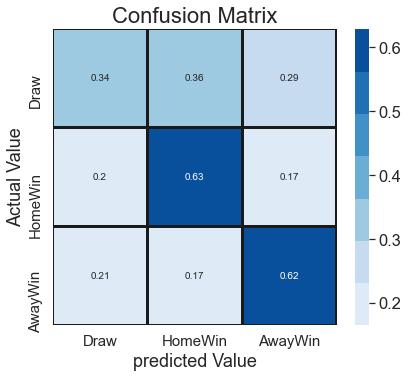

In [281]:
#evaluate the model on the train and test set
evaluate_model(output.best_estimator_,X_train_resampled,X_test_scaled,y_train_resampled,y_test)

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
